In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import fish_models
import robofish.io

In [2]:
fishes = 12
clusters = 4
cluster_step = 1

The expectation-maximization algorithm is an approach for performing maximum likelihood estimation in the presence of latent variables. It does this by first estimating the values for the latent variables, then optimizing the model, then repeating these two steps until convergence. It is an effective and general approach and is most commonly used for density estimation with missing data, such as clustering algorithms like the Gaussian Mixture Model.

Maximum Likelihood Estimation involves treating the problem as an optimization or search problem, where we seek a set of parameters that results in the best fit for the joint probability of the data sample.

A limitation of maximum likelihood estimation is that it assumes that the dataset is complete, or fully observed. This does not mean that the model has access to all data; instead, it assumes that all variables that are relevant to the problem are present.

The EM algorithm is an iterative approach that cycles between two modes. The first mode attempts to estimate the missing or latent variables, called the estimation-step or E-step. The second mode attempts to optimize the parameters of the model to best explain the data, called the maximization-step or M-step.

* E-Step. Estimate the missing variables in the dataset.
* M-Step. Maximize the parameters of the model in the presence of the data.

In the EM algorithm, the estimation-step would estimate a value for the process latent variable for each data point, and the maximization step would optimize the parameters of the probability distributions in an attempt to best capture the density of the data. The process is repeated until a good set of latent values and a maximum likelihood is achieved that fits the data.

more: https://www.blopig.com/blog/2020/07/no-labels-no-problem-a-quick-introduction-to-gaussian-mixture-models/

In [3]:
from sklearn.mixture import GaussianMixture
import sklearn.cluster as cl
import sklearn.metrics as mt

class EMFishModel(fish_models.gym_interface.AbstractRaycastBasedModel):
    def choose_action(self, view: np.ndarray):
        # Return speed and turn from view
        param = np.random.randint(5, 51)
        speed = np.random.random() * param
        
        # step 1: try to find a neigbour to make a friendship
        X = view[0:4]
        turn = self.find_neigbour_fish(X)
        
        # step 2: avoid walls
        # if walls is to close - avoid wall first 
        if view[6] > 0.9:
            turn = 5 * np.pi
        
        return speed, turn
    
    def fit(self, view: np.ndarray):
        X = view[:, 0:4]
        #print(view[:, 0:4])
        self.gm_model = GaussianMixture(n_components=1, random_state=0).fit(X)
        return self
    
    def find_neigbour_fish(self, X):
        # go straight by default
        turn = 0
        
        # Provide the predict method with the same 2D array, but with one value that you want to process 
        # Only use predict on data that is of the same dimensionality as the training data (X) was.
        # Expected the input data X to be 1 sample with 4 features
        X = X.reshape(1, -1)
        print(X)
        
        # Predict the labels for the data samples in X using trained model.
        labels = self.gm_model.predict(X)
        
        bin_idx = labels[0]

        if bin_idx == 0:
            turn = - np.pi / 6
        elif bin_idx == 1: 
            param = np.random.randint(6, 13)
            turn = - np.pi/ param
        elif bin_idx == 2: 
            param = np.random.randint(1, 4)
            turn =  param * np.pi
        elif bin_idx == 3: 
            param = np.random.randint(4, 9)
            turn =  param * np.pi
        
        return turn
    
model = EMFishModel()

In [4]:
raycast = fish_models.gym_interface.Raycast(
            n_wall_raycasts=5,
            n_fish_bins=4,
            fov_angle_fish_bins=np.pi,
            fov_angle_wall_raycasts=np.pi,
            world_bounds=([-50, -50], [50, 50]),
        )



In [5]:
# TRAIN DATA
data_folder = Path("data/live_female_female/train")

dset = fish_models.datasets.io_dataset.IoDataset(
    data_folder,
    raycast,
    output_strings=["poses", "actions", "views"],
    reduce_dim=2,
    max_files=10,
)

  0%|          | 0/10 [00:00<?, ?it/s]

Loading data from 10 files.


  0%|          | 0/10 [00:00<?, ?it/s]

Calculating views from 10 files.


100%|██████████| 10/10 [00:19<00:00,  1.98s/it]

Created IoDataset:
Reduced the first 3 dimensions from (10, 2, 8989) to (179780)
poses	(179780, 3):	consisting of x, y, calc_ori_rad.
actions	(179760, 2):	consisting of speed[cm/s] and turn [rad/s].
views	(179760, 9):	4 fish_bins and 5 wall ray casts.



In [6]:
# TRAINING
# Estimate model parameters with the EM algorithm using the train data of fishes
print(dset["views"].shape)
model.fit(dset["views"])

(179760, 9)


In [7]:
# TEST DATA
data_folder_test = Path("data/live_female_female/test")

dset_test = fish_models.datasets.io_dataset.IoDataset(
    data_folder,
    raycast,
    output_strings=["poses", "actions", "views"],
    reduce_dim=2,
    max_files=5,
)

  0%|          | 0/5 [00:00<?, ?it/s]

Loading data from 5 files.


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating views from 5 files.


100%|██████████| 5/5 [00:08<00:00,  1.75s/it]

Created IoDataset:
Reduced the first 3 dimensions from (5, 2, 8989) to (89890)
poses	(89890, 3):	consisting of x, y, calc_ori_rad.
actions	(89880, 2):	consisting of speed[cm/s] and turn [rad/s].
views	(89880, 9):	4 fish_bins and 5 wall ray casts.



In [8]:
generator = fish_models.gym_interface.TrackGeneratorGymRaycast(
    model, raycast, [100,100], 25
)

track = generator.create_track(n_guppies=fishes, trackset_len=1000)
print(track.shape)

  0%|          | 4/999 [00:00<00:27, 36.60it/s]

[[0.54764 0.      0.      0.     ]]
[[0.78005 0.80637 0.84349 0.70048]]
[[0.83545 0.75945 0.94848 0.     ]]
[[0.47043 0.91146 0.87471 0.981  ]]
[[0.95251 0.76116 0.78005 0.     ]]
[[0.80749 0.80637 0.7247  0.95251]]
[[0.      0.      0.      0.65673]]
[[0.60555 0.      0.      0.     ]]
[[0.      0.78101 0.94848 0.     ]]
[[0. 0. 0. 0.]]
[[0.90733 0.88525 0.      0.     ]]
[[0.57841 0.91298 0.      0.91146]]
[[0.54732 0.      0.      0.     ]]
[[0.78944 0.81712 0.84724 0.84443]]
[[0.84443 0.76629 0.96454 0.     ]]
[[0.4718  0.9127  0.86979 0.978  ]]
[[0.      0.95557 0.78944 0.     ]]
[[0.79707 0.81712 0.72785 0.95557]]
[[0.      0.      0.      0.65162]]
[[0.60847 0.      0.      0.     ]]
[[0.      0.79111 0.96454 0.     ]]
[[0.      0.      0.      0.60847]]
[[0.90968 0.88416 0.      0.     ]]
[[0.57866 0.90729 0.      0.9127 ]]
[[0.54236 0.      0.      0.     ]]
[[0.80307 0.82363 0.85049 0.84999]]
[[0.84999 0.76663 0.97092 0.     ]]
[[0.47462 0.9166  0.86643 0.97566]]
[[0.96185 0.

  1%|▏         | 14/999 [00:00<00:24, 40.88it/s]


[[0.49198 0.74464 0.91591 0.96131]]
[[0.      0.98901 0.85747 0.72386]]
[[0.78316 0.86518 0.72278 0.98901]]
[[0.      0.      0.      0.57621]]
[[0.6282 0.     0.     0.    ]]
[[0.      0.82063 0.75393 0.     ]]
[[0.     0.     0.     0.6282]]
[[0.75393 0.93319 0.      0.     ]]
[[0.5912  0.92061 0.      0.93319]]
[[0.52936 0.      0.      0.     ]]
[[0.86734 0.73456 0.      0.87761]]
[[0.67371 0.87761 0.74252 0.     ]]
[[0.      0.75397 0.91708 0.96074]]
[[0.      0.99003 0.85986 0.72222]]
[[0.78701 0.86734 0.72187 0.     ]]
[[0.      0.      0.      0.57576]]
[[0.63303 0.      0.      0.     ]]
[[0.      0.8204  0.82812 0.     ]]
[[0.      0.      0.63303 0.74252]]
[[0.76268 0.93441 0.88054 0.     ]]
[[0.59213 0.91441 0.      0.93441]]
[[0.52807 0.      0.      0.     ]]
[[0.86922 0.73533 0.      0.87957]]
[[0.67365 0.87957 0.74484 0.     ]]
[[0.      0.7568  0.91507 0.95609]]
[[0.99518 0.7864  0.8691  0.72075]]
[[0.78898 0.86922 0.71709 0.99518]]
[[0.      0.      0.      0.57552]]

  2%|▏         | 19/999 [00:00<00:23, 41.75it/s]

[[0.68338 0.      0.      0.     ]]
[[0.      0.82867 0.84504 0.64198]]
[[0.      0.      0.      0.73423]]
[[0.97021 0.81526 0.8892  0.     ]]
[[0.62115 0.89734 0.      0.97021]]
[[0.63547 0.55192 0.      0.     ]]
[[0.91476 0.      0.75678 0.92631]]
[[0.68922 0.92631 0.      0.77152]]
[[0.      0.64569 0.79388 0.92832]]
[[0.      0.8524  0.91476 0.72128]]
[[0.90738 0.46451 0.73402 0.     ]]
[[0.      0.      0.55192 0.64359]]
[[0.68391 0.      0.      0.     ]]
[[0.      0.83098 0.8478  0.64359]]
[[0.      0.      0.      0.73277]]
[[0.97189 0.8197  0.89113 0.     ]]
[[0.622   0.89823 0.      0.97189]]
[[0.6281  0.56019 0.      0.     ]]
[[0.91981 0.      0.75721 0.93383]]
[[0.69228 0.93383 0.      0.77458]]
[[0.      0.64569 0.80352 0.92566]]
[[0.      0.86504 0.91981 0.7223 ]]
[[0.9095  0.47123 0.73683 0.     ]]
[[0.      0.      0.56019 0.64906]]
[[0.67953 0.6851  0.      0.     ]]
[[0.      0.8394  0.85766 0.64906]]
[[0.      0.      0.      0.72728]]
[[0.66289 0.97391 0.89331 0.

  3%|▎         | 27/999 [00:00<00:19, 50.17it/s]

[[0.      0.      0.      0.72259]]
[[0.51941 0.89319 0.88147 0.98703]]
[[0.64793 0.89402 0.      0.     ]]
[[0.60198 0.61081 0.      0.     ]]
[[0.96568 0.      0.76602 0.68592]]
[[0.69644 0.95649 0.      0.76908]]
[[0.      0.55415 0.8557  0.90731]]
[[0.75768 0.96568 0.51555 0.71502]]
[[0.92219 0.50327 0.74338 0.     ]]
[[0.      0.      0.61081 0.56933]]
[[0.72532 0.72815 0.      0.     ]]
[[0.85491 0.89471 0.89843 0.8557 ]]
[[0.      0.      0.      0.72815]]
[[0.52018 0.89843 0.879   0.97798]]
[[0.65586 0.90035 0.      0.     ]]
[[0.59965 0.61473 0.      0.     ]]
[[0.96701 0.      0.76591 0.6866 ]]
[[0.69662 0.88324 0.95808 0.     ]]
[[0.      0.56745 0.86918 0.90733]]
[[0.7566  0.96701 0.51647 0.71363]]
[[0.92236 0.50732 0.7455  0.     ]]
[[0.      0.      0.61473 0.56809]]
[[0.72388 0.73252 0.      0.     ]]

  3%|▎         | 34/999 [00:00<00:17, 54.67it/s]


[[0.85532 0.89806 0.90554 0.86918]]
[[0.      0.      0.      0.73252]]
[[0.52305 0.90554 0.87738 0.97566]]
[[0.68156 0.90017 0.      0.     ]]
[[0.59351 0.62452 0.      0.     ]]
[[0.97642 0.      0.76524 0.68734]]
[[0.69984 0.9453  0.96854 0.     ]]
[[0.      0.58024 0.88364 0.90733]]
[[0.75624 0.97642 0.65781 0.71349]]
[[0.92234 0.5094  0.74381 0.     ]]
[[0.      0.      0.      0.62452]]
[[0.71473 0.73736 0.      0.     ]]
[[0.85772 0.90371 0.91517 0.88364]]
[[0.      0.      0.      0.73736]]
[[0.52501 0.91517 0.87345 0.96585]]
[[0.66669 0.90558 0.      0.     ]]
[[0.59079 0.6344  0.      0.     ]]
[[0.      0.      0.76258 0.68783]]
[[0.69939 0.95197 0.96943 0.     ]]
[[0.      0.58756 0.71084 0.88871]]
[[0.75093 0.98062 0.66534 0.71131]]
[[0.89614 0.51155 0.74147 0.     ]]
[[0.     0.     0.     0.6344]]
[[0.71278 0.74197 0.      0.     ]]
[[0.86011 0.90608 0.92536 0.88871]]
[[0.      0.      0.      0.74197]]
[[0.53003 0.92536 0.65381 0.95816]]
[[0.6753  0.91359 0.      0.   

  4%|▍         | 41/999 [00:00<00:16, 57.81it/s]


[[0.72677 0.6413  0.70968 0.59715]]
[[0.7299  0.732   0.70968 0.54093]]
[[0.67184 0.54811 0.75198 0.     ]]
[[0.      0.      0.      0.69877]]
[[0.69837 0.79703 0.      0.     ]]
[[0.9797  0.92567 0.      0.     ]]
[[0.      0.      0.      0.79703]]
[[0.56618 0.732   0.70159 0.85977]]
[[0.68017 0.88995 0.      0.     ]]
[[0.65039 0.70845 0.      0.     ]]
[[0.      0.      0.      0.75386]]
[[0.70025 0.93362 0.      0.     ]]
[[0.72098 0.65039 0.72417 0.60033]]
[[0.73024 0.74173 0.72417 0.54461]]
[[0.68074 0.55169 0.75333 0.     ]]
[[0.      0.      0.      0.70845]]
[[0.6995  0.80325 0.      0.     ]]
[[0.97945 0.92554 0.      0.     ]]
[[0.      0.      0.80325 0.7041 ]]
[[0.56878 0.74173 0.70368 0.85728]]
[[0.68937 0.88864 0.      0.     ]]
[[0.65841 0.7095  0.      0.     ]]
[[0.      0.      0.      0.75355]]
[[0.93431 0.      0.      0.     ]]
[[0.72155 0.65841 0.73515 0.60325]]
[[0.7306  0.74649 0.73515 0.54657]]
[[0.69144 0.55503 0.75602 0.     ]]
[[0.     0.     0.     0.70

  5%|▍         | 48/999 [00:00<00:15, 59.61it/s]


[[0.69346 0.8921  0.      0.     ]]
[[0.65976 0.      0.71098 0.     ]]
[[0.      0.      0.      0.75137]]
[[0.93854 0.      0.      0.     ]]
[[0.7197  0.65976 0.74079 0.60489]]
[[0.72759 0.75258 0.74079 0.54851]]
[[0.67861 0.69514 0.75891 0.     ]]
[[0.      0.      0.      0.71098]]
[[0.70718 0.81358 0.      0.     ]]
[[0.83611 0.92248 0.      0.     ]]
[[0.      0.      0.      0.81358]]
[[0.57009 0.75258 0.70916 0.85542]]
[[0.69863 0.89473 0.      0.     ]]
[[0.66438 0.      0.72119 0.     ]]
[[0.      0.      0.      0.75183]]
[[0.93723 0.      0.      0.     ]]
[[0.71757 0.66438 0.74611 0.60615]]
[[0.7273  0.75609 0.74611 0.55249]]
[[0.68242 0.70328 0.76289 0.     ]]
[[0.      0.      0.72119 0.56854]]
[[0.70899 0.81784 0.      0.     ]]
[[0.8336 0.9194 0.     0.    ]]
[[0.      0.      0.      0.81784]]
[[0.57115 0.75609 0.71145 0.85377]]
[[0.70052 0.89628 0.      0.     ]]
[[0.66917 0.      0.72527 0.     ]]
[[0.      0.      0.      0.74955]]
[[0.93717 0.      0.      0.   

  6%|▌         | 55/999 [00:01<00:15, 62.00it/s]


[[0.71876 0.77393 0.79469 0.     ]]
[[0.      0.      0.      0.77692]]
[[0.74572 0.      0.87411 0.     ]]
[[0.90977 0.      0.      0.     ]]
[[0.      0.      0.      0.87411]]
[[0.59975 0.8094  0.      0.83358]]
[[0.73913 0.89405 0.      0.     ]]
[[0.72814 0.      0.77952 0.     ]]
[[0.      0.      0.      0.73554]]
[[0.69587 0.      0.      0.     ]]
[[0.72116 0.72814 0.78249 0.80254]]
[[0.72222 0.74809 0.81484 0.80254]]
[[0.7228  0.78249 0.79779 0.     ]]
[[0.      0.      0.      0.77952]]
[[0.74809 0.      0.87575 0.     ]]
[[0.90835 0.      0.      0.     ]]
[[0.      0.      0.      0.87575]]
[[0.85758 0.81484 0.      0.8339 ]]
[[0.74238 0.89741 0.      0.     ]]
[[0.73017 0.      0.78229 0.     ]]
[[0.      0.      0.      0.73492]]
[[0.6982 0.     0.     0.    ]]
[[0.72069 0.73017 0.7855  0.80531]]
[[0.72343 0.75193 0.82503 0.80531]]
[[0.72925 0.7855  0.79945 0.     ]]
[[0.      0.      0.      0.78229]]
[[0.75193 0.      0.88251 0.     ]]
[[0.90386 0.      0.      0.   

  6%|▌         | 62/999 [00:01<00:14, 62.49it/s]


[[0.73411 0.      0.79051 0.     ]]
[[0.      0.      0.      0.73238]]
[[0.69957 0.      0.      0.     ]]
[[0.71708 0.73411 0.79518 0.81448]]
[[0.72799 0.76448 0.84147 0.81448]]
[[0.73496 0.79518 0.64689 0.8056 ]]
[[0.      0.      0.      0.79051]]
[[0.76448 0.      0.89771 0.     ]]
[[0.89908 0.      0.      0.     ]]
[[0.      0.      0.      0.89771]]
[[0.85604 0.84147 0.7275  0.82318]]
[[0.76077 0.88743 0.      0.     ]]
[[0.74544 0.      0.7949  0.     ]]
[[0.      0.      0.      0.73076]]
[[0.69863 0.      0.      0.     ]]
[[0.72039 0.74544 0.80539 0.81774]]
[[0.72701 0.76516 0.84305 0.81774]]
[[0.73708 0.80539 0.6499  0.80733]]
[[0.     0.     0.     0.7949]]
[[0.76516 0.      0.90163 0.     ]]
[[0.89491 0.      0.      0.     ]]
[[0.      0.      0.      0.90163]]
[[0.85128 0.84305 0.72814 0.82121]]
[[0.76184 0.88855 0.      0.     ]]
[[0.68167 0.74993 0.79903 0.     ]]
[[0. 0. 0. 0.]]
[[0.69793 0.      0.      0.     ]]
[[0.72053 0.74993 0.80945 0.81881]]
[[0.71932 0.766

  7%|▋         | 69/999 [00:01<00:14, 63.87it/s]

[[0.70854 0.7855  0.88793 0.82661]]
[[0.77101 0.8563  0.68089 0.83019]]
[[0.      0.      0.      0.82664]]
[[0.78453 0.      0.      0.91649]]
[[0.89249 0.      0.      0.     ]]
[[0. 0. 0. 0.]]
[[0.84237 0.88793 0.72709 0.80855]]
[[0.7855  0.87279 0.80369 0.     ]]
[[0.83161 0.79997 0.      0.83091]]
[[0. 0. 0. 0.]]
[[0.69294 0.      0.      0.     ]]
[[0.7178  0.79997 0.86517 0.70238]]
[[0.71156 0.79263 0.90267 0.82574]]
[[0.77825 0.86517 0.68165 0.83161]]
[[0.      0.      0.      0.83091]]
[[0.78964 0.      0.      0.91848]]
[[0.89011 0.      0.      0.     ]]
[[0. 0. 0. 0.]]
[[0.83774 0.77825 0.90267 0.80541]]
[[0.79263 0.86875 0.80662 0.     ]]
[[0.83185 0.80414 0.      0.83222]]
[[0. 0. 0. 0.]]
[[0.69236 0.      0.      0.     ]]
[[0.71757 0.80414 0.86726 0.70318]]
[[0.70776 0.79415 0.9061  0.     ]]
[[0.7799  0.86726 0.68093 0.83185]]
[[0.      0.      0.      0.83222]]
[[0.79076 0.      0.      0.91511]]
[[0.89133 0.      0.      0.     ]]
[[0. 0. 0. 0.]]
[[0.83638 0.7799  0.

  8%|▊         | 76/999 [00:01<00:14, 62.92it/s]


[[0.78289 0.87339 0.68106 0.83401]]
[[0. 0. 0. 0.]]
[[0.79314 0.73476 0.      0.90806]]
[[0.88616 0.      0.      0.     ]]
[[0. 0. 0. 0.]]
[[0.83301 0.78289 0.91175 0.     ]]
[[0.79902 0.86926 0.80945 0.     ]]
[[0.83684 0.82749 0.      0.8413 ]]
[[0. 0. 0. 0.]]
[[0.68491 0.      0.      0.     ]]
[[0.71744 0.82749 0.87705 0.70215]]
[[0.      0.80388 0.91749 0.     ]]
[[0.82841 0.87705 0.      0.83684]]
[[0. 0. 0. 0.]]
[[0.79677 0.73545 0.      0.     ]]
[[0.88623 0.      0.      0.     ]]
[[0.      0.      0.      0.81035]]
[[0.83324 0.78553 0.91749 0.     ]]
[[0.80388 0.86782 0.81035 0.     ]]
[[0.84131 0.57049 0.      0.84216]]
[[0. 0. 0. 0.]]
[[0.68296 0.      0.      0.     ]]
[[0.71594 0.83391 0.88521 0.6994 ]]
[[0.      0.80663 0.92188 0.     ]]
[[0.82688 0.88521 0.      0.84131]]
[[0. 0. 0. 0.]]
[[0.79844 0.73393 0.      0.     ]]
[[0.88397 0.      0.      0.     ]]
[[0.      0.      0.      0.81344]]
[[0.83288 0.7904  0.92188 0.     ]]
[[0.80663 0.86676 0.81344 0.     ]]
[[0

  9%|▉         | 90/999 [00:01<00:14, 64.48it/s]


[[0.8796  0.65433 0.86633 0.8577 ]]
[[0.90138 0.61496 0.      0.     ]]
[[0.      0.      0.75334 0.72498]]
[[0.55383 0.      0.      0.     ]]
[[0.      0.90138 0.      0.95173]]
[[0.83059 0.88068 0.      0.75451]]
[[0.84001 0.65763 0.95173 0.87412]]
[[0.      0.      0.      0.55383]]
[[0.62505 0.75334 0.      0.     ]]
[[0.      0.      0.      0.44942]]
[[0.      0.      0.68711 0.86862]]
[[0.84001 0.      0.68695 0.72362]]
[[0.88068 0.65917 0.86682 0.86862]]
[[0.9043  0.61624 0.      0.     ]]
[[0.      0.      0.75422 0.72455]]
[[0.55697 0.      0.      0.     ]]
[[0.      0.9043  0.      0.95348]]
[[0.83214 0.88441 0.      0.74763]]
[[0.8411  0.65529 0.95348 0.87517]]
[[0.      0.      0.      0.55697]]
[[0.62498 0.75422 0.      0.     ]]
[[0.      0.      0.      0.44962]]
[[0.      0.      0.68554 0.87398]]
[[0.8411  0.      0.68292 0.72455]]
[[0.88441 0.66107 0.86822 0.87398]]
[[0.90857 0.61873 0.      0.     ]]
[[0.      0.      0.75596 0.72586]]
[[0.55833 0.      0.      0

 10%|█         | 104/999 [00:01<00:13, 65.88it/s]

[[0.69578 0.      0.      0.     ]]
[[0.94083 0.72495 0.      0.69578]]
[[0.83511 0.92492 0.82166 0.72606]]
[[0.74569 0.68365 0.      0.8999 ]]
[[0. 0. 0. 0.]]
[[0.76067 0.83188 0.      0.     ]]
[[0.      0.      0.      0.66053]]
[[0.      0.      0.69548 0.57716]]
[[0.86521 0.      0.70825 0.75629]]
[[0.79454 0.7472  0.89049 0.     ]]
[[0.90549 0.66025 0.6709  0.     ]]
[[0.      0.      0.83665 0.75737]]
[[0.69636 0.      0.      0.     ]]
[[0.93999 0.73047 0.      0.69636]]
[[0.83409 0.92535 0.82448 0.72571]]
[[0.74465 0.68812 0.      0.90549]]
[[0. 0. 0. 0.]]
[[0.75741 0.83665 0.      0.     ]]
[[0.     0.     0.     0.6709]]
[[0.      0.      0.69524 0.57963]]
[[0.86726 0.      0.71252 0.75737]]
[[0.7893  0.7524  0.89184 0.     ]]
[[0.90865 0.66151 0.67554 0.     ]]
[[0.      0.      0.84434 0.75803]]
[[0.69664 0.      0.      0.     ]]
[[0.      0.73059 0.      0.69664]]
[[0.92619 0.      0.8265  0.     ]]
[[0.7457  0.69608 0.      0.90865]]
[[0. 0. 0. 0.]]
[[0.75605 0.84434 0.

 12%|█▏        | 119/999 [00:01<00:13, 67.34it/s]

[[0.80802 0.58142 0.75283 0.     ]]
[[0.74335 0.54546 0.89701 0.     ]]
[[0.80656 0.92828 0.70619 0.     ]]
[[0.      0.9429  0.84155 0.73405]]
[[0.69838 0.63537 0.      0.     ]]
[[0.      0.      0.75333 0.     ]]
[[0.91354 0.      0.      0.87979]]
[[0.72278 0.      0.73115 0.     ]]
[[0.      0.      0.63537 0.58418]]
[[0.72992 0.5862  0.9429  0.     ]]
[[0. 0. 0. 0.]]
[[0.      0.      0.6707  0.65056]]
[[0.80656 0.58418 0.75245 0.     ]]
[[0.74324 0.5446  0.89399 0.     ]]
[[0.80717 0.92901 0.70609 0.     ]]
[[0.      0.95531 0.85624 0.73332]]
[[0.69751 0.63691 0.      0.     ]]
[[0.      0.      0.75822 0.     ]]
[[0.9088  0.      0.      0.87951]]
[[0.72032 0.65797 0.73049 0.     ]]
[[0.      0.      0.63691 0.58602]]
[[0.72944 0.58696 0.95531 0.     ]]
[[0. 0. 0. 0.]]
[[0.      0.      0.67833 0.65797]]
[[0.80717 0.58602 0.75356 0.     ]]
[[0.74337 0.54731 0.89711 0.     ]]
[[0.80754 0.92772 0.70546 0.     ]]
[[0.      0.      0.96454 0.61554]]
[[0.69907 0.64289 0.      0.    

 13%|█▎        | 126/999 [00:02<00:13, 66.10it/s]


[[0.7297  0.60471 0.      0.     ]]
[[0.      0.      0.      0.58643]]
[[0.      0.68672 0.70963 0.59622]]
[[0.      0.77737 0.      0.76799]]
[[0.73222 0.55784 0.90313 0.9262 ]]
[[0.62212 0.67339 0.97559 0.73044]]
[[0.      0.      0.80075 0.93133]]
[[0.6989  0.72883 0.      0.     ]]
[[0.     0.     0.     0.7951]]
[[0. 0. 0. 0.]]
[[0.68771 0.71219 0.      0.73943]]
[[0.      0.      0.72883 0.64943]]
[[0.72775 0.60116 0.      0.     ]]
[[0.      0.      0.      0.58675]]
[[0.      0.67903 0.71219 0.59386]]
[[0.     0.7796 0.     0.7693]]
[[0.7321  0.5588  0.90761 0.93133]]
[[0.62489 0.6766  0.9791  0.72924]]
[[0.      0.      0.80347 0.93383]]
[[0.70043 0.73454 0.      0.     ]]
[[0.      0.      0.      0.79489]]
[[0. 0. 0. 0.]]
[[0.68754 0.71455 0.      0.73775]]
[[0.      0.      0.73454 0.65278]]
[[0.72614 0.59916 0.      0.     ]]
[[0.      0.      0.      0.58668]]
[[0.      0.67759 0.71455 0.59321]]
[[0.      0.78059 0.      0.77028]]
[[0.73145 0.55909 0.90974 0.93383]]
[[0

 13%|█▎        | 134/999 [00:02<00:12, 69.35it/s]

[[0. 0. 0. 0.]]
[[0.      0.66927 0.      0.76316]]
[[0.      0.78359 0.71038 0.79503]]
[[0.7034  0.55825 0.91133 0.     ]]
[[0.6496  0.69644 0.73526 0.96716]]
[[0.      0.      0.82933 0.66707]]
[[0.79856 0.70945 0.80485 0.     ]]
[[0.58149 0.      0.      0.     ]]
[[0. 0. 0. 0.]]
[[0.69222 0.76406 0.      0.7257 ]]
[[0.      0.80485 0.71796 0.57413]]
[[0.6496  0.71001 0.      0.     ]]
[[0. 0. 0. 0.]]
[[0.      0.67016 0.      0.76406]]
[[0.      0.78745 0.71796 0.79856]]
[[0.69806 0.55642 0.90604 0.     ]]
[[0.65165 0.69856 0.74098 0.96527]]
[[0.      0.      0.82944 0.66222]]
[[0.7997  0.70932 0.80712 0.     ]]
[[0.5815 0.     0.     0.    ]]
[[0. 0. 0. 0.]]
[[0.69275 0.77155 0.      0.72639]]
[[0.      0.80712 0.72079 0.57285]]
[[0.65165 0.7095  0.      0.     ]]
[[0. 0. 0. 0.]]
[[0.      0.      0.6775  0.77155]]
[[0.      0.78781 0.72079 0.7997 ]]
[[0.69856 0.55875 0.90777 0.     ]]
[[0.65387 0.70038 0.7478  0.96305]]
[[0.      0.      0.82885 0.65481]]
[[0.80111 0.71004 0.8140

 14%|█▍        | 141/999 [00:02<00:12, 66.53it/s]


[[0.69572 0.66679 0.79576 0.72334]]
[[0.      0.      0.82542 0.73522]]
[[0.65877 0.71152 0.      0.     ]]
[[0. 0. 0. 0.]]
[[0.      0.      0.69056 0.79576]]
[[0.51343 0.78932 0.73522 0.80214]]
[[0.70538 0.56204 0.90748 0.     ]]
[[0.66314 0.7079  0.64604 0.95346]]
[[0.      0.      0.83123 0.64994]]
[[0.80254 0.70954 0.83266 0.     ]]
[[0.5784 0.     0.     0.    ]]
[[0. 0. 0. 0.]]
[[0.69635 0.66558 0.80042 0.71724]]
[[0.      0.      0.83266 0.73847]]
[[0.66314 0.72028 0.      0.     ]]
[[0. 0. 0. 0.]]
[[0.      0.      0.68573 0.80042]]
[[0.50854 0.78584 0.73847 0.80254]]
[[0.7079  0.56244 0.90113 0.     ]]
[[0.66424 0.70866 0.63558 0.95265]]
[[0.      0.82801 0.64648 0.6406 ]]
[[0.80584 0.70686 0.83834 0.     ]]
[[0.58219 0.      0.      0.     ]]
[[0. 0. 0. 0.]]
[[0.69635 0.65587 0.80414 0.71255]]
[[0.      0.      0.83834 0.7477 ]]
[[0.66424 0.71604 0.      0.     ]]
[[0.      0.      0.      0.58219]]
[[0.      0.      0.68337 0.80414]]
[[0.5078  0.78735 0.7477  0.80584]]
[[0

 15%|█▍        | 149/999 [00:02<00:12, 68.68it/s]

[[0.68899 0.70636 0.      0.     ]]
[[0.      0.      0.60471 0.52365]]
[[0.      0.      0.69848 0.49123]]
[[0.52365 0.78893 0.78079 0.82553]]
[[0.73414 0.68073 0.907   0.     ]]
[[0.69229 0.73812 0.67172 0.92984]]
[[0.      0.      0.81872 0.6744 ]]
[[0.82964 0.73492 0.91721 0.     ]]
[[0.      0.      0.      0.76987]]
[[0.      0.      0.74567 0.70145]]
[[0.70194 0.70145 0.84483 0.     ]]
[[0.      0.      0.91721 0.78811]]
[[0.69229 0.70224 0.      0.     ]]
[[0.      0.      0.60278 0.52702]]
[[0.      0.      0.69854 0.48509]]
[[0.52702 0.79083 0.      0.82964]]
[[0.73812 0.67862 0.90989 0.     ]]
[[0.      0.74324 0.67769 0.92868]]
[[0.      0.      0.82089 0.68005]]
[[0.83034 0.7372  0.92074 0.     ]]
[[0.      0.      0.      0.76884]]
[[0.      0.      0.74575 0.70515]]
[[0.70208 0.70515 0.84607 0.     ]]
[[0.      0.      0.92074 0.78867]]
[[0.69647 0.70259 0.      0.     ]]
[[0.     0.     0.     0.6043]]
[[0.      0.      0.69927 0.48547]]
[[0.52793 0.79091 0.      0.8303

 16%|█▌        | 156/999 [00:02<00:12, 66.43it/s]


[[0.      0.      0.82605 0.67372]]
[[0.8335  0.74285 0.92921 0.     ]]
[[0.      0.      0.      0.76844]]
[[0.      0.      0.73935 0.713  ]]
[[0.70291 0.713   0.      0.85133]]
[[0.      0.      0.92921 0.79324]]
[[0.70235 0.69969 0.      0.     ]]
[[0.      0.      0.61153 0.69985]]
[[0.      0.70252 0.47927 0.85133]]
[[0.5416  0.79168 0.      0.8335 ]]
[[0.74999 0.67948 0.91506 0.     ]]
[[0.      0.75182 0.68871 0.7769 ]]
[[0.      0.      0.82181 0.67522]]
[[0.83704 0.74476 0.93083 0.     ]]
[[0.      0.      0.      0.76984]]
[[0.      0.      0.74239 0.7176 ]]
[[0.70313 0.7176  0.      0.85344]]
[[0.      0.      0.93083 0.79966]]
[[0.70413 0.68965 0.      0.     ]]
[[0.      0.      0.60903 0.69911]]
[[0.      0.70444 0.47567 0.85344]]
[[0.54667 0.79972 0.      0.83704]]
[[0.75182 0.66971 0.91566 0.     ]]
[[0.      0.7576  0.69825 0.     ]]
[[0.      0.      0.8287  0.67981]]
[[0.83827 0.7455  0.      0.93192]]
[[0.      0.      0.      0.77134]]
[[0.      0.74673 0.72947 0

 16%|█▋        | 164/999 [00:02<00:12, 67.83it/s]

[[0.73692 0.7809  0.70831 0.73752]]
[[0.      0.      0.      0.82467]]
[[0.85217 0.45168 0.77399 0.     ]]
[[0.      0.      0.      0.77399]]
[[0.      0.      0.78791 0.73752]]
[[0.70635 0.78791 0.      0.86511]]
[[0.      0.      0.63356 0.96819]]
[[0.73692 0.69232 0.65392 0.     ]]
[[0.      0.      0.61423 0.63788]]
[[0.      0.      0.71849 0.54197]]
[[0.58914 0.      0.8176  0.     ]]
[[0.7809  0.65649 0.91482 0.     ]]
[[0.74018 0.78273 0.70562 0.74077]]
[[0.      0.      0.      0.82552]]
[[0.85267 0.45502 0.77543 0.     ]]
[[0.      0.      0.      0.77543]]
[[0.      0.      0.76139 0.79643]]
[[0.70714 0.70281 0.79643 0.86476]]
[[0.      0.      0.64169 0.96765]]
[[0.74018 0.69775 0.66171 0.     ]]
[[0.      0.      0.61631 0.59249]]
[[0.      0.      0.71776 0.54195]]
[[0.59249 0.      0.81973 0.     ]]
[[0.78273 0.65546 0.91105 0.     ]]
[[0.74846 0.79205 0.71161 0.74728]]
[[0.     0.     0.     0.8241]]
[[0.85683 0.46586 0.78451 0.     ]]
[[0.      0.      0.      0.7845

 17%|█▋        | 171/999 [00:02<00:12, 65.16it/s]

[[0.60451 0.      0.82741 0.     ]]
[[0.79227 0.64756 0.90382 0.     ]]
[[0.75341 0.79474 0.7094  0.75166]]
[[0.      0.      0.      0.81459]]
[[0.59325 0.85712 0.78811 0.     ]]
[[0.      0.      0.      0.78811]]
[[0.      0.      0.77099 0.81729]]
[[0.70826 0.70798 0.81729 0.     ]]
[[0.      0.      0.67775 0.56539]]
[[0.75341 0.71023 0.68291 0.     ]]
[[0.      0.      0.61686 0.60694]]
[[0.      0.      0.71716 0.54253]]
[[0.60694 0.      0.8262  0.     ]]
[[0.79474 0.65131 0.9011  0.     ]]
[[0.75564 0.79675 0.71061 0.75372]]
[[0.      0.      0.8083  0.71061]]
[[0.59404 0.85895 0.79282 0.     ]]
[[0.      0.      0.      0.79282]]
[[0.      0.      0.7722  0.82249]]
[[0.70753 0.70933 0.82249 0.     ]]
[[0.      0.      0.68972 0.56672]]
[[0.75564 0.71601 0.69068 0.     ]]
[[0.      0.      0.61311 0.61005]]
[[0.      0.      0.72264 0.54361]]
[[0.61005 0.      0.82603 0.     ]]
[[0.79675 0.65453 0.90087 0.     ]]
[[0.75581 0.79815 0.71069 0.7547 ]]
[[0.      0.      0.80348 0.

 18%|█▊        | 178/999 [00:02<00:12, 65.61it/s]

[[0.70428 0.72855 0.85415 0.     ]]
[[0.      0.      0.      0.73372]]
[[0.77112 0.72826 0.73372 0.     ]]
[[0.      0.62797 0.64484 0.60942]]
[[0.      0.      0.71735 0.54502]]
[[0.64484 0.      0.83088 0.     ]]
[[0.45859 0.67894 0.92127 0.     ]]
[[0.77465 0.81889 0.      0.72582]]
[[0.      0.      0.      0.79392]]
[[0.60239 0.88185 0.82605 0.     ]]
[[0.      0.      0.      0.72672]]
[[0.      0.79182 0.86154 0.76725]]
[[0.70371 0.73108 0.86154 0.     ]]
[[0.      0.      0.      0.73859]]
[[0.77465 0.7296  0.73859 0.     ]]
[[0.      0.6316  0.65395 0.60655]]
[[0.      0.      0.71543 0.43456]]
[[0.65395 0.      0.82792 0.     ]]
[[0.46585 0.68295 0.92468 0.     ]]
[[0.77602 0.82024 0.      0.72523]]
[[0.      0.      0.      0.79497]]
[[0.60243 0.88141 0.82647 0.     ]]
[[0. 0. 0. 0.]]
[[0.      0.78967 0.52896 0.86501]]
[[0.70389 0.73359 0.86501 0.     ]]
[[0.      0.      0.      0.74527]]
[[0.77602 0.73012 0.74527 0.     ]]
[[0.      0.63149 0.65716 0.60518]]
[[0.      0.

 19%|█▊        | 185/999 [00:02<00:12, 65.15it/s]


[[0.      0.78253 0.52985 0.87684]]
[[0.86837 0.7458  0.      0.87684]]
[[0.      0.      0.      0.76279]]
[[0.7875  0.74307 0.72712 0.76279]]
[[0.      0.      0.67396 0.59022]]
[[0.      0.      0.      0.71939]]
[[0.54553 0.67396 0.      0.82867]]
[[0.5381  0.68069 0.91513 0.     ]]
[[0.78894 0.83704 0.      0.72546]]
[[0.      0.      0.      0.79657]]
[[0.60814 0.90139 0.      0.84717]]
[[0.      0.      0.      0.84717]]
[[0.      0.78058 0.53401 0.88208]]
[[0.86677 0.74782 0.      0.88208]]
[[0.      0.      0.      0.76693]]
[[0.78894 0.74376 0.72698 0.76693]]
[[0.      0.      0.68017 0.58852]]
[[0.      0.      0.      0.72055]]
[[0.54437 0.68017 0.      0.82677]]
[[0.53113 0.68116 0.9152  0.     ]]
[[0.79256 0.84238 0.      0.72797]]
[[0.      0.      0.      0.79196]]
[[0.60985 0.90852 0.      0.85267]]
[[0.      0.      0.      0.85267]]
[[0.      0.78437 0.53812 0.88481]]
[[0.86217 0.      0.7484  0.88481]]
[[0.      0.      0.      0.76972]]
[[0.65695 0.74466 0.72714 0

 19%|█▉        | 192/999 [00:03<00:13, 60.17it/s]

[[0.8691 0.     0.     0.    ]]
[[0.      0.      0.78585 0.71954]]
[[0.6991  0.91266 0.64945 0.     ]]
[[0.      0.      0.      0.67352]]
[[0.      0.      0.78263 0.49915]]
[[0.82493 0.      0.78585 0.     ]]
[[0.      0.      0.      0.80368]]
[[0.66055 0.55608 0.77099 0.80368]]
[[0.      0.      0.64945 0.73371]]
[[0.      0.      0.74199 0.57651]]
[[0.57651 0.73371 0.      0.81246]]
[[0.52689 0.70026 0.92621 0.74714]]
[[0.86767 0.      0.      0.     ]]
[[0.      0.      0.78945 0.71968]]
[[0.70437 0.91671 0.65568 0.     ]]
[[0.      0.      0.      0.67152]]
[[0.      0.      0.77871 0.49937]]
[[0.82381 0.      0.78945 0.     ]]
[[0.      0.      0.      0.80442]]
[[0.66052 0.55703 0.77133 0.     ]]
[[0.      0.      0.65568 0.73603]]
[[0.      0.      0.74375 0.57813]]
[[0.57813 0.73603 0.      0.80996]]
[[0.52676 0.70429 0.93062 0.75129]]
[[0.86788 0.      0.      0.     ]]
[[0.      0.      0.76079 0.79648]]
[[0.70687 0.91169 0.66292 0.     ]]
[[0. 0. 0. 0.]]
[[0.      0.    

 20%|█▉        | 199/999 [00:03<00:12, 62.42it/s]


[[0.      0.      0.      0.76894]]
[[0.66091 0.60694 0.8074  0.65422]]
[[0.      0.629   0.77996 0.60694]]
[[0.      0.      0.      0.73421]]
[[0.59495 0.77996 0.      0.     ]]
[[0.58702 0.70389 0.91883 0.76894]]
[[0.86584 0.      0.      0.     ]]
[[0.      0.      0.75945 0.82181]]
[[0.80788 0.53932 0.92719 0.     ]]
[[0.      0.      0.66263 0.83031]]
[[0.      0.78337 0.56814 0.58707]]
[[0.81423 0.      0.82181 0.     ]]
[[0.      0.      0.      0.76972]]
[[0.66084 0.60749 0.80788 0.65769]]
[[0.      0.62518 0.78824 0.60749]]
[[0.      0.      0.      0.73685]]
[[0.60058 0.78824 0.      0.     ]]
[[0.58707 0.69824 0.91872 0.76972]]
[[0.86717 0.      0.      0.     ]]
[[0.      0.      0.76    0.82461]]
[[0.80969 0.54558 0.92474 0.     ]]
[[0.      0.      0.65673 0.82609]]
[[0.      0.78512 0.56734 0.58739]]
[[0.81086 0.      0.82461 0.     ]]
[[0.      0.      0.      0.77066]]
[[0.66083 0.61441 0.80969 0.65891]]
[[0.      0.63287 0.80376 0.61441]]
[[0.      0.      0.      0

 21%|██        | 206/999 [00:03<00:13, 59.90it/s]


[[0.      0.      0.65099 0.66214]]
[[0.      0.78625 0.57465 0.58877]]
[[0.80693 0.      0.      0.83813]]
[[0.    0.    0.    0.772]]
[[0.66028 0.61957 0.81181 0.66214]]
[[0.      0.63459 0.8145  0.61957]]
[[0.      0.      0.      0.73206]]
[[0.6107 0.8145 0.     0.    ]]
[[0.58877 0.69396 0.92153 0.772  ]]
[[0.86454 0.      0.      0.     ]]
[[0.      0.      0.76172 0.83947]]
[[0.81246 0.55507 0.92721 0.     ]]
[[0.      0.      0.64879 0.6637 ]]
[[0.      0.79026 0.57461 0.58992]]
[[0.79912 0.      0.      0.83947]]
[[0.     0.     0.     0.6614]]
[[0.66029 0.62495 0.81246 0.6637 ]]
[[0.      0.      0.82194 0.62495]]
[[0.      0.      0.      0.72557]]
[[0.61076 0.82194 0.      0.     ]]
[[0.58992 0.70099 0.92784 0.77215]]
[[0.86511 0.      0.      0.     ]]
[[0.      0.76975 0.85006 0.69128]]
[[0.81859 0.56324 0.92716 0.     ]]
[[0.      0.      0.64889 0.66826]]
[[0.      0.78673 0.57236 0.59005]]
[[0.79799 0.      0.      0.85006]]
[[0.      0.      0.      0.66579]]
[[0.660

 21%|██▏       | 213/999 [00:03<00:12, 60.97it/s]

[[0.      0.      0.76874 0.86759]]
[[0.83354 0.54753 0.58325 0.9287 ]]
[[0.      0.      0.64881 0.78268]]
[[0.      0.76661 0.57737 0.58234]]
[[0.79987 0.      0.      0.86759]]
[[0.    0.    0.    0.679]]
[[0.65953 0.52981 0.83354 0.68575]]
[[0.      0.      0.86733 0.79864]]
[[0.     0.     0.     0.7145]]
[[0.55299 0.62477 0.86733 0.     ]]
[[0.59358 0.60159 0.93086 0.     ]]
[[0.84983 0.67976 0.      0.     ]]
[[0.      0.      0.76508 0.86817]]
[[0.84472 0.55332 0.58449 0.92465]]
[[0.      0.      0.65183 0.78075]]
[[0.      0.76615 0.57557 0.58961]]
[[0.79916 0.      0.      0.     ]]
[[0.      0.      0.      0.67976]]
[[0.65978 0.53722 0.84472 0.69519]]
[[0.      0.      0.88014 0.80669]]
[[0.      0.      0.      0.70631]]
[[0.55885 0.6287  0.88014 0.     ]]
[[0.59388 0.60711 0.92429 0.63247]]
[[0.8495  0.68457 0.      0.     ]]
[[0.      0.      0.76198 0.86837]]
[[0.84589 0.55969 0.5897  0.92414]]
[[0.      0.      0.6555  0.77701]]
[[0.      0.      0.7681  0.59033]]
[[0.

 22%|██▏       | 220/999 [00:03<00:12, 62.07it/s]


[[0.      0.      0.76818 0.57112]]
[[0.86399 0.57294 0.60032 0.92292]]
[[0.      0.      0.66041 0.70919]]
[[0.      0.      0.77298 0.57294]]
[[0.7977 0.     0.     0.    ]]
[[0.      0.      0.      0.69891]]
[[0.60261 0.55612 0.86399 0.     ]]
[[0.      0.      0.66118 0.9017 ]]
[[0.      0.      0.      0.68994]]
[[0.57072 0.63917 0.9017  0.     ]]
[[0.59793 0.62967 0.92518 0.65915]]
[[0.50524 0.70392 0.      0.     ]]
[[0.      0.      0.76259 0.56991]]
[[0.86707 0.57757 0.60291 0.92037]]
[[0.      0.      0.65996 0.70992]]
[[0.      0.      0.77599 0.57757]]
[[0.79836 0.      0.      0.     ]]
[[0.      0.      0.      0.70392]]
[[0.60439 0.5581  0.86707 0.     ]]
[[0.      0.      0.66612 0.90837]]
[[0.      0.      0.      0.68614]]
[[0.577   0.6445  0.90837 0.     ]]
[[0.60003 0.52155 0.93259 0.66594]]
[[0.50851 0.70666 0.      0.     ]]
[[0.      0.      0.75635 0.57003]]
[[0.87055 0.58083 0.60375 0.9142 ]]
[[0.      0.      0.66311 0.71082]]
[[0.      0.      0.78572 0.585

 23%|██▎       | 227/999 [00:03<00:12, 63.27it/s]

[[0.      0.      0.66844 0.93889]]
[[0.      0.      0.67549 0.69633]]
[[0.61493 0.69633 0.      0.93889]]
[[0.60347 0.53233 0.93822 0.68504]]
[[0.53717 0.74815 0.      0.     ]]
[[0.      0.77407 0.49987 0.61505]]
[[0.88922 0.56599 0.63133 0.89042]]
[[0.      0.66767 0.68563 0.72986]]
[[0.      0.      0.78047 0.61689]]
[[0.77864 0.      0.      0.     ]]
[[0.      0.      0.      0.74815]]
[[0.55623 0.61554 0.88922 0.     ]]
[[0.      0.      0.66991 0.93893]]
[[0.      0.      0.67567 0.69811]]
[[0.61689 0.69811 0.      0.     ]]
[[0.60234 0.5339  0.93765 0.68563]]
[[0.54651 0.75358 0.      0.     ]]
[[0.      0.77668 0.50622 0.61055]]
[[0.89309 0.56647 0.63629 0.88895]]
[[0.      0.67251 0.6921  0.72761]]
[[0.      0.77795 0.61889 0.61853]]
[[0.78024 0.      0.      0.     ]]
[[0.      0.      0.      0.75358]]
[[0.55929 0.61853 0.89309 0.     ]]
[[0.      0.      0.66949 0.8416 ]]
[[0.      0.      0.67695 0.70308]]
[[0.61889 0.70308 0.      0.     ]]
[[0.60403 0.53687 0.93762 0.

 23%|██▎       | 234/999 [00:03<00:12, 61.43it/s]

[[0.89732 0.57129 0.63201 0.87532]]
[[0.      0.68149 0.57135 0.72577]]
[[0.      0.77689 0.64363 0.63201]]
[[0.77736 0.      0.      0.     ]]
[[0.      0.      0.      0.76462]]
[[0.56375 0.62473 0.89732 0.74347]]
[[0.      0.      0.68003 0.84506]]
[[0.      0.      0.73549 0.58611]]
[[0.64363 0.73549 0.      0.     ]]
[[0.61318 0.54931 0.94658 0.70918]]
[[0.58013 0.76883 0.      0.     ]]
[[0.      0.76463 0.52257 0.58444]]
[[0.90179 0.57211 0.63803 0.87256]]
[[0.      0.6874  0.58013 0.72566]]
[[0.      0.78477 0.6539  0.63803]]
[[0.77391 0.      0.      0.     ]]
[[0.      0.      0.      0.76883]]
[[0.56789 0.63209 0.77828 0.90179]]
[[0.      0.      0.67867 0.84487]]
[[0.      0.      0.7427  0.59395]]
[[0.48944 0.7427  0.      0.     ]]
[[0.62101 0.56071 0.95211 0.     ]]
[[0.58488 0.77041 0.      0.     ]]
[[0.      0.76508 0.52709 0.58613]]
[[0.90335 0.57376 0.6416  0.86975]]
[[0.      0.69006 0.58488 0.72663]]
[[0.      0.7874  0.65954 0.6416 ]]
[[0.7728 0.     0.     0.   

 24%|██▍       | 241/999 [00:03<00:12, 62.84it/s]

[[0.5168  0.68205 0.77165 0.     ]]
[[0.60235 0.64036 0.96449 0.     ]]
[[0.60683 0.      0.78388 0.     ]]
[[0.      0.      0.78115 0.6055 ]]
[[0.92816 0.59537 0.68194 0.68638]]
[[0.      0.      0.6822  0.71622]]
[[0.      0.      0.79691 0.68757]]
[[0.43091 0.7815  0.      0.     ]]
[[0.      0.      0.      0.56667]]
[[0.59928 0.65694 0.92816 0.7604 ]]
[[0.      0.      0.68069 0.72526]]
[[0.      0.      0.78225 0.68638]]
[[0.52483 0.68757 0.78225 0.     ]]
[[0.6055  0.64173 0.96229 0.     ]]
[[0.60974 0.      0.78676 0.     ]]
[[0.      0.      0.78018 0.60574]]
[[0.92963 0.59851 0.68682 0.69222]]
[[0.      0.      0.68129 0.7165 ]]
[[0.      0.      0.79466 0.69517]]
[[0.43271 0.78094 0.      0.     ]]
[[0. 0. 0. 0.]]
[[0.6     0.65774 0.92963 0.76062]]
[[0.      0.      0.68061 0.72531]]
[[0.      0.      0.79573 0.69222]]
[[0.52964 0.69517 0.79573 0.     ]]
[[0.60574 0.64172 0.96183 0.     ]]
[[0.61365 0.      0.78774 0.     ]]
[[0.      0.      0.78917 0.61097]]
[[0.93081 0.

 25%|██▍       | 248/999 [00:04<00:11, 64.43it/s]


[[0.      0.      0.79704 0.71345]]
[[0.44075 0.77922 0.      0.     ]]
[[0. 0. 0. 0.]]
[[0.64662 0.66994 0.94152 0.78862]]
[[0.      0.      0.68218 0.48541]]
[[0.      0.      0.81234 0.70583]]
[[0.54321 0.70827 0.81234 0.     ]]
[[0.61676 0.65914 0.97451 0.73947]]
[[0.48595 0.62531 0.79259 0.     ]]
[[0.      0.      0.77918 0.62885]]
[[0.9201  0.62331 0.7159  0.70695]]
[[0.      0.      0.66994 0.70595]]
[[0.      0.      0.79834 0.71694]]
[[0.4415  0.77587 0.      0.     ]]
[[0. 0. 0. 0.]]
[[0.64681 0.67732 0.94829 0.79123]]
[[0.      0.      0.68188 0.48595]]
[[0.      0.      0.82154 0.70695]]
[[0.54838 0.71694 0.82154 0.     ]]
[[0.61744 0.66031 0.97092 0.74044]]
[[0.48711 0.63398 0.79975 0.     ]]
[[0.      0.      0.78096 0.63118]]
[[0.92032 0.6237  0.7165  0.70731]]
[[0.      0.      0.67278 0.70592]]
[[0.      0.      0.79942 0.71796]]
[[0.66512 0.7688  0.      0.     ]]
[[0. 0. 0. 0.]]
[[0.64681 0.67915 0.95006 0.7926 ]]
[[0.      0.      0.67925 0.48711]]
[[0.      0.   

 26%|██▌       | 255/999 [00:04<00:11, 65.01it/s]

[[0.64601 0.68589 0.95952 0.79298]]
[[0.      0.      0.      0.68176]]
[[0.      0.68703 0.8698  0.72564]]
[[0.57532 0.75257 0.8698  0.     ]]
[[0.62545 0.66434 0.9721  0.73859]]
[[0.49374 0.67028 0.82856 0.     ]]
[[0.      0.      0.76516 0.65479]]
[[0.65605 0.63505 0.65479 0.72403]]
[[0.      0.      0.6682  0.67028]]
[[0.      0.      0.81338 0.76016]]
[[0.65918 0.76024 0.      0.     ]]
[[0.      0.      0.      0.60713]]
[[0.64621 0.63574 0.96284 0.7946 ]]
[[0.      0.      0.      0.67991]]
[[0.      0.      0.87725 0.72682]]
[[0.47512 0.76016 0.87725 0.     ]]
[[0.63037 0.67047 0.97715 0.74045]]
[[0.49463 0.68032 0.83329 0.     ]]
[[0.      0.76386 0.66645 0.63736]]
[[0.65623 0.63869 0.66645 0.72268]]
[[0.      0.      0.67218 0.68032]]
[[0.      0.      0.81862 0.76744]]
[[0.65888 0.7545  0.      0.     ]]
[[0.      0.      0.      0.60894]]
[[0.64677 0.65097 0.9719  0.80014]]
[[0.    0.    0.    0.678]]
[[0.      0.      0.88512 0.72934]]
[[0.47561 0.76744 0.88512 0.     ]]


 26%|██▋       | 263/999 [00:04<00:10, 67.45it/s]


[[0.65623 0.65202 0.69317 0.72416]]
[[0.      0.67496 0.71895 0.67651]]
[[0.      0.      0.      0.81799]]
[[0.65579 0.74457 0.      0.     ]]
[[0.      0.      0.      0.62945]]
[[0.64666 0.98078 0.70723 0.80753]]
[[0.      0.      0.67651 0.50666]]
[[0.      0.      0.90479 0.73069]]
[[0.47383 0.78239 0.      0.90479]]
[[0.65375 0.96677 0.78076 0.73251]]
[[0.50772 0.72251 0.      0.84147]]
[[0.      0.76369 0.619   0.6957 ]]
[[0.6562  0.65266 0.6957  0.72205]]
[[0.      0.6695  0.72251 0.67095]]
[[0.      0.      0.      0.81945]]
[[0.65396 0.74756 0.      0.     ]]
[[0.    0.    0.    0.636]]
[[0.64652 0.98846 0.71421 0.81201]]
[[0.      0.      0.67593 0.50772]]
[[0.      0.      0.90684 0.73078]]
[[0.8106  0.78449 0.      0.90684]]
[[0.65883 0.96411 0.78612 0.     ]]
[[0.51331 0.7264  0.      0.84175]]
[[0.      0.75722 0.62821 0.69927]]
[[0.65687 0.65583 0.69927 0.72314]]
[[0.      0.67045 0.7264  0.66733]]
[[0.      0.      0.8175  0.80085]]
[[0.65269 0.74772 0.      0.     ]]

 28%|██▊       | 278/999 [00:04<00:10, 68.55it/s]

[[0.82852 0.70887 0.86425 0.     ]]
[[0.      0.97332 0.82829 0.76306]]
[[0.55723 0.82852 0.      0.     ]]
[[0.      0.      0.76661 0.76147]]
[[0.65783 0.69953 0.      0.75795]]
[[0.      0.      0.82852 0.58816]]
[[0.      0.      0.      0.86758]]
[[0.40801 0.74878 0.72504 0.     ]]
[[0.      0.      0.72504 0.52322]]
[[0.      0.76147 0.      0.83119]]
[[0.      0.      0.      0.67156]]
[[0.      0.66133 0.43176 0.76413]]
[[0.83119 0.71449 0.86758 0.     ]]
[[0.      0.96589 0.82925 0.76413]]
[[0.56046 0.83536 0.      0.     ]]
[[0.      0.      0.76742 0.77032]]
[[0.65899 0.70733 0.      0.76193]]
[[0.      0.      0.83536 0.59523]]
[[0.      0.      0.      0.87098]]
[[0.41021 0.75027 0.73229 0.     ]]
[[0.      0.      0.73229 0.52835]]
[[0.      0.77032 0.      0.83357]]
[[0.     0.     0.     0.6695]]
[[0.      0.65969 0.43028 0.76467]]
[[0.83357 0.71998 0.87098 0.     ]]
[[0.      0.95821 0.8297  0.76467]]
[[0.56172 0.84076 0.      0.     ]]
[[0.      0.      0.76236 0.7729

 29%|██▊       | 285/999 [00:04<00:10, 68.64it/s]

[[0.57159 0.59234 0.93049 0.     ]]
[[0.      0.75196 0.80114 0.81349]]
[[0.6575  0.74728 0.      0.     ]]
[[0.      0.      0.7437  0.93049]]
[[0. 0. 0. 0.]]
[[0.41358 0.74825 0.      0.8158 ]]
[[0.      0.      0.8158  0.58731]]
[[0.88956 0.      0.81349 0.72671]]
[[0. 0. 0. 0.]]
[[0.      0.      0.64973 0.4499 ]]
[[0.87895 0.80114 0.      0.     ]]
[[0.96529 0.79904 0.      0.87895]]
[[0.56703 0.59162 0.93251 0.     ]]
[[0.      0.74978 0.80434 0.82179]]
[[0.65853 0.75126 0.      0.     ]]
[[0.      0.      0.74644 0.93251]]
[[0.      0.      0.      0.79193]]
[[0.41445 0.74855 0.      0.81698]]
[[0.      0.      0.81698 0.59123]]
[[0.88615 0.      0.82179 0.72568]]
[[0. 0. 0. 0.]]
[[0.      0.      0.65319 0.45324]]
[[0.88232 0.      0.80434 0.     ]]
[[0.96154 0.8055  0.      0.88232]]
[[0.55915 0.59729 0.      0.93696]]
[[0.      0.75032 0.80769 0.82287]]
[[0.65948 0.75922 0.      0.     ]]
[[0.      0.      0.74177 0.93696]]
[[0.      0.      0.78505 0.86685]]
[[0.41771 0.7549

 29%|██▉       | 292/999 [00:04<00:10, 66.51it/s]


[[0.5357  0.62448 0.      0.     ]]
[[0.      0.76642 0.85756 0.85779]]
[[0.65705 0.77206 0.      0.     ]]
[[0.      0.      0.73453 0.74876]]
[[0.      0.      0.78071 0.36065]]
[[0.43031 0.77525 0.74876 0.87514]]
[[0.      0.      0.      0.87514]]
[[0.8559  0.      0.85034 0.     ]]
[[0.      0.      0.      0.62448]]
[[0.      0.      0.66026 0.48021]]
[[0.91172 0.      0.85756 0.     ]]
[[0.95225 0.      0.85779 0.91172]]
[[0.53403 0.62701 0.      0.     ]]
[[0.      0.      0.86592 0.86088]]
[[0.65721 0.77488 0.      0.     ]]
[[0.      0.      0.73652 0.75254]]
[[0.      0.      0.77935 0.33976]]
[[0.43075 0.77486 0.75254 0.87607]]
[[0.      0.      0.      0.87607]]
[[0.85347 0.      0.      0.85754]]
[[0.      0.      0.      0.62701]]
[[0.      0.      0.65985 0.48257]]
[[0.91581 0.      0.86592 0.     ]]
[[0.94679 0.      0.86088 0.91581]]
[[0.53255 0.62849 0.      0.     ]]
[[0.      0.      0.86691 0.86293]]
[[0.65733 0.77591 0.      0.     ]]
[[0.      0.      0.74093 0

 30%|██▉       | 299/999 [00:04<00:10, 63.68it/s]

[[0.      0.      0.73609 0.77634]]
[[0.      0.      0.77717 0.34302]]
[[0.44378 0.79134 0.77634 0.     ]]
[[0.      0.      0.      0.87527]]
[[0.84905 0.      0.      0.86229]]
[[0.      0.      0.      0.63059]]
[[0.      0.65895 0.49312 0.59514]]
[[0.92522 0.87293 0.88424 0.     ]]
[[0.94201 0.      0.86927 0.92522]]
[[0.52935 0.63969 0.      0.     ]]
[[0.      0.      0.76951 0.89032]]
[[0.65592 0.77486 0.      0.     ]]
[[0.      0.      0.73459 0.78048]]
[[0.      0.      0.77586 0.34633]]
[[0.44656 0.78853 0.78048 0.     ]]
[[0.      0.      0.      0.66639]]
[[0.84803 0.      0.      0.8643 ]]
[[0.      0.      0.58941 0.63969]]
[[0.      0.6602  0.50009 0.59399]]
[[0.92826 0.87471 0.89032 0.     ]]
[[0.93847 0.      0.87044 0.92826]]
[[0.52697 0.64872 0.      0.     ]]
[[0.      0.      0.77324 0.8975 ]]
[[0.65432 0.77434 0.      0.     ]]
[[0.      0.      0.73736 0.78756]]
[[0.      0.      0.77565 0.83283]]
[[0.44993 0.78832 0.78756 0.     ]]
[[0.      0.      0.6692  0.

 31%|███       | 307/999 [00:04<00:10, 66.22it/s]

[[0.50995 0.55363 0.69107 0.     ]]
[[0.      0.      0.7836  0.63941]]
[[0.78085 0.725   0.      0.     ]]
[[0.      0.      0.      0.83272]]
[[0.      0.      0.77937 0.5433 ]]
[[0.48755 0.52243 0.83272 0.     ]]
[[0.      0.      0.725   0.35027]]
[[0.82084 0.      0.      0.     ]]
[[0.      0.      0.69107 0.46119]]
[[0.      0.68261 0.55363 0.56715]]
[[0.95818 0.88768 0.      0.92554]]
[[0.92432 0.      0.      0.95818]]
[[0.52243 0.55704 0.69639 0.     ]]
[[0.      0.      0.78995 0.64047]]
[[0.78056 0.72984 0.      0.     ]]
[[0.      0.      0.      0.83594]]
[[0.      0.      0.77776 0.54112]]
[[0.4911  0.52966 0.83594 0.     ]]
[[0.      0.      0.72984 0.35229]]
[[0.8195 0.     0.     0.    ]]
[[0.      0.      0.69639 0.46227]]
[[0.      0.      0.68397 0.4911 ]]
[[0.96106 0.88622 0.      0.92439]]
[[0.91912 0.      0.      0.96106]]
[[0.5091  0.56408 0.70068 0.     ]]
[[0.      0.      0.7925  0.63742]]
[[0.77969 0.73443 0.      0.     ]]
[[0.      0.      0.      0.7337

 31%|███▏      | 314/999 [00:04<00:10, 65.56it/s]


[[0.      0.      0.79257 0.92295]]
[[0.78544 0.76647 0.      0.     ]]
[[0.      0.      0.      0.73394]]
[[0.      0.      0.77118 0.5107 ]]
[[0.51357 0.55816 0.82084 0.85097]]
[[0.      0.      0.56263 0.76647]]
[[0.79318 0.      0.      0.     ]]
[[0.      0.      0.72282 0.45333]]
[[0.      0.      0.70142 0.58854]]
[[0.96621 0.87595 0.      0.     ]]
[[0.90061 0.      0.      0.96621]]
[[0.51191 0.59409 0.73163 0.     ]]
[[0.      0.      0.7964  0.40893]]
[[0.78624 0.7742  0.      0.     ]]
[[0.     0.     0.     0.7291]]
[[0.      0.      0.76902 0.41826]]
[[0.51594 0.56428 0.81974 0.85167]]
[[0.      0.      0.56835 0.7742 ]]
[[0.79044 0.      0.      0.     ]]
[[0.      0.      0.73163 0.45477]]
[[0.      0.      0.70199 0.59409]]
[[0.96825 0.8763  0.      0.     ]]
[[0.89787 0.      0.      0.96825]]
[[0.50787 0.60653 0.74912 0.     ]]
[[0.      0.      0.79585 0.41279]]
[[0.78726 0.77792 0.      0.     ]]
[[0.      0.      0.      0.72865]]
[[0.      0.      0.76957 0.428

 32%|███▏      | 322/999 [00:05<00:10, 67.36it/s]


[[0.69503 0.8822  0.      0.     ]]
[[0.49852 0.64298 0.7935  0.     ]]
[[0.      0.      0.81063 0.60976]]
[[0.78459 0.      0.81818 0.     ]]
[[0.      0.      0.      0.72703]]
[[0.      0.73874 0.46514 0.75082]]
[[0.54412 0.62285 0.8261  0.     ]]
[[0.      0.      0.      0.81818]]
[[0.76769 0.      0.      0.     ]]
[[0.      0.58532 0.7935  0.42204]]
[[0.      0.      0.71968 0.64298]]
[[0.54412 0.68264 0.98563 0.     ]]
[[0.694   0.87896 0.      0.     ]]
[[0.49726 0.64563 0.80232 0.     ]]
[[0.      0.      0.81075 0.60715]]
[[0.78151 0.      0.82158 0.     ]]
[[0.      0.      0.      0.72588]]
[[0.      0.73709 0.46547 0.61104]]
[[0.54444 0.6372  0.83206 0.     ]]
[[0.      0.      0.      0.82158]]
[[0.76603 0.      0.      0.     ]]
[[0.      0.      0.80232 0.42434]]
[[0.      0.      0.72006 0.64563]]
[[0.54444 0.68022 0.98133 0.     ]]
[[0.69189 0.87853 0.      0.     ]]
[[0.50024 0.65466 0.81046 0.     ]]
[[0.      0.      0.81726 0.60996]]
[[0.78573 0.67486 0.83253 0

 33%|███▎      | 329/999 [00:05<00:10, 65.46it/s]


[[0.54875 0.6696  0.98227 0.     ]]
[[0.67591 0.87334 0.      0.     ]]
[[0.50695 0.67486 0.82698 0.     ]]
[[0.      0.      0.81854 0.59814]]
[[0.78346 0.68432 0.84565 0.     ]]
[[0.      0.      0.      0.73005]]
[[0.      0.73112 0.47532 0.46191]]
[[0.5516  0.56375 0.82823 0.     ]]
[[0.      0.      0.      0.84565]]
[[0.74782 0.      0.      0.     ]]
[[0.      0.      0.82698 0.42513]]
[[0.      0.      0.7329  0.56375]]
[[0.5516  0.66869 0.85906 0.98516]]
[[0.67074 0.87081 0.      0.     ]]
[[0.5091  0.68168 0.83108 0.     ]]
[[0.      0.      0.82089 0.59684]]
[[0.78386 0.68525 0.84716 0.     ]]
[[0.      0.      0.      0.72887]]
[[0.      0.      0.73081 0.46245]]
[[0.55458 0.56676 0.82641 0.     ]]
[[0.      0.      0.      0.84716]]
[[0.74714 0.      0.      0.     ]]
[[0.      0.      0.83108 0.4253 ]]
[[0.      0.      0.73698 0.56676]]
[[0.55458 0.67233 0.86276 0.98703]]
[[0.66979 0.86996 0.      0.     ]]
[[0.51262 0.68883 0.83758 0.     ]]
[[0.      0.      0.82104 0

 34%|███▎      | 336/999 [00:05<00:10, 65.96it/s]


[[0.65445 0.86314 0.      0.     ]]
[[0.52198 0.73451 0.      0.86662]]
[[0.      0.      0.      0.80824]]
[[0.77477 0.70642 0.88095 0.     ]]
[[0.      0.      0.      0.71283]]
[[0.      0.      0.72827 0.47635]]
[[0.56668 0.61187 0.83888 0.     ]]
[[0.      0.      0.65188 0.88095]]
[[0.73019 0.      0.      0.     ]]
[[0.      0.      0.70752 0.86662]]
[[0.      0.      0.76032 0.73451]]
[[0.56668 0.66134 0.84754 0.96861]]
[[0.64951 0.86117 0.      0.     ]]
[[0.52481 0.53731 0.73925 0.87344]]
[[0.      0.      0.      0.80352]]
[[0.77292 0.71028 0.      0.88574]]
[[0.      0.      0.      0.71188]]
[[0.      0.      0.73314 0.4828 ]]
[[0.5694  0.61717 0.84131 0.     ]]
[[0.      0.      0.65577 0.88574]]
[[0.72562 0.      0.      0.     ]]
[[0.      0.      0.7185  0.87344]]
[[0.      0.      0.75528 0.73925]]
[[0.5694  0.65946 0.84879 0.     ]]
[[0.64492 0.86145 0.      0.     ]]
[[0.52672 0.5406  0.74265 0.8758 ]]
[[0.      0.      0.      0.80221]]
[[0.77207 0.71295 0.      0

 34%|███▍      | 343/999 [00:05<00:09, 65.70it/s]


[[0.      0.      0.      0.80498]]
[[0.77132 0.72018 0.      0.89561]]
[[0.     0.     0.     0.7057]]
[[0.      0.      0.72828 0.5611 ]]
[[0.57954 0.63092 0.83907 0.     ]]
[[0.      0.      0.6789  0.89561]]
[[0.71914 0.      0.      0.     ]]
[[0.      0.      0.59185 0.88295]]
[[0.      0.      0.759   0.76603]]
[[0.57954 0.65916 0.83835 0.     ]]
[[0.63522 0.85261 0.      0.     ]]
[[0.53787 0.56231 0.76946 0.88349]]
[[0.      0.      0.      0.80538]]
[[0.76732 0.72809 0.      0.89858]]
[[0.      0.      0.      0.70264]]
[[0.      0.      0.7238  0.56231]]
[[0.582   0.6414  0.84763 0.     ]]
[[0.      0.      0.68244 0.5867 ]]
[[0.71111 0.      0.      0.     ]]
[[0.      0.      0.59344 0.88349]]
[[0.      0.      0.7619  0.76946]]
[[0.582   0.65258 0.83864 0.     ]]
[[0.62699 0.85193 0.      0.     ]]
[[0.54017 0.56553 0.77546 0.     ]]
[[0.     0.     0.     0.8052]]
[[0.76892 0.73439 0.      0.89872]]
[[0.      0.      0.      0.69445]]
[[0.      0.      0.7176  0.56553]]

 35%|███▌      | 350/999 [00:05<00:09, 65.34it/s]


[[0.      0.      0.7318  0.64643]]
[[0.69078 0.7318  0.      0.     ]]
[[0.      0.60529 0.78795 0.88519]]
[[0.      0.      0.      0.81105]]
[[0.60966 0.66061 0.64643 0.84261]]
[[0.6123  0.85458 0.      0.     ]]
[[0.5671  0.6265  0.81172 0.     ]]
[[0.      0.      0.      0.78863]]
[[0.75917 0.75773 0.      0.     ]]
[[0.      0.      0.      0.75773]]
[[0.      0.72621 0.6265  0.42541]]
[[0.61172 0.54741 0.85062 0.79263]]
[[0.      0.      0.73739 0.64948]]
[[0.68847 0.73739 0.      0.     ]]
[[0.      0.60772 0.79263 0.88579]]
[[0.      0.      0.      0.81172]]
[[0.61172 0.65849 0.64948 0.83822]]
[[0.61765 0.85504 0.      0.     ]]
[[0.57174 0.63473 0.81903 0.     ]]
[[0.      0.      0.      0.78934]]
[[0.75862 0.75942 0.      0.     ]]
[[0.      0.      0.      0.75942]]
[[0.      0.72019 0.63473 0.42492]]
[[0.61359 0.54872 0.84705 0.79972]]
[[0.      0.      0.74053 0.65241]]
[[0.68857 0.74053 0.      0.     ]]
[[0.      0.61256 0.79972 0.88098]]
[[0.      0.      0.      0

 36%|███▌      | 357/999 [00:05<00:10, 61.49it/s]


[[0.      0.      0.76013 0.67208]]
[[0.68159 0.76013 0.      0.     ]]
[[0.      0.      0.81301 0.47078]]
[[0.      0.      0.      0.75961]]
[[0.62536 0.66355 0.67208 0.8342 ]]
[[0.64229 0.86277 0.      0.     ]]
[[0.58847 0.66253 0.      0.83051]]
[[0.      0.      0.      0.78883]]
[[0.75604 0.      0.77708 0.     ]]
[[0.      0.      0.      0.65959]]
[[0.      0.70615 0.66253 0.42087]]
[[0.63093 0.56458 0.84498 0.81478]]
[[0.      0.      0.76287 0.67948]]
[[0.67887 0.76287 0.      0.     ]]
[[0.      0.      0.60746 0.81478]]
[[0.      0.      0.      0.76283]]
[[0.63093 0.66751 0.67948 0.83618]]
[[0.64714 0.86626 0.      0.     ]]
[[0.58956 0.66612 0.      0.83162]]
[[0.      0.      0.      0.79173]]
[[0.75483 0.      0.78033 0.     ]]
[[0.      0.      0.65645 0.78033]]
[[0.      0.7078  0.66612 0.56803]]
[[0.63176 0.56803 0.8461  0.81592]]
[[0.      0.      0.77048 0.68114]]
[[0.67924 0.77048 0.      0.     ]]
[[0.      0.      0.60626 0.81592]]
[[0.      0.      0.      0

 36%|███▋      | 364/999 [00:05<00:10, 62.60it/s]

[[0.      0.      0.      0.76202]]
[[0.61807 0.65815 0.72079 0.81568]]
[[0.58081 0.89094 0.      0.     ]]
[[0.61948 0.55284 0.74358 0.     ]]
[[0.      0.      0.77601 0.4841 ]]
[[0.73278 0.      0.85611 0.     ]]
[[0.      0.      0.65034 0.85611]]
[[0.      0.      0.71429 0.74358]]
[[0.65979 0.63729 0.86491 0.     ]]
[[0.      0.      0.85293 0.722  ]]
[[0.65537 0.85293 0.      0.     ]]
[[0.      0.      0.6116  0.83341]]
[[0.      0.      0.      0.75995]]
[[0.61948 0.65979 0.722   0.81002]]
[[0.57972 0.88402 0.      0.     ]]
[[0.62207 0.5595  0.74773 0.     ]]
[[0.      0.      0.77895 0.48627]]
[[0.73318 0.      0.86185 0.     ]]
[[0.      0.      0.65203 0.86185]]
[[0.      0.      0.71413 0.74773]]
[[0.6604  0.6376  0.86306 0.     ]]
[[0.      0.      0.86221 0.72434]]
[[0.65642 0.86221 0.      0.     ]]
[[0.      0.      0.60894 0.83338]]
[[0.      0.      0.      0.75978]]
[[0.62207 0.6604  0.64708 0.80642]]
[[0.58067 0.88535 0.      0.     ]]
[[0.62415 0.56574 0.75152 0.

 37%|███▋      | 371/999 [00:05<00:09, 63.35it/s]

[[0.65002 0.      0.79431 0.     ]]
[[0.      0.      0.77475 0.60816]]
[[0.71682 0.      0.      0.88996]]
[[0.      0.      0.65949 0.88996]]
[[0.      0.72222 0.79431 0.60165]]
[[0.68761 0.5268  0.87533 0.73715]]
[[0.      0.      0.90006 0.74385]]
[[0.64036 0.90006 0.      0.     ]]
[[0.      0.60466 0.66652 0.82524]]
[[0.      0.      0.      0.75779]]
[[0.65002 0.68761 0.64845 0.79721]]
[[0.55884 0.87659 0.      0.     ]]
[[0.65233 0.      0.80118 0.     ]]
[[0.      0.      0.77229 0.61275]]
[[0.71253 0.      0.      0.89076]]
[[0.      0.      0.65499 0.89076]]
[[0.      0.72221 0.80118 0.41992]]
[[0.69032 0.53346 0.87918 0.73778]]
[[0.      0.      0.90903 0.74524]]
[[0.64085 0.90903 0.      0.     ]]
[[0.      0.      0.67428 0.82329]]
[[0.      0.      0.      0.75349]]
[[0.65233 0.69032 0.64811 0.79544]]
[[0.56028 0.87916 0.      0.     ]]
[[0.66141 0.      0.81145 0.     ]]
[[0.      0.      0.77519 0.62725]]
[[0.71089 0.68548 0.      0.89828]]
[[0.      0.66294 0.59264 0.

 38%|███▊      | 378/999 [00:06<00:10, 61.23it/s]


[[0.66829 0.      0.81846 0.     ]]
[[0.      0.77692 0.63712 0.60894]]
[[0.7104  0.70573 0.      0.     ]]
[[0.      0.66138 0.60257 0.90113]]
[[0.      0.717   0.81846 0.70073]]
[[0.70435 0.54782 0.87786 0.73443]]
[[0.      0.      0.92614 0.80198]]
[[0.63274 0.60257 0.92614 0.     ]]
[[0.      0.      0.70573 0.82119]]
[[0.      0.      0.      0.73584]]
[[0.66829 0.70435 0.6536  0.79202]]
[[0.54989 0.87548 0.      0.     ]]
[[0.67132 0.      0.82264 0.     ]]
[[0.      0.77344 0.63891 0.60645]]
[[0.71112 0.70884 0.      0.     ]]
[[0.      0.65704 0.61056 0.90221]]
[[0.      0.7203  0.82264 0.7037 ]]
[[0.70818 0.54842 0.87737 0.73399]]
[[0.      0.      0.      0.93587]]
[[0.63118 0.61056 0.93587 0.     ]]
[[0.      0.      0.70884 0.5493 ]]
[[0.      0.      0.      0.73575]]
[[0.67132 0.70818 0.65585 0.75126]]
[[0.54794 0.87505 0.      0.     ]]
[[0.67358 0.      0.64038 0.82422]]
[[0.      0.7729  0.64038 0.60461]]
[[0.71063 0.71351 0.      0.     ]]
[[0.      0.65884 0.62019 0

 39%|███▊      | 386/999 [00:06<00:09, 64.39it/s]

[[0.      0.      0.72321 0.85219]]
[[0.74555 0.      0.90248 0.     ]]
[[0.     0.     0.     0.8735]]
[[0.54295 0.6719  0.      0.96554]]
[[0.      0.      0.7473  0.58689]]
[[0.      0.      0.72901 0.73549]]
[[0.69971 0.74555 0.67605 0.     ]]
[[0.56077 0.89331 0.      0.     ]]
[[0.70256 0.      0.69522 0.8537 ]]
[[0.      0.      0.78294 0.6225 ]]
[[0.68048 0.75113 0.      0.     ]]
[[0.      0.      0.68139 0.64342]]
[[0.      0.      0.71855 0.8537 ]]
[[0.749  0.     0.9063 0.    ]]
[[0.      0.      0.      0.87573]]
[[0.54388 0.68139 0.      0.     ]]
[[0.      0.      0.75113 0.58948]]
[[0.      0.      0.73646 0.73681]]
[[0.70256 0.749   0.67657 0.     ]]
[[0.55817 0.88582 0.87573 0.     ]]
[[0.70585 0.      0.69946 0.85423]]
[[0.      0.      0.78642 0.62572]]
[[0.68091 0.76104 0.      0.     ]]
[[0.      0.      0.68922 0.64905]]
[[0.      0.      0.7173  0.85423]]
[[0.75275 0.      0.90648 0.     ]]
[[0.      0.      0.88403 0.73815]]
[[0.54442 0.68922 0.      0.     ]]


 39%|███▉      | 393/999 [00:06<00:09, 63.85it/s]

[[0.54608 0.70917 0.      0.     ]]
[[0.      0.      0.76863 0.60303]]
[[0.      0.      0.74116 0.73724]]
[[0.71478 0.7599  0.68323 0.65814]]
[[0.56321 0.88816 0.90802 0.     ]]
[[0.71902 0.      0.71776 0.85999]]
[[0.      0.      0.77973 0.64266]]
[[0.67366 0.77157 0.      0.     ]]
[[0.      0.      0.71627 0.66026]]
[[0.      0.      0.71931 0.85999]]
[[0.76251 0.      0.91196 0.     ]]
[[0.      0.      0.91201 0.36975]]
[[0.54665 0.71627 0.      0.     ]]
[[0.      0.      0.77157 0.60409]]
[[0.      0.      0.74131 0.73468]]
[[0.71902 0.76251 0.68312 0.66026]]
[[0.56334 0.88675 0.91201 0.     ]]
[[0.72121 0.      0.71913 0.86009]]
[[0.      0.      0.77931 0.71913]]
[[0.67481 0.78384 0.      0.     ]]
[[0.      0.      0.71747 0.66225]]
[[0.      0.      0.7146  0.86009]]
[[0.76491 0.      0.91265 0.77469]]
[[0.      0.      0.      0.91919]]
[[0.54678 0.71747 0.      0.     ]]
[[0.      0.      0.78384 0.60698]]
[[0.      0.      0.74165 0.53965]]
[[0.72121 0.76491 0.68161 0.

 40%|████      | 400/999 [00:06<00:09, 65.00it/s]

[[0.      0.      0.      0.94931]]
[[0.75309 0.75656 0.      0.     ]]
[[0.      0.      0.83397 0.6453 ]]
[[0.      0.      0.73099 0.72728]]
[[0.79538 0.54183 0.7024  0.69271]]
[[0.75045 0.90252 0.      0.94931]]
[[0.74947 0.509   0.      0.76579]]
[[0.      0.79417 0.76579 0.59804]]
[[0.659   0.83783 0.      0.     ]]
[[0.      0.76299 0.69423 0.56042]]
[[0.      0.72403 0.55474 0.85196]]
[[0.79773 0.      0.70181 0.92981]]
[[0.      0.      0.      0.37133]]
[[0.75232 0.76299 0.      0.     ]]
[[0.      0.      0.83783 0.64913]]
[[0.      0.      0.73916 0.72788]]
[[0.79773 0.54993 0.70429 0.69423]]
[[0.74859 0.89949 0.      0.95038]]
[[0.75398 0.51248 0.      0.77465]]
[[0.      0.7923  0.77465 0.60096]]
[[0.65718 0.84204 0.      0.     ]]
[[0.      0.77109 0.      0.69829]]
[[0.      0.      0.73128 0.85099]]
[[0.80051 0.      0.71084 0.9318 ]]
[[0.     0.     0.     0.3719]]
[[0.75111 0.77109 0.      0.     ]]
[[0.      0.      0.84204 0.65269]]
[[0.      0.      0.74212 0.7259

 41%|████      | 407/999 [00:06<00:09, 62.61it/s]


[[0.      0.77758 0.78877 0.60492]]
[[0.65138 0.87113 0.      0.     ]]
[[0.      0.79784 0.68618 0.70826]]
[[0.      0.      0.75264 0.80198]]
[[0.8134  0.      0.73195 0.94067]]
[[0. 0. 0. 0.]]
[[0.74412 0.79784 0.      0.     ]]
[[0.      0.      0.87113 0.67353]]
[[0.      0.      0.74082 0.71551]]
[[0.8134  0.57543 0.71459 0.70826]]
[[0.73195 0.88447 0.      0.     ]]
[[0.77033 0.52218 0.      0.79072]]
[[0.      0.76931 0.79072 0.60541]]
[[0.65104 0.87368 0.      0.     ]]
[[0.      0.80606 0.69613 0.71206]]
[[0.      0.      0.75686 0.80233]]
[[0.81466 0.      0.73338 0.94092]]
[[0. 0. 0. 0.]]
[[0.74329 0.80606 0.      0.     ]]
[[0.      0.      0.87368 0.67601]]
[[0.      0.      0.74682 0.71534]]
[[0.81466 0.58069 0.71604 0.71206]]
[[0.73085 0.88646 0.      0.     ]]
[[0.94534 0.52221 0.      0.79441]]
[[0.      0.77203 0.79441 0.7425 ]]
[[0.64593 0.87556 0.      0.     ]]
[[0.      0.81603 0.70245 0.71519]]
[[0.      0.      0.75902 0.50632]]
[[0.81783 0.      0.7425  0.945

 41%|████▏     | 414/999 [00:06<00:09, 63.14it/s]


[[0.7368 0.6578 0.8476 0.    ]]
[[0.      0.      0.89588 0.69747]]
[[0.      0.      0.73938 0.6046 ]]
[[0.82646 0.6046  0.69747 0.73016]]
[[0.71814 0.88455 0.      0.     ]]
[[0.96257 0.53503 0.      0.80827]]
[[0.      0.      0.76845 0.80827]]
[[0.62259 0.64592 0.901   0.     ]]
[[0.      0.      0.86017 0.71912]]
[[0.      0.      0.77112 0.57838]]
[[0.56891 0.      0.      0.96257]]
[[0. 0. 0. 0.]]
[[0.73632 0.66307 0.86017 0.     ]]
[[0.      0.      0.901   0.57506]]
[[0.      0.73488 0.60817 0.67859]]
[[0.82755 0.60817 0.70043 0.73231]]
[[0.71586 0.88139 0.      0.     ]]
[[0.96497 0.53818 0.      0.     ]]
[[0.      0.      0.76708 0.80901]]
[[0.62227 0.65777 0.90869 0.     ]]
[[0.      0.      0.88167 0.72123]]
[[0.      0.      0.77216 0.57922]]
[[0.57021 0.      0.      0.96497]]
[[0. 0. 0. 0.]]
[[0.73609 0.66494 0.88167 0.     ]]
[[0.      0.      0.90869 0.58268]]
[[0.      0.73912 0.61579 0.67673]]
[[0.82863 0.61579 0.70358 0.73423]]
[[0.71262 0.87414 0.      0.     ]]

 42%|████▏     | 421/999 [00:06<00:09, 62.58it/s]


[[0.73549 0.66542 0.91005 0.     ]]
[[0.      0.      0.93276 0.66247]]
[[0.      0.73769 0.68369 0.66583]]
[[0.82888 0.63382 0.70623 0.73712]]
[[0.7122  0.87997 0.      0.     ]]
[[0.97957 0.55992 0.      0.     ]]
[[0.      0.      0.76417 0.81047]]
[[0.6157  0.69063 0.93508 0.     ]]
[[0.      0.      0.91733 0.55045]]
[[0.      0.      0.78129 0.57299]]
[[0.57587 0.      0.      0.97957]]
[[0. 0. 0. 0.]]
[[0.7326  0.66473 0.91733 0.     ]]
[[0.      0.      0.      0.93508]]
[[0.      0.74187 0.69063 0.66474]]
[[0.83    0.64047 0.70938 0.73978]]
[[0.70811 0.8797  0.      0.     ]]
[[0.98105 0.56198 0.      0.     ]]
[[0.      0.      0.75841 0.80988]]
[[0.74007 0.69357 0.93845 0.     ]]
[[0.      0.      0.9257  0.53183]]
[[0.      0.      0.78643 0.57321]]
[[0.57678 0.      0.      0.98105]]
[[0. 0. 0. 0.]]
[[0.73424 0.66904 0.9257  0.     ]]
[[0.      0.      0.      0.93845]]
[[0.      0.7404  0.69357 0.66289]]
[[0.82977 0.64187 0.70906 0.74007]]
[[0.70938 0.87938 0.      0.   

 44%|████▎     | 435/999 [00:06<00:08, 65.44it/s]

[[0.83425 0.64146 0.68899 0.75858]]
[[0.70107 0.86433 0.92051 0.     ]]
[[0.83575 0.60006 0.      0.99028]]
[[0.      0.77768 0.60257 0.79678]]
[[0.76068 0.59113 0.77917 0.     ]]
[[0.      0.71817 0.92867 0.70198]]
[[0.      0.      0.      0.77763]]
[[0.59532 0.54088 0.      0.     ]]
[[0.      0.      0.54116 0.56712]]
[[0.73535 0.69806 0.      0.     ]]
[[0.      0.      0.69806 0.57546]]
[[0.      0.      0.77917 0.69413]]
[[0.83575 0.6424  0.69413 0.76068]]
[[0.69845 0.86827 0.92867 0.     ]]
[[0.83661 0.6008  0.      0.9896 ]]
[[0.      0.77493 0.60679 0.79637]]
[[0.76374 0.59767 0.78661 0.     ]]
[[0.      0.71739 0.933   0.57993]]
[[0.      0.      0.      0.77989]]
[[0.59597 0.54727 0.      0.     ]]
[[0.      0.      0.54727 0.56667]]
[[0.7327  0.69902 0.      0.     ]]
[[0.      0.      0.69902 0.62911]]
[[0.      0.      0.78661 0.69784]]
[[0.83661 0.64139 0.69784 0.76374]]
[[0.69616 0.87084 0.933   0.     ]]
[[0.83885 0.60717 0.55866 0.     ]]
[[0.      0.7758  0.60892 0.

 44%|████▍     | 442/999 [00:06<00:08, 65.02it/s]

[[0.      0.      0.      0.62962]]
[[0.71131 0.67585 0.74532 0.     ]]
[[0.      0.      0.      0.74532]]
[[0.      0.73812 0.89123 0.74889]]
[[0.      0.69614 0.66397 0.79193]]
[[0.68119 0.64636 0.89918 0.     ]]
[[0.84434 0.64677 0.63232 0.     ]]
[[0.      0.      0.76213 0.69974]]
[[0.796   0.57739 0.90262 0.     ]]
[[0.      0.      0.74496 0.60542]]
[[0.      0.      0.      0.75899]]
[[0.62219 0.64015 0.      0.     ]]
[[0.      0.      0.      0.64015]]
[[0.70872 0.67177 0.74748 0.     ]]
[[0.      0.      0.      0.74748]]
[[0.      0.73987 0.90262 0.75299]]
[[0.      0.69974 0.66725 0.796  ]]
[[0.67814 0.59297 0.89929 0.     ]]
[[0.54093 0.64962 0.63525 0.     ]]
[[0.      0.      0.75487 0.7022 ]]
[[0.79959 0.58429 0.9097  0.     ]]
[[0.      0.      0.74477 0.     ]]
[[0.      0.      0.      0.76044]]
[[0.62622 0.65002 0.      0.     ]]
[[0.      0.      0.      0.65002]]
[[0.70787 0.6697  0.75098 0.     ]]
[[0.      0.      0.      0.75098]]
[[0.      0.73816 0.9097  0.

 45%|████▍     | 449/999 [00:07<00:08, 61.53it/s]


[[0.      0.      0.68286 0.54553]]
[[0.65702 0.70214 0.76466 0.     ]]
[[0.      0.      0.      0.76466]]
[[0.      0.71779 0.92815 0.76435]]
[[0.      0.7136  0.66952 0.80702]]
[[0.68795 0.62291 0.93129 0.     ]]
[[0.53166 0.68392 0.67456 0.     ]]
[[0.      0.      0.74729 0.61222]]
[[0.80878 0.60728 0.70797 0.93405]]
[[0.      0.      0.75322 0.     ]]
[[0.      0.      0.      0.75403]]
[[0.63621 0.68719 0.      0.     ]]
[[0.      0.      0.68719 0.54592]]
[[0.66392 0.70429 0.76691 0.     ]]
[[0.      0.      0.      0.76691]]
[[0.      0.7206  0.93405 0.76506]]
[[0.      0.71359 0.66917 0.80878]]
[[0.6913  0.62636 0.93443 0.     ]]
[[0.52983 0.68617 0.68385 0.     ]]
[[0.      0.      0.75425 0.61547]]
[[0.81172 0.61547 0.71333 0.93776]]
[[0.     0.     0.     0.7503]]
[[0.      0.      0.75214 0.67091]]
[[0.63793 0.7006  0.      0.     ]]
[[0.      0.      0.7006  0.55025]]
[[0.66726 0.7056  0.76972 0.     ]]
[[0.      0.      0.      0.58039]]
[[0.      0.71851 0.61243 0.937

 46%|████▌     | 456/999 [00:07<00:08, 61.61it/s]

[[0.8186  0.62758 0.7362  0.94318]]
[[0.     0.     0.     0.7497]]
[[0.      0.      0.75977 0.69281]]
[[0.64392 0.73089 0.      0.     ]]
[[0.      0.      0.73089 0.7027 ]]
[[0.68023 0.7     0.63107 0.77792]]
[[0. 0. 0. 0.]]
[[0.      0.      0.71558 0.94318]]
[[0.      0.72977 0.69281 0.8186 ]]
[[0.69691 0.63053 0.93333 0.     ]]
[[0.5336  0.70835 0.66944 0.71051]]
[[0.      0.75468 0.63314 0.73373]]
[[0.81979 0.63314 0.73834 0.     ]]
[[0.      0.      0.74995 0.66944]]
[[0.      0.      0.74969 0.69481]]
[[0.64593 0.73678 0.      0.     ]]
[[0.      0.      0.73678 0.71051]]
[[0.6921  0.70342 0.64568 0.78179]]
[[0. 0. 0. 0.]]
[[0.      0.      0.72579 0.94572]]
[[0.      0.73373 0.69481 0.76877]]
[[0.70835 0.63497 0.93367 0.     ]]
[[0.53082 0.70908 0.67119 0.71079]]
[[0.      0.75682 0.64457 0.7392 ]]
[[0.82447 0.64457 0.74858 0.     ]]
[[0.      0.      0.7579  0.67119]]
[[0.      0.      0.7522  0.69956]]
[[0.64637 0.73804 0.      0.     ]]
[[0.      0.      0.73804 0.71079]]


 46%|████▋     | 464/999 [00:07<00:08, 64.05it/s]

[[0.      0.78163 0.      0.72821]]
[[0.72777 0.6588  0.92632 0.     ]]
[[0.60051 0.73212 0.69308 0.73696]]
[[0.      0.      0.77802 0.78486]]
[[0.66842 0.83547 0.69101 0.77837]]
[[0.      0.      0.75386 0.66392]]
[[0.      0.      0.74606 0.77837]]
[[0.65461 0.66392 0.78311 0.     ]]
[[0.      0.      0.      0.78311]]
[[0.72257 0.69339 0.70656 0.796  ]]
[[0.      0.      0.      0.74035]]
[[0.      0.      0.72397 0.69507]]
[[0.      0.78486 0.      0.73026]]
[[0.73212 0.65853 0.92965 0.74035]]
[[0.60048 0.73818 0.69902 0.73933]]
[[0.      0.      0.77226 0.78766]]
[[0.6701  0.83849 0.69637 0.78722]]
[[0.      0.      0.75153 0.66668]]
[[0.      0.      0.75092 0.78722]]
[[0.65584 0.66668 0.78759 0.     ]]
[[0.      0.      0.      0.78759]]
[[0.72916 0.69388 0.70798 0.79638]]
[[0.      0.      0.      0.74075]]
[[0.      0.      0.72449 0.70002]]
[[0.      0.78766 0.      0.73231]]
[[0.73818 0.6559  0.92684 0.74075]]
[[0.59934 0.74578 0.70537 0.7419 ]]
[[0.      0.      0.77102 0.

 47%|████▋     | 471/999 [00:07<00:08, 64.14it/s]


[[0.      0.      0.53701 0.79868]]
[[0.      0.7384  0.72443 0.60341]]
[[0.      0.      0.79241 0.73906]]
[[0.75202 0.65812 0.92723 0.74987]]
[[0.60587 0.75673 0.71302 0.74306]]
[[0.      0.      0.78403 0.72111]]
[[0.67518 0.8459  0.72111 0.80958]]
[[0.      0.      0.      0.73829]]
[[0.      0.7399  0.80958 0.74635]]
[[0.66777 0.69281 0.82096 0.     ]]
[[0.      0.      0.      0.82096]]
[[0.74976 0.69734 0.73679 0.     ]]
[[0.      0.      0.53663 0.79907]]
[[0.      0.7406  0.73679 0.60587]]
[[0.      0.      0.80174 0.74635]]
[[0.75673 0.65112 0.92251 0.75356]]
[[0.60896 0.76089 0.71616 0.     ]]
[[0.      0.      0.78581 0.72487]]
[[0.67525 0.84606 0.72487 0.81893]]
[[0.     0.     0.     0.7334]]
[[0.      0.      0.81893 0.75129]]
[[0.66817 0.69389 0.83022 0.     ]]
[[0.      0.      0.83022 0.74874]]
[[0.7537  0.69713 0.74357 0.     ]]
[[0.      0.      0.53513 0.79907]]
[[0.      0.7467  0.74357 0.60896]]
[[0.      0.      0.8027  0.75129]]
[[0.76089 0.65035 0.92162 0.754

 48%|████▊     | 478/999 [00:07<00:08, 65.10it/s]

[[0.68834 0.8662  0.76869 0.     ]]
[[0.      0.      0.      0.72764]]
[[0.      0.      0.75942 0.85176]]
[[0.87662 0.71533 0.      0.86351]]
[[0.      0.      0.41192 0.86351]]
[[0.78675 0.70964 0.74913 0.78968]]
[[0.      0.      0.77126 0.78602]]
[[0.      0.75854 0.      0.78968]]
[[0.      0.      0.81793 0.     ]]
[[0.79175 0.66886 0.91554 0.77126]]
[[0.62291 0.7929  0.      0.72249]]
[[0.      0.      0.78905 0.77651]]
[[0.69189 0.87393 0.77651 0.     ]]
[[0.      0.      0.      0.72609]]
[[0.      0.      0.75862 0.853  ]]
[[0.87661 0.71553 0.      0.86491]]
[[0.      0.      0.41273 0.86491]]
[[0.78749 0.70988 0.74819 0.79491]]
[[0.      0.      0.7798  0.78957]]
[[0.      0.76132 0.      0.79491]]
[[0.      0.      0.81906 0.     ]]
[[0.7929  0.67066 0.9178  0.7798 ]]
[[0.6243  0.79445 0.      0.71691]]
[[0.      0.      0.      0.78746]]
[[0.69187 0.87058 0.77727 0.     ]]
[[0.      0.      0.      0.72719]]
[[0.      0.      0.76055 0.85632]]
[[0.87628 0.72408 0.      0.

 49%|████▊     | 485/999 [00:07<00:08, 63.02it/s]


[[0.      0.      0.      0.79054]]
[[0.69346 0.87064 0.      0.77971]]
[[0.    0.    0.    0.725]]
[[0.      0.      0.76534 0.85796]]
[[0.87329 0.73596 0.      0.87554]]
[[0.      0.      0.      0.87554]]
[[0.7953  0.70696 0.75648 0.80681]]
[[0.      0.      0.51084 0.78576]]
[[0.      0.      0.77226 0.80681]]
[[0.      0.      0.      0.80965]]
[[0.80328 0.68447 0.92415 0.78554]]
[[0.62923 0.80949 0.      0.71541]]
[[0.      0.      0.78447 0.78679]]
[[0.69706 0.87846 0.      0.78679]]
[[0.      0.      0.      0.72249]]
[[0.      0.      0.77193 0.85397]]
[[0.8709  0.73897 0.      0.87633]]
[[0.      0.      0.      0.87633]]
[[0.79837 0.70492 0.7538  0.80777]]
[[0.      0.      0.51297 0.7875 ]]
[[0.      0.      0.77267 0.80777]]
[[0.      0.      0.      0.81063]]
[[0.80949 0.69339 0.93488 0.     ]]
[[0.63101 0.8127  0.      0.7141 ]]
[[0.      0.      0.77812 0.78825]]
[[0.69749 0.88007 0.      0.78825]]
[[0.      0.      0.      0.72098]]
[[0.      0.      0.77709 0.65677]]

 49%|████▉     | 492/999 [00:07<00:07, 64.66it/s]


[[0.      0.      0.77919 0.79679]]
[[0.69937 0.49028 0.86787 0.79679]]
[[0.      0.      0.      0.76068]]
[[0.      0.77685 0.6994  0.85807]]
[[0.85258 0.      0.76068 0.     ]]
[[0.      0.      0.      0.57074]]
[[0.82808 0.71316 0.7822  0.6994 ]]
[[0.      0.      0.52191 0.79772]]
[[0.      0.      0.77139 0.77539]]
[[0.57074 0.      0.      0.81348]]
[[0.84059 0.71465 0.93136 0.77539]]
[[0.83209 0.84513 0.      0.7081 ]]
[[0.      0.      0.      0.79965]]
[[0.70256 0.49737 0.8723  0.79965]]
[[0.      0.      0.      0.76354]]
[[0.      0.7723  0.70866 0.85199]]
[[0.84962 0.      0.76354 0.     ]]
[[0.      0.      0.      0.57154]]
[[0.83209 0.7144  0.78602 0.70866]]
[[0.      0.52989 0.80599 0.7654 ]]
[[0.      0.      0.77758 0.77798]]
[[0.57154 0.      0.      0.8124 ]]
[[0.84513 0.71518 0.92813 0.77798]]
[[0.83351 0.84636 0.      0.70782]]
[[0.      0.      0.      0.80028]]
[[0.70348 0.49938 0.87231 0.80028]]
[[0.      0.      0.      0.70877]]
[[0.      0.77251 0.71684 0

 50%|████▉     | 499/999 [00:07<00:07, 64.73it/s]

[[0.83916 0.85404 0.      0.     ]]
[[0.      0.      0.      0.76829]]
[[0.70692 0.50817 0.86467 0.80125]]
[[0.      0.      0.      0.69877]]
[[0.      0.77407 0.73628 0.59106]]
[[0.84772 0.      0.78289 0.     ]]
[[0.      0.      0.      0.57746]]
[[0.83916 0.71945 0.80663 0.73628]]
[[0.      0.      0.68069 0.808  ]]
[[0.      0.      0.78267 0.40461]]
[[0.57746 0.      0.      0.     ]]
[[0.85404 0.72939 0.92265 0.78463]]
[[0.8412  0.85767 0.      0.     ]]
[[0.     0.     0.     0.7704]]
[[0.7069  0.50876 0.8628  0.80067]]
[[0.      0.      0.      0.69525]]
[[0.      0.77082 0.67243 0.73671]]
[[0.84656 0.      0.79047 0.     ]]
[[0.      0.      0.      0.57931]]
[[0.8412  0.71783 0.80712 0.73671]]
[[0.      0.      0.68514 0.80553]]
[[0.      0.      0.      0.78459]]
[[0.57931 0.      0.      0.     ]]
[[0.85767 0.6519  0.92636 0.7854 ]]
[[0.84599 0.8657  0.      0.     ]]
[[0.      0.      0.      0.76736]]
[[0.7093  0.51521 0.86902 0.     ]]
[[0.      0.      0.      0.6961

 51%|█████     | 506/999 [00:07<00:07, 65.51it/s]


[[0.      0.      0.      0.59073]]
[[0.69375 0.      0.83445 0.76565]]
[[0.      0.      0.60096 0.78646]]
[[0.      0.      0.78856 0.79074]]
[[0.59073 0.      0.      0.     ]]
[[0.55562 0.67278 0.9299  0.72222]]
[[0.85293 0.88455 0.74312 0.     ]]
[[0.      0.      0.      0.74707]]
[[0.71884 0.55009 0.88322 0.     ]]
[[0.      0.      0.70457 0.81989]]
[[0.      0.      0.77983 0.76724]]
[[0.82737 0.      0.      0.81989]]
[[0.      0.      0.      0.59312]]
[[0.69399 0.      0.83723 0.76724]]
[[0.      0.      0.60976 0.78526]]
[[0.      0.      0.78478 0.79042]]
[[0.59312 0.      0.      0.     ]]
[[0.55609 0.67337 0.929   0.72572]]
[[0.88569 0.68288 0.75034 0.     ]]
[[0.      0.      0.      0.74688]]
[[0.72075 0.56224 0.8752  0.     ]]
[[0.      0.      0.6948  0.82425]]
[[0.      0.      0.77643 0.7674 ]]
[[0.82694 0.6216  0.      0.82425]]
[[0.      0.      0.      0.60618]]
[[0.69392 0.      0.83684 0.7674 ]]
[[0.     0.     0.6216 0.7823]]
[[0.      0.      0.7803  0.682

 51%|█████▏    | 513/999 [00:08<00:07, 66.17it/s]

[[0.      0.      0.78048 0.69599]]
[[0.62208 0.      0.      0.     ]]
[[0.55667 0.66365 0.92955 0.73866]]
[[0.89616 0.70166 0.77484 0.     ]]
[[0.      0.      0.      0.73336]]
[[0.72123 0.58051 0.      0.86823]]
[[0.      0.      0.69042 0.8323 ]]
[[0.      0.      0.76875 0.769  ]]
[[0.81211 0.63598 0.      0.8323 ]]
[[0.      0.      0.      0.62427]]
[[0.69535 0.      0.85072 0.62563]]
[[0.      0.      0.55241 0.77484]]
[[0.      0.      0.78568 0.51586]]
[[0.62427 0.      0.      0.     ]]
[[0.5574  0.66369 0.92746 0.74032]]
[[0.89871 0.71181 0.78804 0.     ]]
[[0.      0.      0.      0.73539]]
[[0.72029 0.5852  0.      0.86492]]
[[0.      0.      0.69106 0.83419]]
[[0.      0.      0.77066 0.76821]]
[[0.80383 0.64762 0.      0.83419]]
[[0.      0.      0.      0.62851]]
[[0.69579 0.      0.8544  0.6278 ]]
[[0.      0.      0.56287 0.78804]]
[[0.      0.      0.77359 0.51726]]
[[0.62851 0.      0.      0.     ]]
[[0.56037 0.6674  0.93209 0.74522]]
[[0.89844 0.71231 0.79417 0.

 52%|█████▏    | 520/999 [00:08<00:07, 65.15it/s]


[[0.89905 0.72178 0.      0.81897]]
[[0.      0.      0.75572 0.65552]]
[[0.88128 0.62605 0.61962 0.854  ]]
[[0.      0.68775 0.47863 0.83776]]
[[0.      0.74934 0.66188 0.76022]]
[[0.8019  0.69937 0.      0.     ]]
[[0.      0.      0.      0.65385]]
[[0.69752 0.60039 0.88128 0.65552]]
[[0.      0.      0.69937 0.81897]]
[[0.      0.      0.      0.77491]]
[[0.65385 0.      0.      0.     ]]
[[0.56038 0.91798 0.79956 0.75741]]
[[0.89786 0.72238 0.      0.82185]]
[[0.      0.      0.75063 0.65651]]
[[0.72858 0.63425 0.63185 0.85005]]
[[0.      0.68755 0.48899 0.83759]]
[[0.      0.75526 0.59415 0.76279]]
[[0.80166 0.70494 0.      0.     ]]
[[0.      0.      0.      0.65967]]
[[0.69751 0.60114 0.88205 0.65651]]
[[0.      0.      0.70494 0.82185]]
[[0.      0.      0.      0.77221]]
[[0.65967 0.      0.      0.     ]]
[[0.5618  0.65515 0.91985 0.76279]]
[[0.8978  0.7239  0.      0.82377]]
[[0.      0.      0.74809 0.65765]]
[[0.72795 0.63438 0.63243 0.84379]]
[[0.      0.69081 0.49283 0

 53%|█████▎    | 527/999 [00:08<00:07, 63.86it/s]


[[0.79684 0.71896 0.      0.     ]]
[[0.      0.      0.      0.67772]]
[[0.69831 0.60721 0.89177 0.67021]]
[[0.      0.      0.71896 0.83015]]
[[0.      0.      0.      0.77031]]
[[0.67772 0.      0.      0.     ]]
[[0.56202 0.81185 0.91996 0.62788]]
[[0.89037 0.68818 0.72403 0.83245]]
[[0.      0.      0.76215 0.69362]]
[[0.73116 0.64859 0.65701 0.8407 ]]
[[0.      0.      0.69801 0.84015]]
[[0.      0.74808 0.60478 0.77183]]
[[0.79739 0.72752 0.      0.     ]]
[[0.      0.      0.      0.67897]]
[[0.69835 0.60887 0.89367 0.     ]]
[[0.      0.      0.72752 0.83245]]
[[0.      0.      0.      0.76823]]
[[0.67897 0.      0.      0.     ]]
[[0.56567 0.81781 0.92404 0.63397]]
[[0.89062 0.69454 0.73037 0.8373 ]]
[[0.      0.      0.76479 0.68884]]
[[0.73042 0.65237 0.6623  0.84075]]
[[0.      0.      0.69028 0.83858]]
[[0.      0.74911 0.60111 0.77236]]
[[0.79248 0.73909 0.      0.     ]]
[[0.      0.      0.      0.68297]]
[[0.69852 0.6086  0.89584 0.     ]]
[[0.      0.      0.73909 0

 53%|█████▎    | 534/999 [00:08<00:07, 61.56it/s]


[[0.      0.      0.77292 0.68999]]
[[0.58664 0.69135 0.71615 0.     ]]
[[0.      0.      0.68412 0.61381]]
[[0.      0.      0.75665 0.75739]]
[[0.76144 0.79984 0.      0.     ]]
[[0.      0.      0.73155 0.71615]]
[[0.70131 0.62011 0.89814 0.     ]]
[[0.      0.      0.79984 0.58664]]
[[0.      0.      0.73414 0.7683 ]]
[[0.49612 0.73155 0.      0.     ]]
[[0.57642 0.84306 0.9398  0.68177]]
[[0.59871 0.76297 0.77435 0.     ]]
[[0.      0.      0.77458 0.68802]]
[[0.5897  0.69651 0.72316 0.     ]]
[[0.      0.      0.68815 0.625  ]]
[[0.      0.      0.7546  0.76297]]
[[0.75877 0.80619 0.      0.     ]]
[[0.      0.      0.      0.73384]]
[[0.70188 0.89823 0.73469 0.     ]]
[[0.      0.      0.61957 0.80619]]
[[0.      0.      0.73514 0.77435]]
[[0.50049 0.73384 0.      0.     ]]
[[0.57762 0.84343 0.93913 0.68287]]
[[0.60057 0.76506 0.77525 0.     ]]
[[0.      0.      0.7716  0.68565]]
[[0.59009 0.69622 0.72421 0.     ]]
[[0.      0.      0.69026 0.6297 ]]
[[0.      0.      0.75788 0

 54%|█████▍    | 541/999 [00:08<00:07, 62.78it/s]

[[0.6474  0.82134 0.      0.81697]]
[[0.      0.75789 0.6474  0.69652]]
[[0.60761 0.70575 0.66876 0.73418]]
[[0.      0.68799 0.66876 0.60584]]
[[0.      0.77792 0.60429 0.82134]]
[[0.72361 0.73353 0.85938 0.     ]]
[[0.      0.      0.      0.77613]]
[[0.70418 0.90439 0.73898 0.     ]]
[[0.      0.      0.85938 0.67492]]
[[0.      0.      0.7341  0.81697]]
[[0.54007 0.77613 0.      0.     ]]
[[0.59448 0.86042 0.94906 0.     ]]
[[0.64902 0.82342 0.      0.81821]]
[[0.      0.75716 0.64902 0.69675]]
[[0.61133 0.70772 0.6797  0.73207]]
[[0.      0.68241 0.6797  0.61114]]
[[0.      0.77897 0.60479 0.82342]]
[[0.72451 0.73813 0.86768 0.     ]]
[[0.      0.      0.      0.78231]]
[[0.70444 0.90264 0.73998 0.     ]]
[[0.      0.      0.86768 0.67394]]
[[0.      0.      0.73451 0.81821]]
[[0.54701 0.78231 0.      0.     ]]
[[0.59895 0.86035 0.94992 0.     ]]
[[0.65905 0.83034 0.      0.82163]]
[[0.      0.76123 0.65905 0.69805]]
[[0.61259 0.70757 0.68561 0.73159]]
[[0.      0.68685 0.68561 0.

 55%|█████▍    | 548/999 [00:08<00:07, 61.26it/s]


[[0.61345 0.87511 0.96258 0.     ]]
[[0.68685 0.      0.8704  0.82998]]
[[0.      0.75054 0.68685 0.69817]]
[[0.61903 0.70516 0.70211 0.72678]]
[[0.      0.69036 0.57795 0.70211]]
[[0.      0.      0.79165 0.8704 ]]
[[0.72296 0.72282 0.89662 0.     ]]
[[0.      0.      0.      0.80306]]
[[0.70494 0.90385 0.73735 0.     ]]
[[0.      0.      0.89662 0.6632 ]]
[[0.      0.      0.74617 0.82998]]
[[0.57795 0.80306 0.      0.     ]]
[[0.62006 0.87874 0.96733 0.     ]]
[[0.69223 0.      0.87571 0.     ]]
[[0.      0.74912 0.69223 0.69702]]
[[0.62193 0.70506 0.70655 0.72617]]
[[0.      0.69583 0.58973 0.70655]]
[[0.      0.      0.78983 0.87571]]
[[0.72172 0.72087 0.90375 0.     ]]
[[0.      0.      0.      0.81234]]
[[0.70576 0.91239 0.74029 0.     ]]
[[0.      0.      0.63467 0.90375]]
[[0.      0.      0.74833 0.61702]]
[[0.58973 0.81234 0.      0.     ]]
[[0.62578 0.88405 0.96604 0.     ]]
[[0.70021 0.      0.88835 0.     ]]
[[0.      0.      0.74603 0.69596]]
[[0.62368 0.7056  0.7118  0

 56%|█████▌    | 556/999 [00:08<00:06, 63.85it/s]

[[0.      0.      0.69183 0.74094]]
[[0.      0.      0.78757 0.63281]]
[[0.71837 0.70607 0.74966 0.92932]]
[[0. 0. 0. 0.]]
[[0.70673 0.92505 0.6495  0.74786]]
[[0.      0.      0.64163 0.64346]]
[[0.      0.76029 0.74966 0.80585]]
[[0.77598 0.63477 0.84727 0.     ]]
[[0.64775 0.89506 0.96557 0.     ]]
[[0.      0.74457 0.91766 0.     ]]
[[0.      0.      0.74457 0.68756]]
[[0.54706 0.71758 0.74722 0.     ]]
[[0.      0.      0.68629 0.74722]]
[[0.      0.      0.79039 0.63634]]
[[0.71761 0.70658 0.75405 0.     ]]
[[0. 0. 0. 0.]]
[[0.70683 0.92481 0.64834 0.75029]]
[[0.      0.      0.64867 0.64964]]
[[0.      0.75143 0.75405 0.60543]]
[[0.77192 0.63668 0.84762 0.     ]]
[[0.65043 0.96514 0.71902 0.     ]]
[[0.      0.74829 0.918   0.     ]]
[[0.      0.      0.74829 0.68215]]
[[0.55119 0.719   0.7514  0.     ]]
[[0.      0.      0.68436 0.7514 ]]
[[0.      0.      0.79054 0.63876]]
[[0.71572 0.70693 0.76024 0.     ]]
[[0. 0. 0. 0.]]
[[0.70706 0.93037 0.64869 0.75261]]
[[0.      0.    

 56%|█████▋    | 563/999 [00:08<00:06, 64.68it/s]

[[0.      0.      0.68109 0.75919]]
[[0.      0.      0.78852 0.64813]]
[[0.71223 0.7073  0.78452 0.     ]]
[[0.      0.      0.      0.86843]]
[[0.70687 0.94011 0.65183 0.75812]]
[[0.      0.      0.      0.64077]]
[[0.      0.76452 0.78452 0.60059]]
[[0.76756 0.67128 0.86843 0.     ]]
[[0.      0.96463 0.73062 0.     ]]
[[0.      0.75916 0.      0.91672]]
[[0.      0.      0.75916 0.50709]]
[[0.56941 0.72417 0.76286 0.     ]]
[[0.      0.      0.68606 0.76286]]
[[0.      0.      0.      0.78966]]
[[0.71151 0.708   0.78909 0.     ]]
[[0.      0.      0.      0.87027]]
[[0.70684 0.94023 0.65345 0.75959]]
[[0.      0.      0.      0.63546]]
[[0.      0.76609 0.78909 0.60009]]
[[0.76534 0.67863 0.87027 0.     ]]
[[0.      0.96433 0.73269 0.     ]]
[[0.      0.76651 0.      0.91155]]
[[0.      0.      0.76651 0.51043]]
[[0.57263 0.72615 0.      0.76542]]
[[0.      0.      0.68888 0.76542]]
[[0.      0.      0.      0.79584]]
[[0.71144 0.70484 0.79379 0.     ]]
[[0.      0.      0.      0.

 57%|█████▋    | 571/999 [00:09<00:06, 66.78it/s]


[[0.      0.72401 0.81679 0.63355]]
[[0.59882 0.74196 0.      0.78831]]
[[0.      0.68735 0.74211 0.78831]]
[[0.      0.      0.      0.79383]]
[[0.70044 0.69429 0.82884 0.     ]]
[[0.      0.      0.      0.89708]]
[[0.95291 0.76486 0.      0.7794 ]]
[[0.      0.      0.62898 0.68104]]
[[0.      0.      0.82884 0.59882]]
[[0.7794  0.74211 0.      0.89708]]
[[0.91671 0.95441 0.7612  0.     ]]
[[0.      0.82008 0.      0.     ]]
[[0.      0.72599 0.82008 0.62437]]
[[0.60124 0.74489 0.      0.79103]]
[[0.      0.69113 0.74812 0.79103]]
[[0.      0.      0.      0.79381]]
[[0.      0.69437 0.83006 0.     ]]
[[0.      0.      0.35511 0.90011]]
[[0.95369 0.      0.77716 0.78297]]
[[0.      0.      0.63082 0.68712]]
[[0.      0.      0.83006 0.60124]]
[[0.78297 0.74812 0.      0.90011]]
[[0.91828 0.95301 0.7693  0.     ]]
[[0.      0.83764 0.      0.     ]]
[[0.      0.73238 0.83764 0.62668]]
[[0.60355 0.74565 0.      0.79166]]
[[0.      0.68923 0.75041 0.79166]]
[[0.     0.     0.     0.79

 58%|█████▊    | 578/999 [00:09<00:06, 65.99it/s]


[[0.      0.      0.7758  0.69251]]
[[0.      0.68915 0.69251 0.86179]]
[[0.      0.      0.37059 0.90663]]
[[0.94951 0.      0.7891  0.78678]]
[[0.      0.      0.63727 0.69901]]
[[0.      0.      0.74954 0.86179]]
[[0.78678 0.77057 0.      0.     ]]
[[0.91651 0.95426 0.77642 0.68948]]
[[0.      0.87393 0.      0.     ]]
[[0.      0.73586 0.87393 0.6173 ]]
[[0.62633 0.75031 0.      0.79519]]
[[0.      0.      0.77412 0.79519]]
[[0.     0.     0.     0.7661]]
[[0.      0.68915 0.70087 0.8731 ]]
[[0.      0.      0.37134 0.90579]]
[[0.94353 0.      0.79365 0.78829]]
[[0.      0.      0.      0.70663]]
[[0.      0.      0.76152 0.8731 ]]
[[0.78829 0.77412 0.      0.     ]]
[[0.90964 0.95064 0.77687 0.69095]]
[[0.      0.88084 0.      0.     ]]
[[0.      0.73854 0.88084 0.61633]]
[[0.53387 0.75586 0.      0.79542]]
[[0.      0.      0.78169 0.79949]]
[[0.      0.      0.      0.75903]]
[[0.      0.6903  0.70619 0.87895]]
[[0.      0.      0.37136 0.69771]]
[[0.93633 0.      0.79949 0.791

 59%|█████▊    | 585/999 [00:09<00:06, 65.09it/s]

[[0.35516 0.94581 0.      0.     ]]
[[0.      0.      0.94581 0.63269]]
[[0.53573 0.76544 0.73588 0.     ]]
[[0.      0.      0.84056 0.82112]]
[[0.      0.      0.      0.75328]]
[[0.      0.67323 0.72871 0.     ]]
[[0.      0.      0.      0.70833]]
[[0.92285 0.      0.82112 0.80432]]
[[0.      0.      0.      0.64616]]
[[0.      0.75142 0.67143 0.90251]]
[[0.80432 0.84056 0.      0.     ]]
[[0.88883 0.94117 0.78864 0.70833]]
[[0.36061 0.94751 0.      0.     ]]
[[0.      0.      0.94751 0.6402 ]]
[[0.53894 0.76971 0.74347 0.     ]]
[[0.      0.      0.85219 0.77557]]
[[0.      0.      0.      0.74922]]
[[0.      0.67977 0.73491 0.     ]]
[[0.     0.     0.     0.7118]]
[[0.91461 0.      0.82125 0.80531]]
[[0.      0.      0.      0.64116]]
[[0.      0.7517  0.68226 0.90458]]
[[0.80531 0.85219 0.      0.     ]]
[[0.88197 0.94538 0.79251 0.7118 ]]
[[0.3616  0.95721 0.      0.     ]]
[[0.      0.      0.95721 0.64586]]
[[0.77617 0.69505 0.75305 0.     ]]
[[0.      0.      0.85347 0.7817

 59%|█████▉    | 592/999 [00:09<00:06, 65.21it/s]


[[0.80852 0.86622 0.      0.     ]]
[[0.86862 0.9484  0.80165 0.71611]]
[[0.36792 0.      0.988   0.     ]]
[[0.      0.      0.988   0.67211]]
[[0.77755 0.71919 0.75659 0.     ]]
[[0.      0.      0.87315 0.     ]]
[[0.      0.      0.      0.72453]]
[[0.39854 0.68289 0.75023 0.     ]]
[[0.      0.      0.36915 0.71757]]
[[0.89887 0.      0.82955 0.81032]]
[[0.     0.     0.     0.6388]]
[[0.      0.76014 0.50188 0.71919]]
[[0.81032 0.87315 0.      0.     ]]
[[0.86649 0.94784 0.80577 0.71757]]
[[0.36999 0.      0.99262 0.     ]]
[[0.      0.      0.76217 0.99262]]
[[0.78036 0.72606 0.76039 0.     ]]
[[0.      0.      0.88698 0.     ]]
[[0.      0.      0.      0.72291]]
[[0.39962 0.68191 0.75072 0.     ]]
[[0.      0.      0.36999 0.71987]]
[[0.89467 0.67286 0.82951 0.81295]]
[[0.      0.      0.      0.63325]]
[[0.      0.7623  0.50006 0.72606]]
[[0.81295 0.88698 0.      0.     ]]
[[0.86293 0.95139 0.81114 0.71987]]
[[0.3806  0.      0.      0.99525]]
[[0.      0.      0.75739 0.995

 60%|█████▉    | 599/999 [00:09<00:06, 65.51it/s]


[[0.      0.      0.94012 0.     ]]
[[0.     0.     0.     0.7658]]
[[0.4128  0.68243 0.71764 0.7658 ]]
[[0.      0.      0.3937  0.72684]]
[[0.87839 0.68754 0.      0.83382]]
[[0.      0.      0.      0.61367]]
[[0.      0.      0.77018 0.76323]]
[[0.84679 0.56711 0.94012 0.     ]]
[[0.95704 0.      0.83865 0.84679]]
[[0.40202 0.      0.      0.     ]]
[[0.      0.78621 0.72444 0.57217]]
[[0.79304 0.77285 0.      0.77431]]
[[0.      0.      0.94726 0.84502]]
[[0.      0.      0.      0.76695]]
[[0.41711 0.68174 0.72444 0.76695]]
[[0.      0.      0.40202 0.72608]]
[[0.8705  0.68733 0.      0.83405]]
[[0.      0.      0.      0.61198]]
[[0.      0.      0.77052 0.77285]]
[[0.85194 0.57127 0.94726 0.     ]]
[[0.9592  0.      0.84502 0.85194]]
[[0.40701 0.      0.      0.     ]]
[[0.      0.78253 0.72906 0.57296]]
[[0.79425 0.77763 0.      0.77368]]
[[0.      0.      0.95837 0.85044]]
[[0.      0.      0.71101 0.77466]]
[[0.41912 0.67851 0.72906 0.77466]]
[[0.      0.      0.40701 0.724

 61%|██████    | 606/999 [00:09<00:05, 65.89it/s]


[[0.42868 0.      0.      0.     ]]
[[0.      0.      0.76793 0.73963]]
[[0.79704 0.79157 0.      0.76638]]
[[0.      0.      0.98487 0.35623]]
[[0.      0.      0.72799 0.797  ]]
[[0.42853 0.      0.73963 0.797  ]]
[[0.      0.      0.42868 0.55197]]
[[0.86332 0.69784 0.      0.83505]]
[[0. 0. 0. 0.]]
[[0.      0.      0.7622  0.79157]]
[[0.86706 0.59181 0.98487 0.     ]]
[[0.94793 0.      0.      0.86706]]
[[0.43107 0.      0.      0.     ]]
[[0.      0.      0.77654 0.74615]]
[[0.79724 0.79314 0.      0.76671]]
[[0.      0.      0.72688 0.98817]]
[[0.      0.      0.72611 0.79756]]
[[0.42964 0.      0.74615 0.79756]]
[[0.      0.      0.43107 0.5512 ]]
[[0.86305 0.69955 0.      0.     ]]
[[0.      0.      0.      0.69955]]
[[0.      0.      0.76448 0.79314]]
[[0.86758 0.59219 0.      0.98817]]
[[0.94678 0.      0.      0.86758]]
[[0.43821 0.      0.      0.     ]]
[[0.      0.      0.77648 0.74944]]
[[0.79818 0.79909 0.      0.7668 ]]
[[0.      0.      0.72502 0.98922]]
[[0.      0

 61%|██████▏   | 613/999 [00:09<00:06, 62.61it/s]


[[0.      0.      0.48235 0.68554]]
[[0.83004 0.74549 0.      0.     ]]
[[0.      0.      0.6463  0.74549]]
[[0.      0.7954  0.56573 0.85533]]
[[0.89545 0.85327 0.      0.     ]]
[[0.92874 0.67675 0.      0.89545]]
[[0.49324 0.      0.      0.     ]]
[[0.      0.      0.79448 0.79689]]
[[0.80655 0.65666 0.85857 0.     ]]
[[0.      0.      0.      0.74381]]
[[0.      0.      0.69023 0.80882]]
[[0.48084 0.      0.67614 0.79689]]
[[0.      0.      0.49324 0.61661]]
[[0.82668 0.74715 0.      0.     ]]
[[0.      0.      0.64896 0.74715]]
[[0.      0.79383 0.56672 0.85857]]
[[0.89913 0.85334 0.      0.     ]]
[[0.93356 0.68503 0.      0.89913]]
[[0.5045 0.     0.     0.    ]]
[[0.      0.      0.79619 0.7975 ]]
[[0.80933 0.66488 0.8636  0.     ]]
[[0.      0.      0.      0.73998]]
[[0.      0.      0.69042 0.81108]]
[[0.48066 0.      0.67177 0.7975 ]]
[[0.      0.      0.5045  0.61251]]
[[0.82311 0.75194 0.      0.     ]]
[[0.      0.      0.      0.75194]]
[[0.      0.79709 0.      0.863

 62%|██████▏   | 620/999 [00:09<00:06, 56.50it/s]


[[0.80807 0.      0.77398 0.     ]]
[[0.      0.      0.77398 0.75535]]
[[0.      0.80232 0.      0.73369]]
[[0.90879 0.85201 0.67099 0.     ]]
[[0.92703 0.70814 0.      0.90879]]
[[0.52953 0.      0.      0.     ]]
[[0.      0.      0.79754 0.62427]]
[[0.81102 0.70284 0.      0.88279]]
[[0.      0.      0.      0.74756]]
[[0.      0.      0.70284 0.80372]]
[[0.4905  0.      0.68268 0.80959]]
[[0.      0.      0.52953 0.4905 ]]
[[0.79692 0.73899 0.77632 0.     ]]
[[0.      0.      0.77632 0.75113]]
[[0.      0.80908 0.      0.73899]]
[[0.91125 0.85362 0.67465 0.     ]]
[[0.92695 0.71091 0.      0.91125]]
[[0.53746 0.      0.      0.     ]]
[[0.      0.      0.79382 0.5468 ]]
[[0.80847 0.71105 0.      0.88184]]
[[0.      0.      0.      0.74992]]
[[0.      0.      0.71105 0.80289]]
[[0.49396 0.      0.6803  0.81083]]
[[0.      0.      0.53746 0.49396]]
[[0.7965  0.74241 0.78596 0.     ]]
[[0.      0.      0.78596 0.2742 ]]
[[0.      0.      0.80878 0.74241]]
[[0.91604 0.85946 0.69259 0

 63%|██████▎   | 626/999 [00:09<00:06, 55.55it/s]


[[0.54162 0.      0.68354 0.8118 ]]
[[0.      0.      0.55197 0.50479]]
[[0.78821 0.75858 0.81044 0.     ]]
[[0.      0.      0.74213 0.81044]]
[[0.      0.      0.81245 0.75858]]
[[0.92286 0.8587  0.71578 0.     ]]
[[0.92015 0.74213 0.      0.92286]]
[[0.55916 0.      0.      0.     ]]
[[0.      0.      0.      0.78882]]
[[0.8092  0.74021 0.      0.87795]]
[[0.      0.      0.      0.74038]]
[[0.      0.      0.74021 0.52822]]
[[0.54398 0.50704 0.68113 0.80958]]
[[0.      0.      0.55916 0.50704]]
[[0.78607 0.76195 0.81311 0.     ]]
[[0.      0.      0.74918 0.81311]]
[[0.      0.      0.81516 0.76195]]
[[0.92686 0.8611  0.72045 0.     ]]
[[0.92259 0.74918 0.      0.92686]]
[[0.42611 0.57646 0.      0.     ]]
[[0.      0.      0.78853 0.81088]]
[[0.80754 0.74463 0.      0.87679]]
[[0.      0.      0.      0.73078]]
[[0.      0.      0.68787 0.74463]]
[[0.54608 0.51526 0.6796  0.81088]]
[[0.      0.      0.57646 0.51526]]
[[0.78575 0.76539 0.81718 0.     ]]
[[0.      0.      0.75506 0

 63%|██████▎   | 633/999 [00:10<00:06, 58.29it/s]


[[0.      0.      0.79598 0.66071]]
[[0.80049 0.78071 0.      0.     ]]
[[0.      0.      0.      0.72407]]
[[0.      0.68211 0.78071 0.77886]]
[[0.55348 0.54277 0.69396 0.     ]]
[[0.      0.      0.60725 0.54277]]
[[0.77302 0.79674 0.8621  0.     ]]
[[0.      0.76519 0.8621  0.70977]]
[[0.      0.      0.81041 0.79674]]
[[0.55348 0.93449 0.76519 0.     ]]
[[0.9133  0.80599 0.      0.     ]]
[[0.40895 0.61594 0.      0.     ]]
[[0.      0.      0.80012 0.67044]]
[[0.80322 0.79252 0.      0.     ]]
[[0.      0.      0.      0.72632]]
[[0.      0.67935 0.79252 0.77929]]
[[0.55773 0.54366 0.69008 0.     ]]
[[0.      0.      0.61594 0.54366]]
[[0.7641  0.80079 0.86855 0.     ]]
[[0.      0.77689 0.86855 0.70152]]
[[0.      0.      0.81247 0.80079]]
[[0.55773 0.94113 0.77689 0.     ]]
[[0.91099 0.81157 0.      0.     ]]
[[0.41008 0.62726 0.      0.     ]]
[[0.      0.      0.80072 0.6758 ]]
[[0.80087 0.80119 0.      0.     ]]
[[0.      0.      0.      0.72499]]
[[0.      0.67914 0.80119 0

 64%|██████▍   | 639/999 [00:10<00:06, 58.67it/s]


[[0.      0.      0.      0.82158]]
[[0.56866 0.95263 0.80645 0.     ]]
[[0.90363 0.83758 0.      0.     ]]
[[0.4031  0.64713 0.      0.     ]]
[[0.      0.      0.81036 0.69541]]
[[0.79362 0.82581 0.      0.     ]]
[[0.     0.     0.     0.7166]]
[[0.      0.66739 0.82581 0.76355]]
[[0.60257 0.5655  0.69851 0.     ]]
[[0.      0.      0.64713 0.5655 ]]
[[0.74841 0.82098 0.      0.8905 ]]
[[0.      0.      0.83835 0.8905 ]]
[[0.      0.      0.      0.82201]]
[[0.57217 0.95638 0.81036 0.     ]]
[[0.90352 0.83835 0.      0.     ]]
[[0.40903 0.65634 0.      0.     ]]
[[0.      0.      0.81237 0.69887]]
[[0.79353 0.83211 0.      0.     ]]
[[0.      0.      0.      0.71532]]
[[0.      0.66976 0.83211 0.76382]]
[[0.60065 0.56626 0.69515 0.     ]]
[[0.      0.      0.65634 0.56626]]
[[0.74706 0.82168 0.      0.89182]]
[[0.      0.      0.84672 0.89182]]
[[0.      0.      0.      0.82265]]
[[0.57273 0.95339 0.8612  0.     ]]
[[0.90769 0.84672 0.      0.     ]]
[[0.40997 0.65757 0.      0.   

 65%|██████▍   | 646/999 [00:10<00:05, 61.51it/s]

[[0.66033 0.89748 0.87786 0.     ]]
[[0.40458 0.69999 0.      0.     ]]
[[0.      0.      0.      0.81037]]
[[0.78165 0.72352 0.87257 0.     ]]
[[0.      0.      0.      0.70199]]
[[0.      0.      0.87257 0.34652]]
[[0.59978 0.59441 0.7042  0.     ]]
[[0.      0.      0.69999 0.59441]]
[[0.73523 0.      0.85562 0.     ]]
[[0.      0.      0.88033 0.53692]]
[[0.      0.      0.82535 0.85562]]
[[0.58921 0.62506 0.96748 0.85435]]
[[0.65048 0.89161 0.88033 0.     ]]
[[0.40498 0.70463 0.      0.     ]]
[[0.      0.      0.      0.80717]]
[[0.78117 0.72385 0.87715 0.     ]]
[[0.      0.      0.      0.70184]]
[[0.      0.      0.87715 0.34938]]
[[0.59937 0.59772 0.70467 0.     ]]
[[0.      0.      0.70463 0.59772]]
[[0.73583 0.      0.85684 0.     ]]
[[0.      0.      0.88386 0.53699]]
[[0.      0.      0.82375 0.85684]]
[[0.59039 0.62663 0.96731 0.85709]]
[[0.65111 0.892   0.88386 0.     ]]
[[0.40548 0.71149 0.      0.     ]]
[[0.      0.      0.      0.80862]]
[[0.78021 0.72535 0.87875 0.

 65%|██████▌   | 653/999 [00:10<00:05, 62.94it/s]

[[0.64766 0.88526 0.90987 0.     ]]
[[0.41825 0.7533  0.      0.     ]]
[[0.      0.      0.      0.80067]]
[[0.77565 0.73004 0.89283 0.     ]]
[[0.      0.      0.69449 0.46181]]
[[0.      0.      0.6549  0.89283]]
[[0.59897 0.61804 0.70383 0.     ]]
[[0.      0.      0.7533  0.61804]]
[[0.73886 0.      0.88081 0.     ]]
[[0.      0.      0.88089 0.91708]]
[[0.      0.      0.      0.88081]]
[[0.59897 0.62926 0.95806 0.88089]]
[[0.65084 0.8883  0.91708 0.     ]]
[[0.41862 0.75548 0.      0.     ]]
[[0.      0.      0.      0.79941]]
[[0.7724  0.73471 0.89793 0.     ]]
[[0.      0.      0.6939  0.46681]]
[[0.      0.      0.65563 0.89793]]
[[0.60081 0.62436 0.70811 0.     ]]
[[0.      0.      0.75548 0.62436]]
[[0.73679 0.      0.88524 0.     ]]
[[0.      0.      0.88364 0.92172]]
[[0.      0.      0.      0.88524]]
[[0.60081 0.62547 0.84629 0.95524]]
[[0.64753 0.88625 0.92172 0.     ]]
[[0.42176 0.76478 0.      0.     ]]
[[0.      0.      0.      0.79893]]
[[0.77354 0.73921 0.90304 0.

 66%|██████▌   | 660/999 [00:10<00:05, 64.02it/s]

[[0.73116 0.67064 0.      0.90367]]
[[0.      0.57293 0.90976 0.95029]]
[[0.      0.      0.      0.80973]]
[[0.62492 0.62831 0.83937 0.94158]]
[[0.63863 0.88194 0.      0.95029]]
[[0.43539 0.79234 0.      0.     ]]
[[0.      0.      0.      0.79148]]
[[0.74307 0.      0.75635 0.92668]]
[[0.      0.      0.71056 0.51767]]
[[0.      0.64523 0.92668 0.68601]]
[[0.628   0.51767 0.67231 0.735  ]]
[[0.      0.      0.79234 0.67231]]
[[0.73027 0.6773  0.      0.90251]]
[[0.      0.57143 0.91261 0.95073]]
[[0.      0.      0.      0.81696]]
[[0.628   0.62552 0.83426 0.93668]]
[[0.6367  0.88055 0.      0.     ]]
[[0.43731 0.79749 0.      0.     ]]
[[0.      0.      0.78783 0.65607]]
[[0.73281 0.      0.76325 0.93366]]
[[0.      0.      0.70884 0.53016]]
[[0.      0.64283 0.68431 0.93366]]
[[0.63305 0.53016 0.68608 0.74339]]
[[0.      0.      0.79749 0.68608]]
[[0.72568 0.68431 0.      0.89801]]
[[0.      0.57122 0.91284 0.55342]]
[[0.      0.      0.      0.82102]]
[[0.63305 0.62378 0.83567 0.

 67%|██████▋   | 667/999 [00:10<00:05, 64.71it/s]


[[0.62439 0.87832 0.8367  0.     ]]
[[0.75241 0.55221 0.83726 0.     ]]
[[0.      0.      0.77455 0.7906 ]]
[[0.72405 0.      0.7906  0.     ]]
[[0.      0.      0.70265 0.45993]]
[[0.      0.63635 0.71666 0.66606]]
[[0.65061 0.55786 0.70222 0.75241]]
[[0.      0.      0.83726 0.70222]]
[[0.71312 0.71666 0.      0.     ]]
[[0.      0.      0.58262 0.91154]]
[[0.      0.      0.84377 0.88875]]
[[0.65061 0.62552 0.83712 0.92647]]
[[0.6195  0.88001 0.84377 0.     ]]
[[0.75912 0.56274 0.84965 0.     ]]
[[0.      0.      0.77427 0.79582]]
[[0.71492 0.      0.79582 0.     ]]
[[0.      0.      0.70072 0.45442]]
[[0.      0.63751 0.72778 0.65741]]
[[0.65919 0.56827 0.71216 0.75912]]
[[0.      0.      0.84965 0.3588 ]]
[[0.71653 0.72778 0.      0.     ]]
[[0.      0.      0.58564 0.90645]]
[[0.      0.      0.85238 0.88888]]
[[0.65919 0.63332 0.61979 0.83694]]
[[0.61875 0.8736  0.85238 0.     ]]
[[0.76501 0.56492 0.85256 0.     ]]
[[0.      0.      0.77351 0.79853]]
[[0.70582 0.      0.79853 0

 67%|██████▋   | 674/999 [00:10<00:05, 61.76it/s]


[[0.      0.      0.84707 0.60377]]
[[0.69211 0.      0.84707 0.     ]]
[[0.      0.      0.71301 0.6129 ]]
[[0.      0.      0.77038 0.32224]]
[[0.68293 0.6129  0.73629 0.77698]]
[[0.     0.     0.     0.8809]]
[[0.71503 0.77038 0.      0.     ]]
[[0.      0.      0.60442 0.58256]]
[[0.      0.      0.81116 0.89688]]
[[0.68293 0.      0.65586 0.82196]]
[[0.64745 0.86263 0.89688 0.     ]]
[[0.77877 0.62351 0.89138 0.     ]]
[[0.      0.      0.85381 0.60485]]
[[0.69237 0.      0.85381 0.     ]]
[[0.      0.      0.71649 0.61732]]
[[0.      0.      0.77766 0.32542]]
[[0.68524 0.61732 0.73537 0.77877]]
[[0.      0.      0.      0.89138]]
[[0.71414 0.77766 0.      0.     ]]
[[0.      0.      0.60725 0.58393]]
[[0.      0.      0.80962 0.90273]]
[[0.68524 0.      0.66259 0.82121]]
[[0.60917 0.86337 0.      0.90273]]
[[0.78051 0.62975 0.89512 0.     ]]
[[0.      0.      0.86404 0.60308]]
[[0.69078 0.      0.86404 0.     ]]
[[0.      0.      0.71799 0.62276]]
[[0.      0.      0.78334 0.326

 68%|██████▊   | 681/999 [00:10<00:04, 63.63it/s]


[[0.      0.      0.72784 0.65085]]
[[0.      0.      0.80069 0.67958]]
[[0.69746 0.65085 0.      0.79252]]
[[0.      0.      0.9232  0.75096]]
[[0.71511 0.80069 0.      0.     ]]
[[0.      0.      0.59988 0.59387]]
[[0.      0.82686 0.81868 0.92792]]
[[0.69746 0.      0.67958 0.81422]]
[[0.61023 0.86398 0.      0.92792]]
[[0.79547 0.44514 0.67899 0.93552]]
[[0.      0.      0.79334 0.88106]]
[[0.67508 0.      0.      0.88106]]
[[0.      0.      0.72068 0.65312]]
[[0.      0.      0.81239 0.68656]]
[[0.69798 0.      0.65312 0.79547]]
[[0.      0.      0.93552 0.75323]]
[[0.      0.81239 0.      0.     ]]
[[0.      0.      0.60503 0.59555]]
[[0.      0.82672 0.82301 0.93197]]
[[0.69798 0.      0.68656 0.81329]]
[[0.61039 0.86758 0.      0.93197]]
[[0.79994 0.4508  0.6868  0.94076]]
[[0.      0.      0.79329 0.88288]]
[[0.66884 0.      0.      0.88288]]
[[0.      0.      0.72051 0.66168]]
[[0.      0.      0.8154  0.68821]]
[[0.70021 0.      0.66168 0.79994]]
[[0.      0.      0.      0

 70%|██████▉   | 696/999 [00:11<00:04, 67.32it/s]

[[0.8324  0.52678 0.78028 0.     ]]
[[0.      0.80109 0.70348 0.55118]]
[[0.63786 0.      0.      0.     ]]
[[0.      0.70528 0.78028 0.73883]]
[[0.      0.90145 0.76695 0.74342]]
[[0.73743 0.      0.73883 0.8324 ]]
[[0.      0.      0.      0.47173]]
[[0.33126 0.90145 0.      0.     ]]
[[0.      0.      0.63485 0.64935]]
[[0.      0.      0.82795 0.81384]]
[[0.73743 0.      0.6416  0.79406]]
[[0.58365 0.86014 0.      0.     ]]
[[0.83523 0.53505 0.7862  0.     ]]
[[0.      0.80237 0.71271 0.54661]]
[[0.63205 0.      0.      0.     ]]
[[0.      0.70376 0.7862  0.74799]]
[[0.      0.90961 0.77378 0.74716]]
[[0.74076 0.65865 0.74799 0.83523]]
[[0. 0. 0. 0.]]
[[0.32969 0.90961 0.      0.     ]]
[[0.      0.      0.64021 0.65865]]
[[0.      0.      0.82441 0.81208]]
[[0.74076 0.      0.63933 0.79213]]
[[0.5795  0.85907 0.      0.     ]]
[[0.8367  0.53795 0.78833 0.     ]]
[[0.      0.      0.8011  0.54143]]
[[0.62615 0.      0.      0.     ]]
[[0.      0.      0.78833 0.75518]]
[[0.      0.

 70%|███████   | 703/999 [00:11<00:04, 66.90it/s]

[[0.78194 0.49913 0.66376 0.6772 ]]
[[0.80603 0.85826 0.      0.     ]]
[[0.65834 0.87204 0.      0.86449]]
[[0.      0.      0.82372 0.67903]]
[[0.59259 0.52347 0.      0.     ]]
[[0.      0.      0.68675 0.86449]]
[[0.      0.      0.86898 0.57748]]
[[0.78285 0.71579 0.      0.80102]]
[[0.      0.      0.      0.52347]]
[[0.44112 0.82372 0.      0.     ]]
[[0.      0.      0.      0.71579]]
[[0.      0.8267  0.62033 0.76504]]
[[0.78285 0.49775 0.66329 0.67903]]
[[0.8048  0.86898 0.      0.     ]]
[[0.6661  0.87221 0.      0.86861]]
[[0.      0.      0.83231 0.68372]]
[[0.592   0.53066 0.      0.     ]]
[[0.      0.      0.69202 0.86861]]
[[0.      0.      0.87624 0.57257]]
[[0.62243 0.71961 0.      0.80187]]
[[0.      0.      0.      0.53066]]
[[0.44208 0.83231 0.      0.     ]]
[[0.      0.      0.      0.71961]]
[[0.      0.      0.81845 0.75386]]
[[0.78854 0.50726 0.66965 0.68372]]
[[0.79583 0.83839 0.87624 0.     ]]
[[0.66738 0.87348 0.      0.87144]]
[[0.      0.      0.84493 0.

 71%|███████   | 710/999 [00:11<00:04, 58.83it/s]


[[0.78858 0.83513 0.89149 0.     ]]
[[0.67566 0.86868 0.62444 0.87654]]
[[0.      0.86212 0.69468 0.51362]]
[[0.58253 0.54011 0.      0.     ]]
[[0.      0.70114 0.87654 0.80477]]
[[0.      0.      0.89791 0.71103]]
[[0.63429 0.73399 0.      0.80477]]
[[0.      0.      0.      0.54011]]
[[0.44452 0.67754 0.86212 0.     ]]
[[0.      0.      0.      0.73399]]
[[0.      0.      0.8081  0.74248]]
[[0.79372 0.51706 0.67616 0.69468]]
[[0.78695 0.83637 0.89791 0.     ]]
[[0.44516 0.86864 0.62518 0.87852]]
[[0.      0.86791 0.69561 0.51356]]
[[0.58315 0.54581 0.      0.     ]]
[[0.      0.70216 0.87852 0.80567]]
[[0.      0.      0.89869 0.70918]]
[[0.63723 0.73482 0.      0.80567]]
[[0.      0.      0.      0.54581]]
[[0.44516 0.67639 0.86791 0.     ]]
[[0.      0.      0.      0.73482]]
[[0.      0.      0.81048 0.74013]]
[[0.7949  0.51918 0.67655 0.69561]]
[[0.78453 0.83144 0.89869 0.     ]]
[[0.68899 0.87753 0.63738 0.88852]]
[[0.      0.87847 0.70062 0.51513]]
[[0.58029 0.54909 0.      0

 72%|███████▏  | 717/999 [00:11<00:04, 61.30it/s]

[[0.      0.      0.      0.92494]]
[[0.65733 0.76076 0.      0.     ]]
[[0.      0.      0.      0.56118]]
[[0.46052 0.68653 0.91219 0.     ]]
[[0.      0.      0.641   0.76076]]
[[0.      0.      0.80432 0.72287]]
[[0.8     0.52514 0.68767 0.     ]]
[[0.77165 0.8285  0.92494 0.     ]]
[[0.55699 0.87625 0.66037 0.     ]]
[[0.      0.91436 0.74855 0.71152]]
[[0.56785 0.56384 0.      0.     ]]
[[0.      0.70344 0.45758 0.89867]]
[[0.     0.     0.     0.9296]]
[[0.59781 0.76623 0.      0.     ]]
[[0.      0.      0.      0.56384]]
[[0.46065 0.6848  0.91436 0.     ]]
[[0.      0.      0.64526 0.76623]]
[[0.      0.      0.80887 0.66521]]
[[0.80092 0.52815 0.68993 0.     ]]
[[0.76934 0.83275 0.9296  0.     ]]
[[0.56193 0.87555 0.66261 0.     ]]
[[0.      0.91824 0.75136 0.71115]]
[[0.56897 0.57364 0.      0.     ]]
[[0.      0.69842 0.      0.90205]]
[[0.      0.      0.93811 0.73274]]
[[0.59807 0.76915 0.      0.     ]]
[[0.      0.      0.      0.57364]]
[[0.46128 0.67891 0.91824 0.    

 72%|███████▏  | 724/999 [00:11<00:04, 61.39it/s]


[[0.57333 0.73133 0.87654 0.     ]]
[[0.      0.      0.95759 0.71828]]
[[0.57333 0.60656 0.      0.     ]]
[[0.      0.      0.69948 0.90124]]
[[0.      0.      0.71308 0.96305]]
[[0.59961 0.68854 0.79527 0.     ]]
[[0.      0.      0.60656 0.57682]]
[[0.73796 0.67902 0.95759 0.     ]]
[[0.      0.      0.      0.79527]]
[[0.      0.79491 0.68854 0.70065]]
[[0.80289 0.53358 0.      0.69871]]
[[0.76016 0.56784 0.84198 0.     ]]
[[0.57437 0.73889 0.87083 0.     ]]
[[0.      0.      0.96036 0.71681]]
[[0.57437 0.60787 0.      0.     ]]
[[0.      0.      0.70017 0.63693]]
[[0.      0.      0.71266 0.56598]]
[[0.6018  0.69984 0.80823 0.     ]]
[[0.      0.      0.60787 0.56524]]
[[0.73481 0.67815 0.96036 0.     ]]
[[0.      0.      0.      0.80823]]
[[0.      0.7906  0.69984 0.69593]]
[[0.80147 0.5401  0.      0.70282]]
[[0.75525 0.57015 0.84544 0.     ]]
[[0.57479 0.74167 0.87067 0.     ]]
[[0.      0.      0.96126 0.71567]]
[[0.57479 0.61828 0.      0.     ]]
[[0.      0.      0.70588 0

 73%|███████▎  | 731/999 [00:11<00:04, 63.04it/s]

[[0.      0.      0.      0.72754]]
[[0.60281 0.74434 0.83152 0.     ]]
[[0.      0.      0.63625 0.571  ]]
[[0.72526 0.68466 0.      0.98055]]
[[0.      0.      0.      0.71331]]
[[0.      0.80211 0.74434 0.68925]]
[[0.79723 0.65051 0.571   0.71476]]
[[0.74332 0.58822 0.86024 0.     ]]
[[0.58054 0.7677  0.85284 0.     ]]
[[0.      0.      0.8501  0.98211]]
[[0.71711 0.63818 0.      0.     ]]
[[0.      0.      0.7227  0.52197]]
[[0.     0.     0.     0.7307]]
[[0.60424 0.75638 0.84282 0.     ]]
[[0.      0.      0.63818 0.57589]]
[[0.72395 0.68983 0.      0.98211]]
[[0.     0.     0.     0.7168]]
[[0.      0.7983  0.75638 0.68614]]
[[0.7922  0.65248 0.57589 0.71711]]
[[0.74116 0.59321 0.86129 0.     ]]
[[0.58754 0.77818 0.85982 0.7246 ]]
[[0.      0.      0.85674 0.70352]]
[[0.72063 0.65201 0.      0.     ]]
[[0.      0.      0.72348 0.53107]]
[[0.      0.      0.      0.72751]]
[[0.60405 0.7632  0.84332 0.     ]]
[[0.      0.      0.65201 0.58269]]
[[0.72166 0.68643 0.      0.     ]]


 74%|███████▍  | 738/999 [00:11<00:04, 62.06it/s]

[[0.72892 0.55222 0.68367 0.     ]]
[[0.      0.      0.72498 0.55222]]
[[0.      0.      0.      0.72033]]
[[0.60209 0.78457 0.      0.83864]]
[[0.      0.      0.68367 0.59839]]
[[0.72068 0.69729 0.      0.     ]]
[[0.      0.      0.      0.62542]]
[[0.      0.79122 0.78457 0.67883]]
[[0.80759 0.66383 0.59839 0.72892]]
[[0.7327  0.59851 0.89067 0.     ]]
[[0.81228 0.56308 0.87962 0.74003]]
[[0.      0.      0.74766 0.90001]]
[[0.73092 0.55745 0.68795 0.     ]]
[[0.      0.      0.7312  0.55745]]
[[0.      0.      0.      0.71343]]
[[0.60116 0.79076 0.      0.83455]]
[[0.      0.      0.68795 0.60193]]
[[0.71967 0.69906 0.      0.     ]]
[[0.      0.      0.      0.61934]]
[[0.      0.78974 0.50007 0.79076]]
[[0.81228 0.66407 0.60193 0.73092]]
[[0.73295 0.60531 0.90001 0.     ]]
[[0.81636 0.56631 0.88166 0.74045]]
[[0.      0.      0.74296 0.90439]]
[[0.73448 0.56806 0.70041 0.     ]]
[[0.      0.      0.73122 0.56806]]
[[0.      0.      0.      0.71358]]
[[0.60099 0.79237 0.      0.

 75%|███████▍  | 745/999 [00:11<00:03, 64.01it/s]

[[0.      0.      0.74909 0.68382]]
[[0.     0.     0.     0.6979]]
[[0.60362 0.81995 0.      0.839  ]]
[[0.      0.      0.72612 0.63357]]
[[0.71201 0.70434 0.      0.     ]]
[[0.      0.      0.      0.59936]]
[[0.      0.      0.80184 0.81995]]
[[0.83679 0.68382 0.63357 0.74342]]
[[0.71785 0.60658 0.86087 0.92691]]
[[0.84347 0.59031 0.70988 0.88041]]
[[0.      0.75254 0.93435 0.67675]]
[[0.74421 0.59324 0.73325 0.     ]]
[[0.      0.      0.74797 0.68453]]
[[0.      0.      0.      0.68865]]
[[0.60366 0.82542 0.      0.83876]]
[[0.      0.      0.73325 0.63709]]
[[0.7166  0.71551 0.      0.     ]]
[[0.      0.      0.      0.59852]]
[[0.      0.      0.81068 0.82542]]
[[0.84347 0.68453 0.63709 0.74421]]
[[0.71764 0.60642 0.85156 0.93435]]
[[0.84433 0.59184 0.71098 0.87935]]
[[0.      0.75179 0.93832 0.67675]]
[[0.74633 0.59952 0.73993 0.     ]]
[[0.      0.      0.74834 0.68516]]
[[0. 0. 0. 0.]]
[[0.60384 0.82771 0.      0.8368 ]]
[[0.      0.      0.73993 0.63806]]
[[0.71687 0.7129

 75%|███████▌  | 752/999 [00:11<00:03, 65.05it/s]

[[0.72079 0.72175 0.      0.     ]]
[[0.      0.      0.      0.58872]]
[[0.      0.      0.81555 0.87038]]
[[0.862   0.69697 0.66156 0.75951]]
[[0.71757 0.61316 0.85057 0.     ]]
[[0.86619 0.62101 0.52508 0.85324]]
[[0.      0.73849 0.54877 0.5671 ]]
[[0.76348 0.64575 0.80383 0.     ]]
[[0.      0.      0.74564 0.64575]]
[[0.      0.      0.66761 0.60812]]
[[0.61064 0.60812 0.87536 0.     ]]
[[0.      0.      0.80383 0.66445]]
[[0.72045 0.72053 0.      0.     ]]
[[0.      0.      0.      0.58864]]
[[0.      0.      0.82329 0.87536]]
[[0.86619 0.70022 0.66445 0.76348]]
[[0.71952 0.61866 0.85637 0.     ]]
[[0.86808 0.62481 0.52754 0.85257]]
[[0.      0.74009 0.5498  0.56904]]
[[0.76674 0.65386 0.8168  0.     ]]
[[0.      0.      0.74156 0.65386]]
[[0.      0.      0.66841 0.61097]]
[[0.60975 0.61097 0.87697 0.     ]]
[[0.      0.      0.8168  0.66837]]
[[0.72059 0.7193  0.      0.     ]]
[[0.      0.      0.      0.58959]]
[[0.      0.      0.82046 0.87697]]
[[0.86808 0.70235 0.66837 0.

 76%|███████▌  | 759/999 [00:12<00:03, 65.40it/s]


[[0.      0.      0.73559 0.68476]]
[[0.      0.      0.67227 0.63665]]
[[0.60807 0.63665 0.89784 0.     ]]
[[0.      0.      0.57336 0.85355]]
[[0.71664 0.71933 0.      0.     ]]
[[0.      0.      0.      0.57882]]
[[0.      0.82385 0.50003 0.89784]]
[[0.88507 0.      0.71382 0.77888]]
[[0.723   0.64214 0.87921 0.     ]]
[[0.88642 0.65384 0.56114 0.84742]]
[[0.      0.      0.74465 0.59399]]
[[0.77978 0.68739 0.      0.85624]]
[[0.      0.      0.73494 0.68739]]
[[0.      0.      0.67406 0.67593]]
[[0.60824 0.643   0.90065 0.     ]]
[[0.      0.      0.      0.85624]]
[[0.71616 0.71843 0.      0.     ]]
[[0.      0.      0.      0.57797]]
[[0.      0.82508 0.50162 0.90065]]
[[0.88642 0.      0.71409 0.77978]]
[[0.72234 0.64155 0.87917 0.     ]]
[[0.89135 0.6627  0.57484 0.84732]]
[[0.      0.      0.74851 0.58572]]
[[0.781   0.69144 0.      0.86171]]
[[0.      0.      0.73781 0.69144]]
[[0.      0.      0.68101 0.54476]]
[[0.60868 0.65222 0.90273 0.     ]]
[[0.      0.      0.86171 0

 77%|███████▋  | 766/999 [00:12<00:03, 64.69it/s]


[[0.      0.83117 0.      0.92132]]
[[0.62404 0.      0.73052 0.70575]]
[[0.70559 0.65508 0.88649 0.     ]]
[[0.89832 0.69032 0.62133 0.83074]]
[[0.      0.      0.74461 0.60151]]
[[0.78941 0.41976 0.71327 0.88607]]
[[0.      0.      0.      0.74562]]
[[0.      0.      0.70446 0.61084]]
[[0.61057 0.70446 0.      0.92145]]
[[0.      0.      0.88607 0.7094 ]]
[[0.70429 0.73687 0.      0.     ]]
[[0.      0.      0.      0.55012]]
[[0.      0.82573 0.      0.75488]]
[[0.62222 0.      0.7349  0.7094 ]]
[[0.70762 0.66623 0.89005 0.     ]]
[[0.69145 0.69614 0.62618 0.82959]]
[[0.      0.      0.74311 0.60311]]
[[0.79125 0.42256 0.71713 0.88901]]
[[0.      0.      0.      0.74442]]
[[0.      0.      0.7118  0.61829]]
[[0.61056 0.7118  0.      0.922  ]]
[[0.      0.      0.88901 0.71209]]
[[0.69797 0.73571 0.      0.     ]]
[[0.      0.      0.      0.54983]]
[[0.      0.82614 0.      0.75456]]
[[0.62503 0.      0.74203 0.71209]]
[[0.70154 0.66773 0.89197 0.     ]]
[[0.69257 0.7009  0.62878 0

 77%|███████▋  | 773/999 [00:12<00:03, 64.56it/s]

[[0.72194 0.74585 0.65616 0.6519 ]]
[[0.      0.      0.75616 0.65616]]
[[0.72194 0.81439 0.76659 0.     ]]
[[0.      0.      0.73673 0.76659]]
[[0.      0.69024 0.7765  0.59726]]
[[0.6134 0.7765 0.     0.    ]]
[[0.     0.     0.7074 0.6434]]
[[0.70336 0.7495  0.7074  0.     ]]
[[0.      0.      0.51315 0.64228]]
[[0.      0.      0.81444 0.4612 ]]
[[0.6565  0.      0.      0.74851]]
[[0.74585 0.70544 0.91471 0.     ]]
[[0.72403 0.75    0.66012 0.65365]]
[[0.      0.      0.7592  0.66012]]
[[0.72403 0.81558 0.76948 0.     ]]
[[0.      0.      0.      0.76948]]
[[0.      0.68967 0.78278 0.59718]]
[[0.61468 0.6499  0.78278 0.     ]]
[[0.      0.      0.71434 0.64595]]
[[0.70915 0.75274 0.71434 0.     ]]
[[0.      0.      0.51101 0.63856]]
[[0.      0.      0.81474 0.45891]]
[[0.65685 0.      0.      0.74864]]
[[0.75    0.70503 0.91302 0.     ]]
[[0.72828 0.75649 0.66514 0.66368]]
[[0.      0.      0.75677 0.66514]]
[[0.72828 0.81481 0.      0.77407]]
[[0.      0.      0.      0.77407]]


 79%|███████▉  | 787/999 [00:12<00:03, 64.75it/s]

[[0.77599 0.71943 0.91712 0.     ]]
[[0.73838 0.78875 0.68072 0.6805 ]]
[[0.      0.      0.76767 0.67268]]
[[0.73838 0.80953 0.      0.78438]]
[[0.      0.      0.      0.78438]]
[[0.      0.69657 0.82579 0.6805 ]]
[[0.61437 0.67268 0.82579 0.     ]]
[[0.      0.      0.      0.75772]]
[[0.74667 0.67145 0.77108 0.     ]]
[[0.      0.      0.51434 0.66577]]
[[0.      0.82188 0.      0.66439]]
[[0.66439 0.66577 0.      0.75943]]
[[0.78875 0.73298 0.92626 0.     ]]
[[0.74329 0.79353 0.      0.68495]]
[[0.      0.      0.76716 0.6805 ]]
[[0.74329 0.8165  0.      0.78862]]
[[0.      0.      0.      0.71738]]
[[0.      0.      0.83974 0.68495]]
[[0.61461 0.6805  0.83974 0.     ]]
[[0.      0.      0.      0.76165]]
[[0.74869 0.67068 0.76837 0.     ]]
[[0.      0.      0.66821 0.61098]]
[[0.      0.82168 0.      0.66496]]
[[0.66496 0.66821 0.      0.75474]]
[[0.79353 0.74144 0.70608 0.93281]]
[[0.74431 0.79827 0.      0.68333]]
[[0.      0.      0.76602 0.6872 ]]
[[0.74431 0.81262 0.      0.

 79%|███████▉  | 794/999 [00:12<00:03, 65.61it/s]


[[0.      0.      0.      0.69696]]
[[0.      0.      0.71703 0.90391]]
[[0.7557  0.71796 0.      0.90391]]
[[0.      0.      0.      0.81549]]
[[0.81143 0.66597 0.78421 0.81549]]
[[0.      0.      0.50722 0.73498]]
[[0.      0.      0.83728 0.69402]]
[[0.69402 0.73498 0.      0.     ]]
[[0.85224 0.76332 0.76106 0.94423]]
[[0.66726 0.85714 0.      0.68978]]
[[0.      0.      0.      0.74632]]
[[0.77507 0.56921 0.83913 0.     ]]
[[0.      0.      0.      0.68914]]
[[0.      0.      0.71169 0.90707]]
[[0.75443 0.72355 0.      0.90707]]
[[0.      0.      0.      0.82088]]
[[0.94861 0.66079 0.78067 0.82088]]
[[0.      0.      0.50786 0.74183]]
[[0.      0.      0.84012 0.69772]]
[[0.69772 0.74183 0.      0.     ]]
[[0.85714 0.77061 0.56116 0.94861]]
[[0.66931 0.86064 0.      0.68692]]
[[0.      0.      0.      0.73942]]
[[0.77841 0.57555 0.84586 0.     ]]
[[0. 0. 0. 0.]]
[[0.      0.      0.7128  0.91132]]
[[0.75243 0.72542 0.      0.91132]]
[[0.      0.      0.      0.82422]]
[[0.82081 0

 80%|████████  | 801/999 [00:12<00:03, 64.28it/s]


[[0.7115 0.7902 0.     0.    ]]
[[0.87933 0.7822  0.57871 0.95699]]
[[0.      0.88168 0.      0.     ]]
[[0.      0.      0.74362 0.74836]]
[[0.78835 0.6016  0.86458 0.     ]]
[[0.     0.     0.     0.6561]]
[[0.      0.70043 0.56506 0.92189]]
[[0.74204 0.      0.74836 0.92189]]
[[0.      0.      0.      0.83776]]
[[0.84706 0.67526 0.79555 0.     ]]
[[0.      0.5414  0.80238 0.57617]]
[[0.      0.      0.      0.83374]]
[[0.71285 0.80238 0.      0.     ]]
[[0.88168 0.7857  0.58333 0.95925]]
[[0.      0.88815 0.      0.     ]]
[[0.      0.      0.74219 0.75019]]
[[0.78875 0.60838 0.8645  0.     ]]
[[0.      0.      0.      0.64903]]
[[0.      0.69945 0.56928 0.92434]]
[[0.73648 0.      0.75019 0.92434]]
[[0.      0.      0.      0.83807]]
[[0.85326 0.66908 0.79286 0.     ]]
[[0.      0.54797 0.81669 0.57394]]
[[0.     0.     0.     0.8325]]
[[0.71804 0.81669 0.      0.     ]]
[[0.88815 0.78501 0.58512 0.96009]]
[[0.      0.89583 0.      0.     ]]
[[0.      0.      0.      0.75194]]
[[0

 81%|████████  | 808/999 [00:12<00:03, 63.09it/s]


[[0.      0.      0.      0.83489]]
[[0.58741 0.83102 0.      0.     ]]
[[0.48878 0.80749 0.61474 0.97051]]
[[0.89626 0.70229 0.      0.     ]]
[[0.      0.      0.      0.76631]]
[[0.7861  0.61177 0.85666 0.     ]]
[[0.      0.      0.66482 0.64305]]
[[0.      0.70912 0.59082 0.65641]]
[[0.72814 0.      0.76631 0.     ]]
[[0.      0.      0.      0.41325]]
[[0.97491 0.68343 0.81731 0.64305]]
[[0.      0.      0.83762 0.56626]]
[[0.     0.     0.     0.8338]]
[[0.59082 0.83762 0.      0.     ]]
[[0.49439 0.81758 0.62573 0.97491]]
[[0.89616 0.70372 0.      0.     ]]
[[0.      0.      0.      0.76892]]
[[0.78552 0.61165 0.85121 0.     ]]
[[0.      0.      0.66936 0.65163]]
[[0.      0.71466 0.59751 0.65492]]
[[0.7267  0.      0.76892 0.     ]]
[[0.      0.      0.      0.41152]]
[[0.97752 0.68457 0.82368 0.65163]]
[[0.      0.      0.84409 0.5649 ]]
[[0.      0.      0.      0.83376]]
[[0.59751 0.84409 0.      0.     ]]
[[0.5579  0.82331 0.63497 0.97752]]
[[0.89792 0.7067  0.      0.   

 82%|████████▏ | 816/999 [00:12<00:02, 66.08it/s]


[[0.70773 0.      0.79837 0.     ]]
[[0.      0.      0.      0.78871]]
[[0.62776 0.69993 0.85184 0.68592]]
[[0.      0.      0.54654 0.88609]]
[[0.      0.      0.      0.82538]]
[[0.6155  0.75009 0.88609 0.     ]]
[[0.56111 0.83249 0.9771  0.66579]]
[[0.90483 0.7386  0.      0.     ]]
[[0.      0.      0.      0.80206]]
[[0.7764  0.63022 0.62257 0.84504]]
[[0.      0.      0.66017 0.7151 ]]
[[0.      0.      0.70153 0.61597]]
[[0.70801 0.      0.80206 0.     ]]
[[0.     0.     0.     0.7386]]
[[0.62888 0.58852 0.85082 0.68816]]
[[0.      0.      0.54638 0.88853]]
[[0.      0.      0.      0.82517]]
[[0.61597 0.75204 0.88853 0.     ]]
[[0.56179 0.83531 0.98056 0.67064]]
[[0.90344 0.74535 0.      0.     ]]
[[0.      0.      0.      0.72029]]
[[0.77391 0.63313 0.62543 0.84696]]
[[0.      0.      0.66371 0.71195]]
[[0.      0.      0.69437 0.61645]]
[[0.7033  0.      0.80502 0.     ]]
[[0.      0.      0.      0.74535]]
[[0.6313  0.50209 0.85328 0.69156]]
[[0.      0.      0.55474 0.895

 82%|████████▏ | 823/999 [00:13<00:02, 64.06it/s]


[[0.      0.      0.65483 0.69975]]
[[0.      0.      0.6965  0.62697]]
[[0.70457 0.      0.8123  0.     ]]
[[0.      0.      0.      0.75475]]
[[0.63854 0.51153 0.8592  0.69975]]
[[0.      0.      0.5518  0.90625]]
[[0.      0.      0.      0.82176]]
[[0.62697 0.76548 0.90625 0.     ]]
[[0.56492 0.8466  0.98602 0.6909 ]]
[[0.89297 0.76484 0.      0.     ]]
[[0.      0.      0.      0.70582]]
[[0.      0.65136 0.64349 0.84444]]
[[0.      0.      0.66171 0.70403]]
[[0.      0.      0.70166 0.63189]]
[[0.69737 0.      0.      0.8148 ]]
[[0.      0.      0.      0.76484]]
[[0.64036 0.5135  0.85907 0.70403]]
[[0.      0.      0.5536  0.91271]]
[[0.      0.      0.81512 0.76986]]
[[0.63189 0.76986 0.91271 0.     ]]
[[0.5652  0.84797 0.98774 0.69702]]
[[0.89161 0.77083 0.      0.     ]]
[[0.      0.      0.      0.70422]]
[[0.      0.65143 0.64751 0.84286]]
[[0.      0.      0.66128 0.70663]]
[[0.      0.      0.69642 0.63389]]
[[0.69451 0.      0.      0.81642]]
[[0.      0.      0.      0

 83%|████████▎ | 830/999 [00:13<00:02, 65.25it/s]


[[0.      0.66377 0.72344 0.67326]]
[[0.      0.70037 0.65848 0.65706]]
[[0.68453 0.48236 0.      0.81637]]
[[0.      0.      0.      0.48236]]
[[0.65395 0.58272 0.86918 0.     ]]
[[0.      0.      0.64749 0.93287]]
[[0.      0.      0.8208  0.66996]]
[[0.65848 0.81181 0.      0.93287]]
[[0.57555 0.99122 0.      0.72344]]
[[0.6409  0.      0.79913 0.     ]]
[[0.      0.      0.      0.68186]]
[[0.      0.67456 0.6672  0.83243]]
[[0.      0.65959 0.6409  0.72841]]
[[0.      0.70433 0.66534 0.6672 ]]
[[0.67937 0.48566 0.      0.81785]]
[[0.      0.      0.      0.48566]]
[[0.65557 0.58534 0.86723 0.     ]]
[[0.      0.      0.64882 0.93419]]
[[0.      0.      0.82338 0.67594]]
[[0.66534 0.      0.81883 0.93419]]
[[0.99489 0.8637  0.      0.72841]]
[[0.6411  0.      0.79851 0.     ]]
[[0.      0.      0.      0.67569]]
[[0.      0.68182 0.68074 0.83317]]
[[0.      0.65593 0.6411  0.72873]]
[[0.      0.70769 0.67264 0.68074]]
[[0.68547 0.4929  0.      0.82049]]
[[0.     0.     0.     0.49

 84%|████████▍ | 837/999 [00:13<00:02, 63.96it/s]


[[0.      0.      0.68218 0.83243]]
[[0.      0.69228 0.70336 0.82619]]
[[0.      0.65814 0.64892 0.73382]]
[[0.      0.72201 0.69445 0.70336]]
[[0.69463 0.50659 0.      0.     ]]
[[0.      0.      0.      0.38612]]
[[0.66603 0.59611 0.86092 0.99193]]
[[0.      0.      0.57852 0.7801 ]]
[[0.      0.      0.84545 0.69612]]
[[0.69445 0.      0.84545 0.     ]]
[[0.59281 0.86197 0.66897 0.     ]]
[[0.6539  0.      0.80142 0.     ]]
[[0.      0.      0.68384 0.83185]]
[[0.      0.69596 0.71082 0.69897]]
[[0.      0.65447 0.6539  0.73498]]
[[0.      0.72429 0.69915 0.71082]]
[[0.69998 0.51741 0.      0.     ]]
[[0.      0.      0.      0.38481]]
[[0.67163 0.86124 0.69726 0.98528]]
[[0.      0.      0.58384 0.78066]]
[[0.      0.      0.85015 0.69897]]
[[0.69915 0.      0.85015 0.     ]]
[[0.59948 0.86812 0.68401 0.     ]]
[[0.65924 0.      0.80112 0.     ]]
[[0.      0.      0.68676 0.8319 ]]
[[0.      0.70161 0.71817 0.70343]]
[[0.      0.      0.65924 0.73699]]
[[0.      0.      0.72281 0

 84%|████████▍ | 844/999 [00:13<00:02, 65.11it/s]


[[0.      0.      0.68889 0.82357]]
[[0.      0.71669 0.74409 0.7127 ]]
[[0.      0.      0.68769 0.73724]]
[[0.      0.      0.73572 0.74409]]
[[0.68946 0.70656 0.      0.     ]]
[[0. 0. 0. 0.]]
[[0.68946 0.86948 0.70228 0.96916]]
[[0.      0.      0.59456 0.73018]]
[[0.      0.      0.81861 0.89848]]
[[0.73572 0.      0.89848 0.     ]]
[[0.62236 0.87594 0.73018 0.     ]]
[[0.      0.69637 0.80093 0.     ]]
[[0.      0.      0.68446 0.8242 ]]
[[0.      0.71985 0.74914 0.     ]]
[[0.      0.      0.69637 0.73719]]
[[0.      0.      0.74494 0.74914]]
[[0.69179 0.7073  0.      0.     ]]
[[0. 0. 0. 0.]]
[[0.69179 0.87212 0.70009 0.96842]]
[[0.      0.      0.58954 0.73386]]
[[0.      0.      0.82533 0.90298]]
[[0.74494 0.      0.90298 0.     ]]
[[0.62549 0.87548 0.73386 0.     ]]
[[0.      0.69808 0.79547 0.     ]]
[[0.      0.      0.68607 0.82477]]
[[0.      0.72292 0.75232 0.     ]]
[[0.      0.      0.66061 0.73547]]
[[0.      0.      0.74779 0.75232]]
[[0.69211 0.70618 0.      0.   

 85%|████████▌ | 851/999 [00:13<00:02, 64.73it/s]

[[0.      0.      0.      0.54763]]
[[0.70074 0.88272 0.71049 0.72204]]
[[0.      0.      0.60138 0.74698]]
[[0.      0.81663 0.91853 0.71791]]
[[0.5568  0.76977 0.      0.91853]]
[[0.51347 0.86976 0.74698 0.     ]]
[[0.      0.71184 0.      0.79703]]
[[0.      0.      0.69061 0.61904]]
[[0.      0.73419 0.      0.76223]]
[[0.      0.      0.6433  0.71184]]
[[0.      0.      0.77615 0.63653]]
[[0.7019  0.70071 0.      0.     ]]
[[0.      0.      0.      0.55265]]
[[0.7019  0.88165 0.70629 0.72236]]
[[0.      0.      0.60201 0.75242]]
[[0.      0.81832 0.64746 0.9244 ]]
[[0.55635 0.77615 0.      0.9244 ]]
[[0.87206 0.7213  0.75242 0.     ]]
[[0.      0.71368 0.      0.79459]]
[[0.      0.      0.70222 0.62779]]
[[0.      0.73428 0.      0.76324]]
[[0.      0.      0.63833 0.71368]]
[[0.      0.      0.74973 0.77691]]
[[0.70619 0.7098  0.      0.     ]]
[[0.      0.      0.      0.56589]]
[[0.70619 0.88266 0.70774 0.96116]]
[[0.      0.      0.60525 0.75807]]
[[0.      0.81377 0.65397 0.

 86%|████████▌ | 858/999 [00:13<00:02, 65.71it/s]


[[0.72072 0.7016  0.      0.     ]]
[[0.      0.      0.      0.58782]]
[[0.72072 0.88246 0.7204  0.94701]]
[[0.      0.      0.61355 0.78133]]
[[0.      0.      0.81124 0.93445]]
[[0.54534 0.80558 0.      0.     ]]
[[0.8606  0.66074 0.75037 0.78133]]
[[0.55254 0.74875 0.      0.79346]]
[[0.      0.68814 0.68599 0.78591]]
[[0.50485 0.76636 0.68599 0.76584]]
[[0.      0.63655 0.74875 0.69891]]
[[0.      0.      0.      0.81353]]
[[0.72243 0.70053 0.      0.     ]]
[[0.      0.      0.      0.58801]]
[[0.72243 0.88483 0.72273 0.73033]]
[[0.      0.      0.61383 0.78233]]
[[0.      0.      0.82036 0.70777]]
[[0.5458  0.81353 0.      0.     ]]
[[0.85825 0.65887 0.7498  0.78233]]
[[0.55827 0.7598  0.      0.79403]]
[[0.      0.6915  0.69599 0.78153]]
[[0.50407 0.76936 0.69599 0.7667 ]]
[[0.      0.63496 0.7598  0.6979 ]]
[[0.      0.      0.8176  0.66623]]
[[0.72531 0.69308 0.      0.     ]]
[[0.      0.      0.      0.37505]]
[[0.72531 0.88582 0.72548 0.73319]]
[[0.      0.      0.62074 0

 87%|████████▋ | 865/999 [00:13<00:02, 65.57it/s]


[[0.      0.71514 0.59666 0.74357]]
[[0.49645 0.78255 0.74357 0.     ]]
[[0.      0.63558 0.79444 0.68622]]
[[0.      0.      0.84736 0.68   ]]
[[0.73108 0.68223 0.60195 0.     ]]
[[0. 0. 0. 0.]]
[[0.73108 0.88186 0.72626 0.68413]]
[[0.      0.      0.62024 0.79519]]
[[0.      0.      0.81384 0.72735]]
[[0.75778 0.84736 0.      0.     ]]
[[0.84614 0.68    0.75738 0.79519]]
[[0.56744 0.80062 0.      0.     ]]
[[0.      0.71695 0.60642 0.74525]]
[[0.49467 0.7812  0.74525 0.     ]]
[[0.      0.63272 0.80062 0.68451]]
[[0.      0.      0.85842 0.68185]]
[[0.73477 0.68294 0.60913 0.     ]]
[[0. 0. 0. 0.]]
[[0.73477 0.88641 0.72579 0.6887 ]]
[[0.      0.      0.62181 0.79614]]
[[0.      0.      0.81964 0.73227]]
[[0.75864 0.85842 0.      0.     ]]
[[0.84698 0.68185 0.75335 0.79614]]
[[0.56782 0.80484 0.      0.     ]]
[[0.      0.71978 0.61961 0.75259]]
[[0.49566 0.78382 0.75259 0.     ]]
[[0.      0.62888 0.80484 0.67862]]
[[0.      0.      0.87209 0.68821]]
[[0.73653 0.68777 0.61898 0.   

 87%|████████▋ | 872/999 [00:13<00:01, 66.26it/s]

[[0.74967 0.91468 0.      0.     ]]
[[0.842   0.71009 0.76646 0.79992]]
[[0.58691 0.86525 0.      0.     ]]
[[0.      0.      0.7106  0.77708]]
[[0.50409 0.79404 0.77708 0.     ]]
[[0.      0.      0.86525 0.55567]]
[[0.      0.      0.78316 0.92983]]
[[0.74677 0.66477 0.64245 0.     ]]
[[0.      0.      0.64245 0.53948]]
[[0.74677 0.89205 0.69513 0.72532]]
[[0.      0.      0.61803 0.58691]]
[[0.      0.81976 0.47352 0.76945]]
[[0.7491  0.66451 0.92983 0.     ]]
[[0.84072 0.71244 0.76945 0.     ]]
[[0.59139 0.87384 0.      0.     ]]
[[0.      0.      0.712   0.78356]]
[[0.50722 0.7978  0.78356 0.     ]]
[[0.      0.      0.87384 0.55245]]
[[0.      0.      0.78349 0.93234]]
[[0.75082 0.66844 0.6543  0.     ]]
[[0.      0.      0.6543  0.53757]]
[[0.75082 0.89087 0.69886 0.72793]]
[[0.      0.      0.62045 0.59139]]
[[0.      0.81482 0.47339 0.77108]]
[[0.74423 0.66804 0.93234 0.     ]]
[[0.83437 0.71446 0.75812 0.77108]]
[[0.59293 0.87921 0.      0.     ]]
[[0.      0.      0.70831 0.

 88%|████████▊ | 879/999 [00:13<00:01, 67.07it/s]


[[0.      0.      0.70449 0.79877]]
[[0.52308 0.80666 0.      0.79877]]
[[0.      0.      0.64741 0.90175]]
[[0.      0.      0.      0.95315]]
[[0.75898 0.66663 0.6867  0.     ]]
[[0.     0.     0.     0.6867]]
[[0.75898 0.89276 0.      0.73616]]
[[0.      0.      0.      0.62495]]
[[0.      0.80574 0.47887 0.78015]]
[[0.73275 0.68829 0.95315 0.     ]]
[[0.91867 0.      0.75976 0.78015]]
[[0.6073  0.      0.90214 0.     ]]
[[0.      0.      0.70428 0.80245]]
[[0.52885 0.81069 0.      0.80245]]
[[0.      0.      0.64173 0.90214]]
[[0.     0.     0.     0.7926]]
[[0.7592  0.66692 0.69266 0.     ]]
[[0.      0.      0.      0.69266]]
[[0.7592  0.88858 0.      0.73525]]
[[0.      0.      0.      0.62757]]
[[0.      0.80448 0.48124 0.78304]]
[[0.7301  0.69931 0.95935 0.     ]]
[[0.91868 0.64245 0.75896 0.78304]]
[[0.60909 0.      0.90454 0.     ]]
[[0.      0.      0.71016 0.80387]]
[[0.53014 0.81124 0.      0.80387]]
[[0.      0.      0.64299 0.90454]]
[[0.      0.      0.      0.78982]]

 89%|████████▊ | 886/999 [00:13<00:01, 67.60it/s]


[[0.61994 0.      0.92979 0.     ]]
[[0.      0.7562  0.67521 0.80745]]
[[0.81983 0.      0.      0.80745]]
[[0.      0.65621 0.92979 0.60447]]
[[0.      0.      0.      0.78712]]
[[0.77032 0.67784 0.      0.72121]]
[[0.      0.      0.72121 0.53015]]
[[0.77032 0.8975  0.73861 0.74928]]
[[0.      0.      0.      0.61994]]
[[0.      0.      0.8118  0.79949]]
[[0.71999 0.7562  0.      0.     ]]
[[0.90359 0.67521 0.76961 0.79949]]
[[0.62231 0.      0.93495 0.     ]]
[[0.      0.76768 0.6828  0.80966]]
[[0.82533 0.      0.      0.     ]]
[[0.      0.65736 0.93495 0.60378]]
[[0.      0.      0.      0.78439]]
[[0.77203 0.67793 0.      0.72866]]
[[0.      0.      0.72866 0.53124]]
[[0.77203 0.89796 0.75496 0.75398]]
[[0.      0.      0.      0.62231]]
[[0.      0.      0.813   0.80027]]
[[0.75398 0.76768 0.      0.     ]]
[[0.89608 0.6828  0.76923 0.80027]]
[[0.6252  0.      0.94449 0.     ]]
[[0.      0.77237 0.68963 0.80966]]
[[0.82536 0.      0.      0.     ]]
[[0.      0.6647  0.62275 0

 89%|████████▉ | 893/999 [00:14<00:01, 66.32it/s]


[[0.      0.      0.66284 0.95837]]
[[0.      0.      0.      0.78355]]
[[0.77319 0.67224 0.      0.75629]]
[[0.      0.      0.75629 0.54341]]
[[0.77319 0.8917  0.77171 0.74778]]
[[0.      0.      0.65381 0.50231]]
[[0.      0.      0.80273 0.51661]]
[[0.      0.      0.90155 0.     ]]
[[0.89672 0.71316 0.77383 0.     ]]
[[0.6654  0.      0.      0.95946]]
[[0.      0.79006 0.5797  0.77851]]
[[0.82907 0.      0.      0.     ]]
[[0.      0.      0.663   0.64276]]
[[0.      0.      0.      0.78285]]
[[0.6861  0.66974 0.      0.75782]]
[[0.      0.      0.75782 0.54304]]
[[0.77391 0.89304 0.77851 0.74666]]
[[0.     0.     0.6654 0.5046]]
[[0.      0.      0.79375 0.51969]]
[[0.      0.90319 0.      0.74655]]
[[0.89269 0.71625 0.77443 0.     ]]
[[0.66816 0.      0.      0.95961]]
[[0.      0.78847 0.57882 0.78189]]
[[0.83056 0.      0.      0.     ]]
[[0.      0.      0.66362 0.6507 ]]
[[0.      0.      0.78941 0.73563]]
[[0.68755 0.67376 0.6507  0.76091]]
[[0.      0.      0.59241 0.760

 91%|█████████ | 907/999 [00:14<00:01, 66.09it/s]

[[0.58334 0.72322 0.      0.     ]]
[[0.      0.      0.8062  0.77482]]
[[0.83028 0.67353 0.      0.     ]]
[[0.      0.      0.64633 0.69995]]
[[0.      0.      0.77224 0.75922]]
[[0.69032 0.5355  0.69995 0.     ]]
[[0.      0.      0.67353 0.79637]]
[[0.86928 0.      0.      0.81691]]
[[0.      0.      0.      0.72322]]
[[0.      0.80667 0.58334 0.53621]]
[[0.      0.      0.90501 0.71782]]
[[0.87114 0.77482 0.      0.78733]]
[[0.59096 0.72389 0.      0.     ]]
[[0.      0.      0.80738 0.77674]]
[[0.82762 0.6833  0.      0.     ]]
[[0.      0.      0.64826 0.70923]]
[[0.      0.      0.77192 0.76307]]
[[0.69222 0.54267 0.70923 0.     ]]
[[0.      0.      0.6833  0.79484]]
[[0.86134 0.      0.      0.81677]]
[[0.      0.      0.      0.72389]]
[[0.      0.81394 0.59096 0.53562]]
[[0.      0.      0.90312 0.71076]]
[[0.86906 0.      0.77674 0.78506]]
[[0.5969  0.73321 0.      0.     ]]
[[0.      0.      0.80865 0.77946]]
[[0.82284 0.68568 0.      0.     ]]
[[0.      0.      0.65242 0.

 91%|█████████▏| 914/999 [00:14<00:01, 67.08it/s]


[[0.      0.      0.      0.74814]]
[[0.      0.81775 0.62174 0.55563]]
[[0.      0.      0.91296 0.69869]]
[[0.87072 0.      0.79788 0.78762]]
[[0.63319 0.76273 0.      0.     ]]
[[0.      0.80908 0.58844 0.80373]]
[[0.81099 0.71138 0.      0.     ]]
[[0.      0.      0.      0.73986]]
[[0.      0.      0.76196 0.76959]]
[[0.69609 0.55827 0.73986 0.     ]]
[[0.      0.      0.71138 0.7886 ]]
[[0.59303 0.85552 0.      0.81391]]
[[0.      0.      0.      0.76273]]
[[0.      0.81232 0.63319 0.56173]]
[[0.      0.      0.90816 0.69483]]
[[0.87043 0.      0.80373 0.78694]]
[[0.6422  0.77474 0.      0.     ]]
[[0.      0.81053 0.58847 0.80691]]
[[0.80656 0.71773 0.      0.     ]]
[[0.      0.      0.      0.66305]]
[[0.      0.      0.76039 0.76936]]
[[0.69739 0.56412 0.74568 0.     ]]
[[0.      0.      0.71773 0.78427]]
[[0.59579 0.85358 0.      0.8143 ]]
[[0.      0.      0.      0.77474]]
[[0.      0.      0.81127 0.56741]]
[[0.      0.      0.90802 0.69303]]
[[0.86826 0.      0.80691 0

 92%|█████████▏| 921/999 [00:14<00:01, 67.26it/s]

[[0.72162 0.8615  0.82597 0.     ]]
[[0.6654  0.79366 0.      0.     ]]
[[0.      0.78917 0.71455 0.82659]]
[[0.78816 0.75541 0.      0.     ]]
[[0.      0.      0.66553 0.77452]]
[[0.      0.78014 0.46733 0.7667 ]]
[[0.7008  0.59074 0.70848 0.77452]]
[[0.      0.      0.75541 0.6221 ]]
[[0.6221  0.85301 0.      0.     ]]
[[0.      0.      0.      0.79366]]
[[0.      0.      0.80762 0.59074]]
[[0.      0.      0.      0.89254]]
[[0.72187 0.86094 0.82659 0.     ]]
[[0.56207 0.80017 0.      0.     ]]
[[0.      0.7943  0.72641 0.83235]]
[[0.7884  0.76156 0.      0.     ]]
[[0.     0.     0.6664 0.7756]]
[[0.      0.77683 0.474   0.76744]]
[[0.70092 0.59205 0.70604 0.7756 ]]
[[0.      0.      0.76156 0.62686]]
[[0.85438 0.      0.      0.     ]]
[[0.      0.      0.      0.80017]]
[[0.      0.      0.81386 0.59205]]
[[0.      0.      0.      0.89361]]
[[0.71706 0.85173 0.83235 0.     ]]
[[0.56051 0.80232 0.      0.     ]]
[[0.      0.79776 0.72897 0.83521]]
[[0.78297 0.76365 0.      0.    

 93%|█████████▎| 928/999 [00:14<00:01, 66.92it/s]


[[0.      0.      0.      0.82443]]
[[0.      0.      0.80377 0.6933 ]]
[[0.      0.      0.89701 0.75843]]
[[0.70772 0.84067 0.      0.84795]]
[[0.55135 0.69839 0.83002 0.     ]]
[[0.      0.      0.80749 0.58488]]
[[0.76471 0.79902 0.      0.     ]]
[[0.      0.      0.66551 0.59231]]
[[0.      0.77948 0.58412 0.76146]]
[[0.70449 0.62    0.73168 0.789  ]]
[[0.      0.      0.      0.79902]]
[[0.85052 0.      0.      0.     ]]
[[0.      0.      0.      0.83002]]
[[0.      0.      0.80428 0.69839]]
[[0.      0.      0.89387 0.75836]]
[[0.7063  0.83671 0.      0.84814]]
[[0.5471  0.70242 0.83437 0.     ]]
[[0.      0.      0.81711 0.58902]]
[[0.762   0.81122 0.      0.     ]]
[[0.      0.      0.66626 0.59845]]
[[0.      0.      0.78549 0.75652]]
[[0.70393 0.62399 0.73438 0.78945]]
[[0.      0.      0.81122 0.72187]]
[[0.8451 0.     0.     0.    ]]
[[0.      0.      0.      0.83437]]
[[0.      0.      0.80416 0.70242]]
[[0.      0.      0.88797 0.75581]]
[[0.70134 0.83474 0.      0.850

 94%|█████████▎| 935/999 [00:14<00:00, 67.18it/s]


[[0.74658 0.      0.85803 0.     ]]
[[0.      0.      0.      0.66451]]
[[0.      0.      0.79487 0.56695]]
[[0.70064 0.65094 0.74305 0.     ]]
[[0.      0.      0.85803 0.70467]]
[[0.8299 0.     0.     0.    ]]
[[0.      0.      0.      0.86345]]
[[0.      0.7981  0.73856 0.65094]]
[[0.      0.      0.88708 0.50606]]
[[0.69586 0.84307 0.      0.     ]]
[[0.53124 0.74587 0.86673 0.     ]]
[[0.      0.      0.83182 0.75639]]
[[0.73862 0.      0.86594 0.     ]]
[[0.      0.      0.      0.66343]]
[[0.      0.      0.79195 0.57457]]
[[0.70081 0.66179 0.75012 0.     ]]
[[0.      0.      0.86594 0.6951 ]]
[[0.82575 0.      0.      0.     ]]
[[0.      0.      0.      0.86673]]
[[0.      0.80047 0.74587 0.66179]]
[[0.      0.      0.88692 0.51184]]
[[0.6935  0.84462 0.      0.     ]]
[[0.53063 0.75722 0.87374 0.     ]]
[[0.      0.      0.83315 0.75543]]
[[0.73829 0.      0.87203 0.     ]]
[[0.      0.      0.      0.66216]]
[[0.      0.      0.79658 0.57929]]
[[0.70002 0.66399 0.74796 0.   

 94%|█████████▍| 942/999 [00:14<00:00, 65.66it/s]


[[0.      0.      0.90011 0.66593]]
[[0.      0.      0.78792 0.68489]]
[[0.      0.8852  0.53986 0.72365]]
[[0.6859  0.83804 0.      0.     ]]
[[0.52467 0.77832 0.      0.90143]]
[[0.      0.      0.      0.83275]]
[[0.72198 0.64108 0.90826 0.     ]]
[[0.      0.      0.      0.65585]]
[[0.      0.      0.80457 0.60302]]
[[0.69856 0.68707 0.76125 0.     ]]
[[0.      0.      0.72838 0.90826]]
[[0.81689 0.72838 0.      0.     ]]
[[0.      0.      0.90143 0.6684 ]]
[[0.      0.      0.78841 0.68707]]
[[0.      0.89574 0.549   0.72318]]
[[0.68463 0.8387  0.      0.     ]]
[[0.52267 0.78135 0.      0.9042 ]]
[[0.      0.      0.      0.83279]]
[[0.72101 0.64364 0.91269 0.     ]]
[[0.      0.      0.      0.65511]]
[[0.      0.80504 0.60599 0.69425]]
[[0.69772 0.68869 0.76191 0.     ]]
[[0.      0.      0.73649 0.91269]]
[[0.81896 0.73649 0.      0.     ]]
[[0.      0.      0.9042  0.67088]]
[[0.      0.      0.78899 0.68869]]
[[0.      0.89416 0.70106 0.71964]]
[[0.68491 0.83518 0.      0

 96%|█████████▌| 956/999 [00:15<00:00, 66.11it/s]


[[0.69006 0.85709 0.      0.     ]]
[[0.50143 0.69495 0.86875 0.     ]]
[[0.     0.     0.8298 0.7354]]
[[0.67604 0.71528 0.      0.     ]]
[[0.      0.      0.      0.71528]]
[[0.      0.80251 0.69495 0.69155]]
[[0.55954 0.69155 0.74077 0.79498]]
[[0.      0.      0.      0.79473]]
[[0.79529 0.79473 0.      0.     ]]
[[0.      0.55291 0.42909 0.91568]]
[[0.      0.      0.80666 0.86875]]
[[0.      0.      0.89072 0.61976]]
[[0.68691 0.86088 0.      0.     ]]
[[0.50345 0.70436 0.87712 0.     ]]
[[0.      0.      0.82529 0.73272]]
[[0.66876 0.72325 0.      0.     ]]
[[0.      0.      0.      0.72325]]
[[0.      0.80221 0.70436 0.70214]]
[[0.56436 0.70214 0.74769 0.80033]]
[[0.      0.      0.      0.79996]]
[[0.79289 0.79996 0.      0.     ]]
[[0.      0.      0.55434 0.73851]]
[[0.      0.      0.80552 0.87712]]
[[0.      0.      0.89247 0.63008]]
[[0.68258 0.85702 0.      0.     ]]
[[0.50064 0.70825 0.882   0.     ]]
[[0.      0.      0.      0.82584]]
[[0.66552 0.72494 0.      0.   

 96%|█████████▋| 963/999 [00:15<00:00, 64.87it/s]


[[0.      0.      0.      0.81137]]
[[0.63631 0.      0.76994 0.     ]]
[[0.     0.     0.     0.6218]]
[[0.      0.      0.79256 0.7637 ]]
[[0.      0.69337 0.7637  0.82553]]
[[0.      0.      0.88792 0.74728]]
[[0.55946 0.78852 0.88792 0.     ]]
[[0.      0.      0.55287 0.75907]]
[[0.      0.      0.81938 0.93698]]
[[0.      0.88252 0.69337 0.46488]]
[[0.68554 0.85853 0.      0.     ]]
[[0.82611 0.7759  0.      0.93788]]
[[0.      0.      0.      0.81124]]
[[0.63555 0.      0.77199 0.     ]]
[[0.      0.      0.      0.61704]]
[[0.      0.      0.79151 0.76563]]
[[0.      0.69518 0.76563 0.82611]]
[[0.     0.     0.     0.8922]]
[[0.55931 0.78663 0.8922  0.     ]]
[[0.      0.      0.55246 0.75882]]
[[0.      0.      0.8193  0.93788]]
[[0.      0.88096 0.69518 0.46425]]
[[0.68546 0.86053 0.      0.     ]]
[[0.82873 0.7865  0.      0.93929]]
[[0.      0.      0.      0.80848]]
[[0.63106 0.      0.77248 0.     ]]
[[0. 0. 0. 0.]]
[[0.      0.      0.79734 0.7732 ]]
[[0.      0.70317 0

 97%|█████████▋| 970/999 [00:15<00:00, 65.40it/s]


[[0.40741 0.77022 0.92542 0.     ]]
[[0.      0.55729 0.54158 0.74582]]
[[0.      0.      0.      0.81225]]
[[0.      0.      0.87506 0.74212]]
[[0.67103 0.856   0.      0.     ]]
[[0.84365 0.71478 0.8412  0.     ]]
[[0.      0.      0.      0.79069]]
[[0.61386 0.      0.8303  0.     ]]
[[0.      0.      0.8303  0.49833]]
[[0.     0.8013 0.8412 0.8171]]
[[0.      0.74878 0.8171  0.84365]]
[[0.    0.    0.    0.926]]
[[0.4087  0.76425 0.926   0.     ]]
[[0.      0.55482 0.54742 0.74359]]
[[0.      0.      0.      0.81608]]
[[0.      0.      0.86871 0.74878]]
[[0.49833 0.856   0.      0.     ]]
[[0.84411 0.5185  0.8529  0.     ]]
[[0.      0.      0.79155 0.59864]]
[[0.61253 0.      0.83825 0.     ]]
[[0.      0.      0.61718 0.83825]]
[[0.      0.81178 0.8529  0.82387]]
[[0.      0.75112 0.82387 0.84411]]
[[0.      0.      0.      0.92683]]
[[0.40981 0.76381 0.92683 0.     ]]
[[0.      0.5494  0.54918 0.7429 ]]
[[0.      0.      0.      0.81538]]
[[0.      0.      0.85868 0.75112]]
[[0

 98%|█████████▊| 977/999 [00:15<00:00, 62.82it/s]

[[0.      0.      0.      0.80517]]
[[0.42162 0.75898 0.      0.93011]]
[[0.      0.      0.57116 0.73606]]
[[0.      0.      0.      0.80927]]
[[0.      0.      0.85501 0.77279]]
[[0.      0.86119 0.80517 0.     ]]
[[0.85339 0.53826 0.88994 0.     ]]
[[0.      0.      0.77685 0.61731]]
[[0.60075 0.58078 0.      0.85654]]
[[0.      0.      0.6062  0.85654]]
[[0.      0.8206  0.88994 0.84425]]
[[0.      0.61731 0.77955 0.85339]]
[[0.      0.      0.      0.81055]]
[[0.42913 0.76037 0.      0.92974]]
[[0.      0.      0.58078 0.734  ]]
[[0.      0.      0.      0.80274]]
[[0.      0.      0.85595 0.77955]]
[[0.      0.86318 0.81055 0.     ]]
[[0.85354 0.54241 0.89161 0.     ]]
[[0.      0.      0.77977 0.62214]]
[[0.59983 0.58558 0.      0.86049]]
[[0.      0.60426 0.86049 0.50223]]
[[0.      0.81486 0.89161 0.84602]]
[[0.      0.62214 0.78264 0.84602]]
[[0.      0.      0.      0.81368]]
[[0.43157 0.76222 0.      0.93036]]
[[0.      0.      0.58558 0.7322 ]]
[[0.      0.      0.      0.

 99%|█████████▊| 985/999 [00:15<00:00, 64.51it/s]

[[0.      0.80507 0.92376 0.45958]]
[[0.      0.6441  0.80878 0.85313]]
[[0. 0. 0. 0.]]
[[0.44782 0.75664 0.      0.     ]]
[[0.      0.      0.61851 0.44782]]
[[0. 0. 0. 0.]]
[[0.      0.85978 0.80878 0.52137]]
[[0.44705 0.86118 0.82759 0.     ]]
[[0.51165 0.86408 0.80142 0.93272]]
[[0.      0.      0.76115 0.54387]]
[[0.59095 0.6258  0.      0.88885]]
[[0.      0.      0.67167 0.88885]]
[[0.      0.80838 0.93272 0.46185]]
[[0.      0.64666 0.81923 0.85086]]
[[0. 0. 0. 0.]]
[[0.45244 0.75611 0.      0.     ]]
[[0.      0.      0.6258  0.45244]]
[[0. 0. 0. 0.]]
[[0.      0.85914 0.81923 0.51917]]
[[0.45049 0.66922 0.86451 0.     ]]
[[0.51254 0.86324 0.80896 0.93518]]
[[0.      0.      0.75742 0.54003]]
[[0.58748 0.62853 0.      0.89225]]
[[0.      0.      0.68276 0.89225]]
[[0.      0.80735 0.69487 0.93518]]
[[0.      0.65412 0.82889 0.85094]]
[[0. 0. 0. 0.]]
[[0.45567 0.76008 0.      0.     ]]
[[0.      0.      0.62853 0.45567]]
[[0.      0.      0.      0.78476]]
[[0.      0.86313 0.

 99%|█████████▉| 992/999 [00:15<00:00, 64.74it/s]

[[0.      0.      0.64634 0.46596]]
[[0.      0.      0.77348 0.44802]]
[[0.      0.86563 0.85009 0.84744]]
[[0.4594  0.67518 0.86951 0.83718]]
[[0.51609 0.88163 0.85312 0.     ]]
[[0.      0.      0.76232 0.40775]]
[[0.58164 0.65024 0.      0.     ]]
[[0.      0.      0.70914 0.90197]]
[[0.      0.      0.82093 0.69003]]
[[0.62076 0.68357 0.84958 0.     ]]
[[0.      0.      0.      0.83875]]
[[0.46999 0.76074 0.      0.     ]]
[[0.      0.      0.65024 0.46999]]
[[0.      0.      0.76939 0.44858]]
[[0.      0.86672 0.85312 0.84958]]
[[0.46141 0.67696 0.86864 0.83875]]
[[0.51656 0.88244 0.86638 0.     ]]
[[0.      0.      0.75226 0.40653]]
[[0.58175 0.65681 0.      0.     ]]
[[0.      0.      0.71246 0.90228]]
[[0.      0.      0.81483 0.68412]]
[[0.61982 0.68557 0.      0.8557 ]]
[[0.      0.      0.      0.38338]]
[[0.47467 0.76171 0.      0.     ]]
[[0.      0.      0.65681 0.47467]]
[[0.      0.      0.77132 0.45586]]
[[0.      0.87868 0.86638 0.8557 ]]
[[0.46439 0.67899 0.87005 0.

100%|██████████| 999/999 [00:15<00:00, 63.71it/s]


[[0.48322 0.67205 0.87086 0.84128]]
[[0.53803 0.89914 0.66559 0.92032]]
[[0.      0.      0.72279 0.72173]]
[[0.57197 0.71848 0.      0.     ]]
[[0.      0.76695 0.65287 0.88317]]
[[0.      0.      0.82606 0.66918]]
[[0.61563 0.      0.72173 0.8739 ]]
[[0.      0.      0.      0.38638]]
[[0.50767 0.76695 0.      0.     ]]
[[0.      0.      0.71848 0.48481]]
[[0.      0.      0.76459 0.68065]]
[[0.      0.89014 0.71818 0.92032]]
[[0.48481 0.67198 0.86938 0.84105]]
[[0.53934 0.89935 0.67106 0.92161]]
[[0.      0.      0.72603 0.72773]]
[[0.57038 0.72768 0.      0.     ]]
[[0.      0.60561 0.77115 0.88182]]
[[0.      0.      0.82634 0.66528]]
[[0.61357 0.      0.72773 0.87405]]
[[0.      0.      0.      0.38453]]
[[0.51454 0.77115 0.      0.     ]]
[[0.      0.      0.72768 0.49347]]
[[0.      0.      0.76175 0.67829]]
[[0.      0.88881 0.71771 0.92161]]
[[0.49347 0.67734 0.87621 0.8416 ]]
[[0.54021 0.89954 0.67519 0.92349]]
[[0.      0.      0.72668 0.73237]]
[[0.56884 0.74112 0.      0

In [9]:
f = generator.as_io_file(track)
f.save_as("output/mean_shift.hdf5")

<HDF5 file "697f2a5b-0d82-49c9-8c37-4a8afb85c743" (mode r+)>

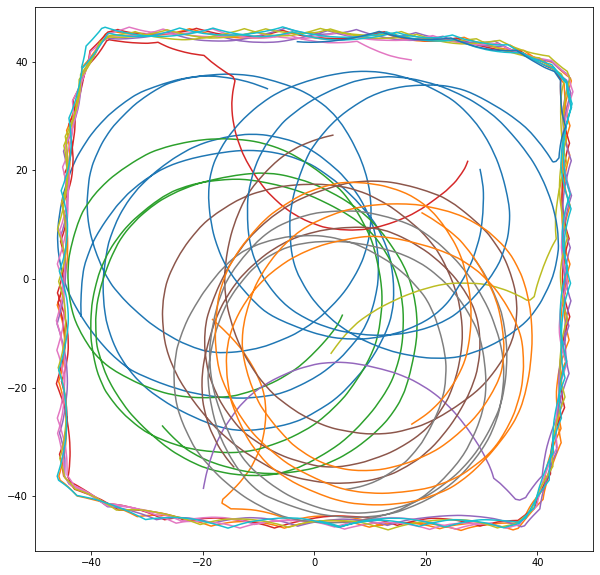

In [10]:
plt.figure(figsize=(10,10))
plt.xlim(-50,50)
plt.ylim(-50,50)
for fish_id in range(fishes):
    plt.plot(track[fish_id, :, 0], track[fish_id, :, 1])
plt.show()

In [11]:
def calculate_speed_from_position(track):
    speed = []
    
    for i in range(track.shape[1] - 1):
        s = ((track[0, i + 1, 0] - track[0, i, 0])**2 + (track[0, i + 1, 1] - track[0, i, 1])**2)**0.5
        speed.append(s)
    
    return np.array(speed)


In [12]:
speed = calculate_speed_from_position(track)
print(speed.shape)
print(speed.ndim)

bins = np.arange(start=0, stop=2, step=0.01)


(999,)
1


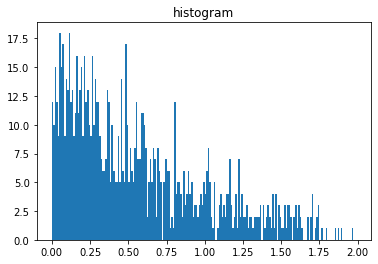

In [13]:
plt.hist(speed, bins) 
plt.title("histogram") 
plt.show()